In [1]:
install.packages("sandwich")
install.packages("coefplot")
install.packages("lmtest")


Installing package into 'C:/Users/Kaiyan Zhang/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'sandwich' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Kaiyan Zhang\AppData\Local\Temp\RtmpcrYo21\downloaded_packages


Installing package into 'C:/Users/Kaiyan Zhang/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'coefplot' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Kaiyan Zhang\AppData\Local\Temp\RtmpcrYo21\downloaded_packages


Installing package into 'C:/Users/Kaiyan Zhang/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'lmtest' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'lmtest'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\Kaiyan Zhang\AppData\Local\R\win-library\4.4\00LOCK\lmtest\libs\x64\lmtest.dll to C:\Users\Kaiyan Zhang\AppData\Local\R\win-library\4.4\lmtest\libs\x64\lmtest.dll: Permission denied"
Warning message:
"restored 'lmtest'"



The downloaded binary packages are in
	C:\Users\Kaiyan Zhang\AppData\Local\Temp\RtmpcrYo21\downloaded_packages


In [2]:
library(geojsonio)
library(tidyverse)
library(ggplot2)
library(tidyr)
library(dplyr)
library("knitr")
library(broom)
library(stargazer)
library(units)
library(sf)
library(car)
library(sandwich)
library(coefplot)
library(lmtest)


Warning message:
"package 'geojsonio' was built under R version 4.4.2"
Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson


Attaching package: 'geojsonio'


The following object is masked from 'package:base':

    pretty


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 


udunits database from

In [3]:
# Read in the data
census_index_crime <- st_read("census_new_index_crime.geojson") |>
    mutate(across(c(immigrant_prop, education_prop, mean_land_value,income), as.double))|>
    na.omit()|>
    glimpse()

Reading layer `census_new_index_crime' from data source 
  `C:\Users\Kaiyan Zhang\Desktop\econ326\census_new_index_crime.geojson' 
  using driver `GeoJSON'
Simple feature collection with 993 features and 18 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -123.2242 ymin: 49.19853 xmax: -123.0229 ymax: 49.31408
Geodetic CRS:  WGS 84


Warning message:
"There were 4 warnings in `stopifnot()`.
The first warning was:
ℹ In argument: `across(...)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings."


Rows: 989
Columns: 19
$ name                 <chr> "59150307", "59150308", "59150309", "59150310", "…
$ households           <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174,…
$ dwellings            <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189,…
$ population           <int> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 506…
$ population_density   <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.0, 6…
$ region               <chr> "Vancouver", "Vancouver", "Vancouver", "Vancouver…
$ area_sq_km           <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.08…
$ age                  <int> 630, 500, 745, 540, 530, 560, 1085, 555, 960, 510…
$ income               <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, 0.74…
$ immigrant_prop       <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0.404…
$ education_prop       <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0.253…
$ school_index         <dbl> 1.967207, 2.127046, 2.283703, 3.196982, 2.388786,…
$ light_index     

In [4]:
census_save <- census_index_crime|>
    st_drop_geometry()

write.csv(census_save, "census_new_index_crime.csv")


In [5]:
fn_residuals <- function(data, dependent_vars, independent_var) {
  
residuals_list <- list() #empty accumulator list

# looping through each variable and calcualting residuals
  for (var in dependent_vars) {
   formula <- as.formula(paste(var, "~", independent_var)) # https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/formula
    model <- lm(formula, data = data)
    residuals_list[[var]] <- resid(model) # extracting residuals and assigning to empty list
  }
  
  residuals_df <- as.data.frame(residuals_list)
  colnames(residuals_df) <- paste0("residual_", dependent_vars)

residuals_df <- cbind(residuals_df, data[dependent_vars]) |>
select(!geometry)

 return(residuals_df)
}


Rows: 989
Columns: 2
$ residual_bus_index <dbl> -1.46082894, -1.33233674, -1.01583673, 0.60583313, …
$ bus_index          <dbl> 2.182603, 2.310107, 2.631079, 4.245162, 2.604649, 2…


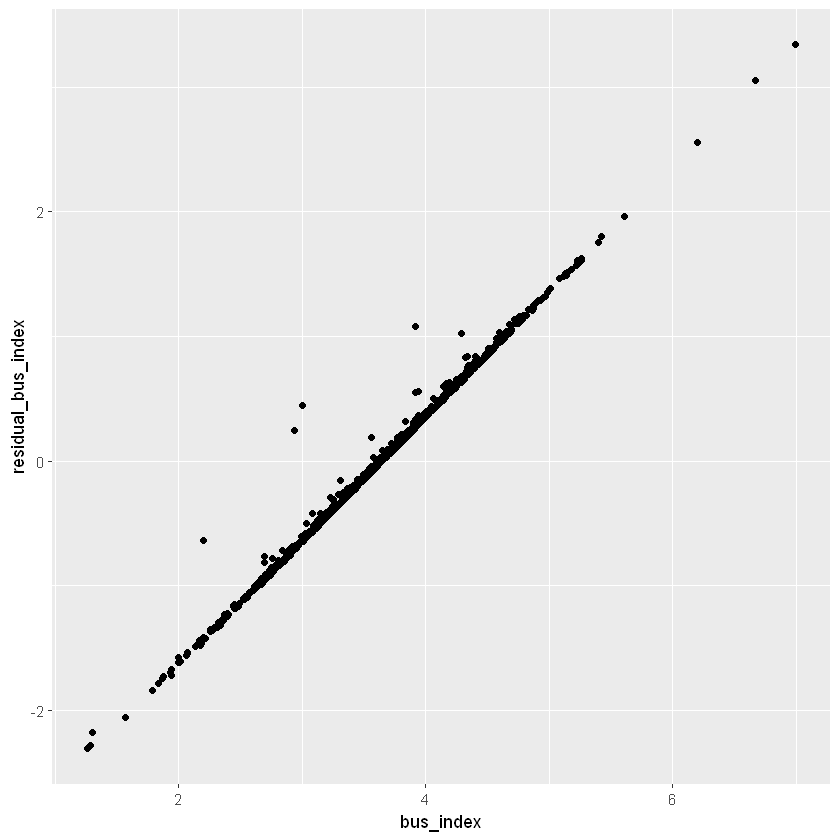

In [6]:
# test that the function works properly

residuals_bus <- fn_residuals(data = census_index_crime, dependent_var = "bus_index", independent_var = "mean_land_value")
glimpse(residuals_bus)

test_res <- residuals_bus |>
ggplot(aes(x=bus_index, y=residual_bus_index)) +geom_point()

test_res

In [7]:
dependent_vars <- c('mean_land_value','school_index', 'light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
residuals_df <- fn_residuals(census_index_crime, dependent_vars, "crime_rate")

In [8]:
glimpse(residuals_df)

Rows: 989
Columns: 16
$ residual_mean_land_value      <dbl> -0.9856555, -0.9116769, -1.1877007, -0.7…
$ residual_school_index         <dbl> -1.39530499, -1.23077431, -1.07778785, -…
$ residual_light_index          <dbl> -0.93109051, -1.04317317, -0.71002016, -…
$ residual_bus_index            <dbl> -1.43944160, -1.27914230, -0.98382436, 0…
$ residual_cultural_space_index <dbl> -0.83367408, -0.72723481, -0.64342760, -…
$ residual_income               <dbl> 0.178902630, 0.199103749, 0.115249759, -…
$ residual_immigrant_prop       <dbl> -0.156853743, -0.132295534, -0.063049582…
$ residual_education_prop       <dbl> -0.0274468049, -0.0551394647, -0.0202477…
$ mean_land_value               <dbl> 0.9556436, 1.0139412, 0.7501839, 1.19761…
$ school_index                  <dbl> 1.967207, 2.127046, 2.283703, 3.196982, …
$ light_index                   <dbl> 3.476492, 3.318048, 3.687467, 3.915391, …
$ bus_index                     <dbl> 2.182603, 2.310107, 2.631079, 4.245162, …
$ cultural_space_i

In [9]:

residuals_long <- residuals_df |>
  pivot_longer(
    cols = starts_with("residual_"), names_to = "residual_type", values_to = "residual_value") |>
  mutate(x_value = case_when(
    residual_type == "residual_mean_land_value" ~ mean_land_value,
    residual_type == "residual_school_index" ~ school_index,
    residual_type == "residual_light_index" ~ light_index,
    residual_type == "residual_bus_index" ~ bus_index,
    residual_type == "residual_cultural_space_index" ~ cultural_space_index,
    residual_type == "residual_income" ~ income,
    residual_type == "residual_immigrant_prop" ~ immigrant_prop,
    residual_type == "residual_education_prop" ~ education_prop
  ))

In [10]:
glimpse(residuals_long)

Rows: 7,912
Columns: 11
$ mean_land_value      <dbl> 0.9556436, 0.9556436, 0.9556436, 0.9556436, 0.955…
$ school_index         <dbl> 1.967207, 1.967207, 1.967207, 1.967207, 1.967207,…
$ light_index          <dbl> 3.476492, 3.476492, 3.476492, 3.476492, 3.476492,…
$ bus_index            <dbl> 2.182603, 2.182603, 2.182603, 2.182603, 2.182603,…
$ cultural_space_index <dbl> 2.157921, 2.157921, 2.157921, 2.157921, 2.157921,…
$ income               <dbl> 0.90965, 0.90965, 0.90965, 0.90965, 0.90965, 0.90…
$ immigrant_prop       <dbl> 0.2610759, 0.2610759, 0.2610759, 0.2610759, 0.261…
$ education_prop       <dbl> 0.3085443, 0.3085443, 0.3085443, 0.3085443, 0.308…
$ residual_type        <chr> "residual_mean_land_value", "residual_school_inde…
$ residual_value       <dbl> -0.98565550, -1.39530499, -0.93109051, -1.4394416…
$ x_value              <dbl> 0.9556436, 1.9672073, 3.4764917, 2.1826031, 2.157…


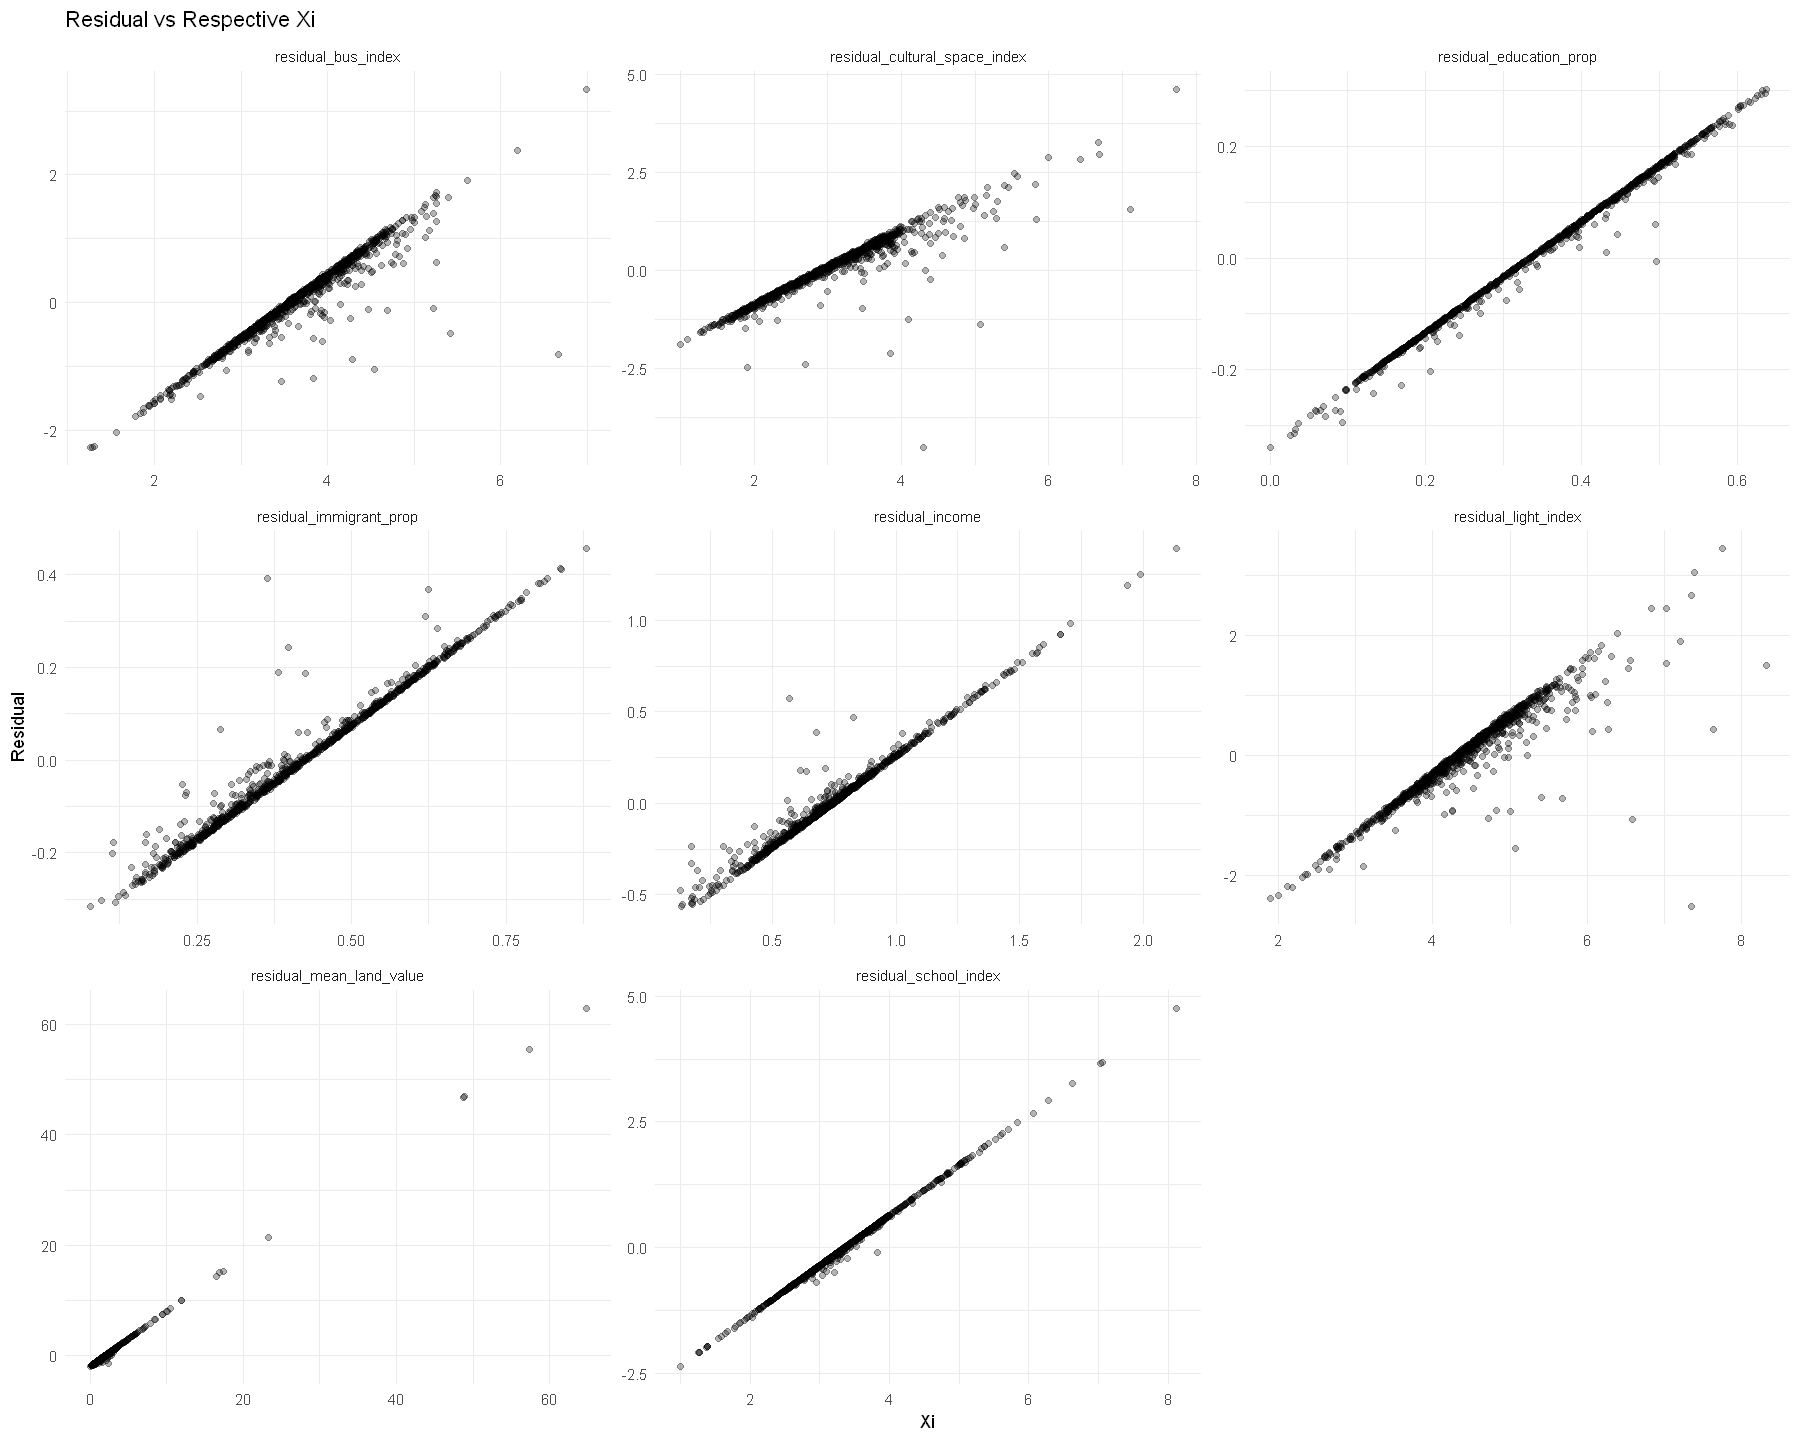

In [11]:
options(repr.plot.width = 15, repr.plot.height = 12)

residuals_plot <- ggplot(residuals_long, aes(x = x_value, y = residual_value)) +
  geom_point(alpha = 0.3) +
  facet_wrap(~ residual_type, scales = "free") +
  labs(
    title = "Residual vs Respective Xi",
    x = "Xi",
    y = "Residual") +
  theme_minimal()

residuals_plot

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `model = list(lm(residual_value ~ x_value, data = cur_data()))`.
ℹ In group 1: `residual_type = "residual_bus_index"`.
Caused by warning:
! `cur_data()` was deprecated in dplyr 1.1.0.
ℹ Please use `pick()` instead."
Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


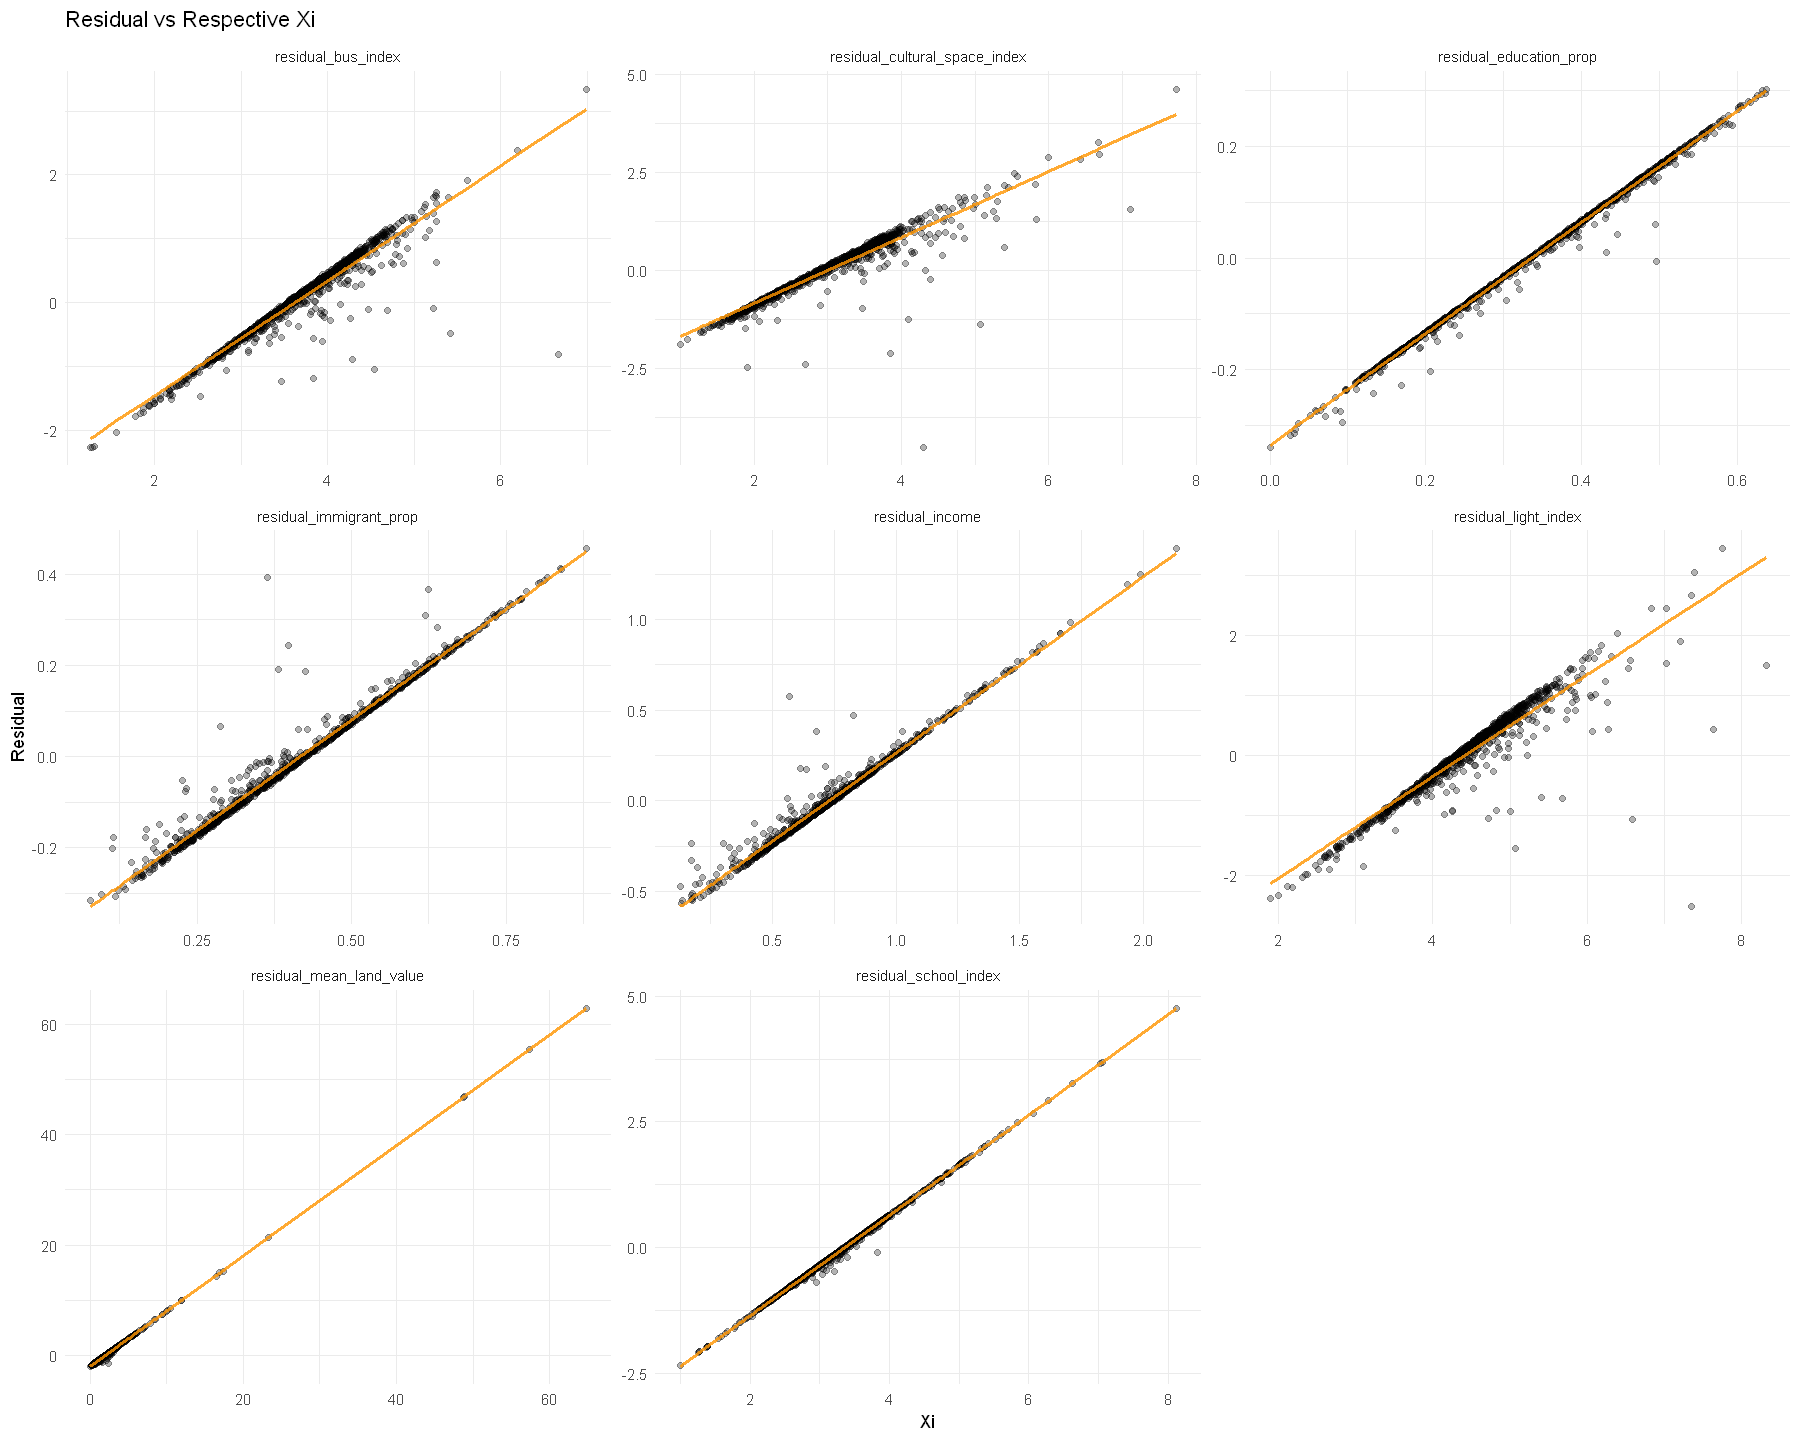

In [12]:
residuals_long  <- residuals_long |>
  group_by(residual_type) |>
  mutate(
    model = list(lm(residual_value ~ x_value, data = cur_data())),
    fitted_values = predict(model[[1]], newdata = data.frame(x_value = x_value))
  ) |>
  ungroup()

ggplot(residuals_long, aes(x = x_value, y = residual_value)) +
  geom_point(alpha=0.3) +
  geom_line(aes(y = fitted_values), color = "#ff9500", size=1, alpha=0.8) +  
  facet_wrap(~ residual_type, scales = "free") +
  labs(
    title = "Residual vs Respective Xi",
    x = "Xi",
    y = "Residual"
  ) +
  theme_minimal()

In [13]:
regressors <- c('mean_land_value','school_index', 'light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
residuals_df <- fn_residuals(census_index_crime, regressors, "crime_rate") |>
mutate(crime_rate = census_index_crime$crime_rate) 

glimpse(residuals_df)


colnames(residuals_df)

Rows: 989
Columns: 17
$ residual_mean_land_value      <dbl> -0.9856555, -0.9116769, -1.1877007, -0.7…
$ residual_school_index         <dbl> -1.39530499, -1.23077431, -1.07778785, -…
$ residual_light_index          <dbl> -0.93109051, -1.04317317, -0.71002016, -…
$ residual_bus_index            <dbl> -1.43944160, -1.27914230, -0.98382436, 0…
$ residual_cultural_space_index <dbl> -0.83367408, -0.72723481, -0.64342760, -…
$ residual_income               <dbl> 0.178902630, 0.199103749, 0.115249759, -…
$ residual_immigrant_prop       <dbl> -0.156853743, -0.132295534, -0.063049582…
$ residual_education_prop       <dbl> -0.0274468049, -0.0551394647, -0.0202477…
$ mean_land_value               <dbl> 0.9556436, 1.0139412, 0.7501839, 1.19761…
$ school_index                  <dbl> 1.967207, 2.127046, 2.283703, 3.196982, …
$ light_index                   <dbl> 3.476492, 3.318048, 3.687467, 3.915391, …
$ bus_index                     <dbl> 2.182603, 2.310107, 2.631079, 4.245162, …
$ cultural_space_i

[1] "residual_mean_land_value"      "residual_school_index"        
 [3] "residual_light_index"          "residual_bus_index"           
 [5] "residual_cultural_space_index" "residual_income"              
 [7] "residual_immigrant_prop"       "residual_education_prop"      
 [9] "mean_land_value"               "school_index"                 
[11] "light_index"                   "bus_index"                    
[13] "cultural_space_index"          "income"                       
[15] "immigrant_prop"                "education_prop"               
[17] "crime_rate"

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(regressors)

  # Now:
  data %>% select(all_of(regressors))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


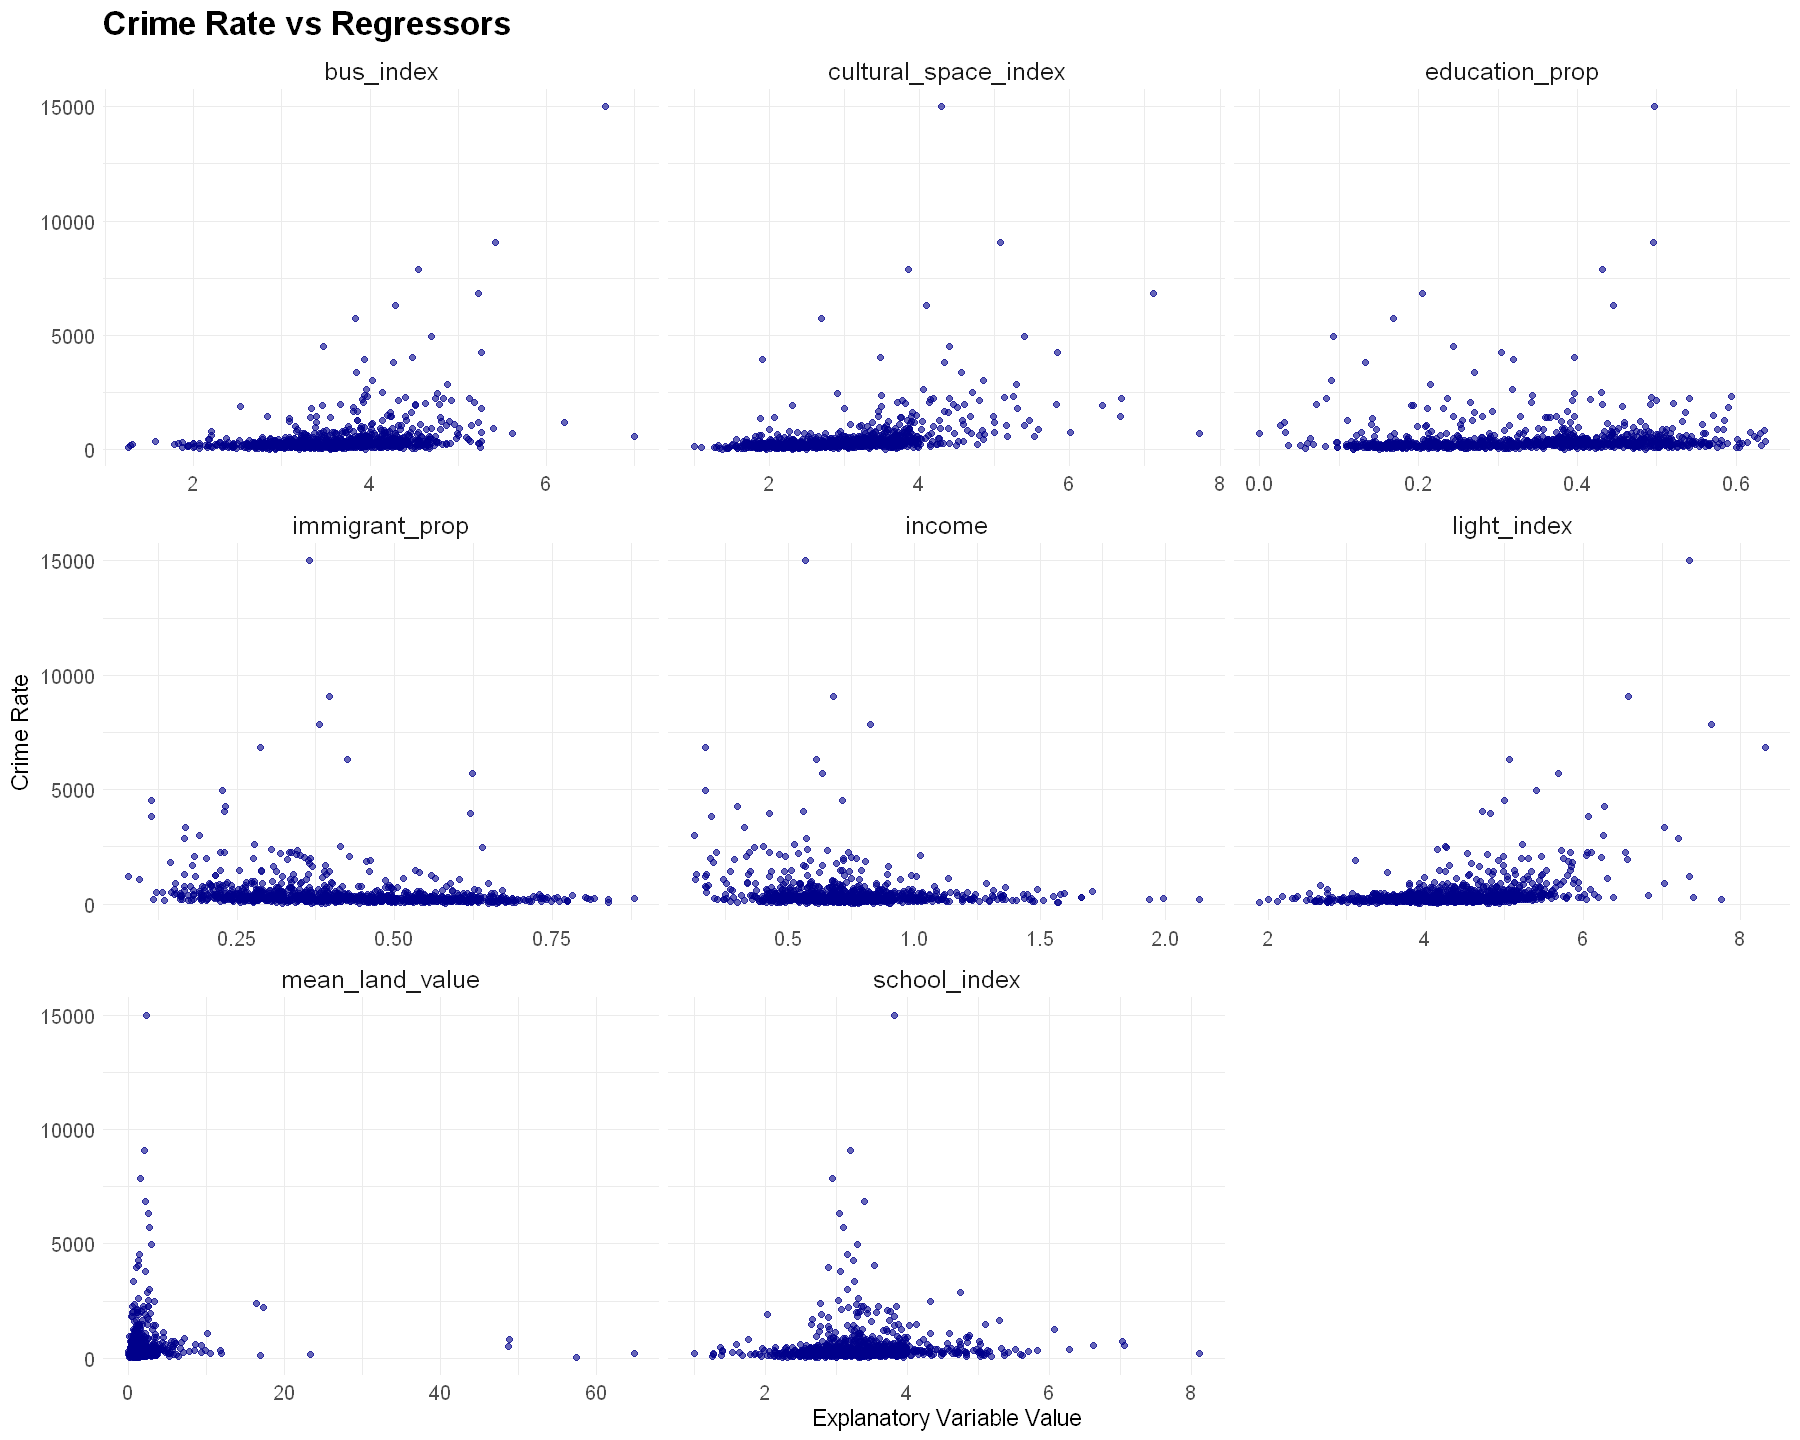

In [14]:
regressors <- c('mean_land_value','school_index', 'light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')

long_data <- census_index_crime |>
  pivot_longer(cols = regressors,
               names_to = "regressor",
               values_to = "value")

variables_scatter <- ggplot(long_data, aes(x = value, y = crime_rate)) +
  geom_point(color = "darkblue", alpha = 0.6) +
  facet_wrap(~ regressor, scales = "free_x") + 
  labs(title = "Crime Rate vs Regressors",
       x = "Explanatory Variable Value",
       y = "Crime Rate") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        strip.text = element_text(size = 15),  
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

variables_scatter

By eyeball method, it's clear that the data is itself heteoskedastic.

In [15]:
# Carry out all the simple regressions
outcome <- "crime_rate"

simple_regressions <- map(regressors, ~ lm(as.formula(paste(outcome, "~", .x)), data = census_index_crime))

names(simple_regressions) <- regressors

stargazer(simple_regressions, type = "text",
          title = "Simple Regression Results",
          dep.var.labels = c("Crime Rate"))


Simple Regression Results
                                                                    Dependent variable:                                     
                               ---------------------------------------------------------------------------------------------
                                                                        Crime Rate                                          
                                  (1)        (2)         (3)          (4)         (5)         (6)         (7)        (8)    
----------------------------------------------------------------------------------------------------------------------------
mean_land_value                  6.177                                                                                      
                                (7.023)                                                                                     
                                                                                                  

`geom_smooth()` using formula = 'y ~ x'


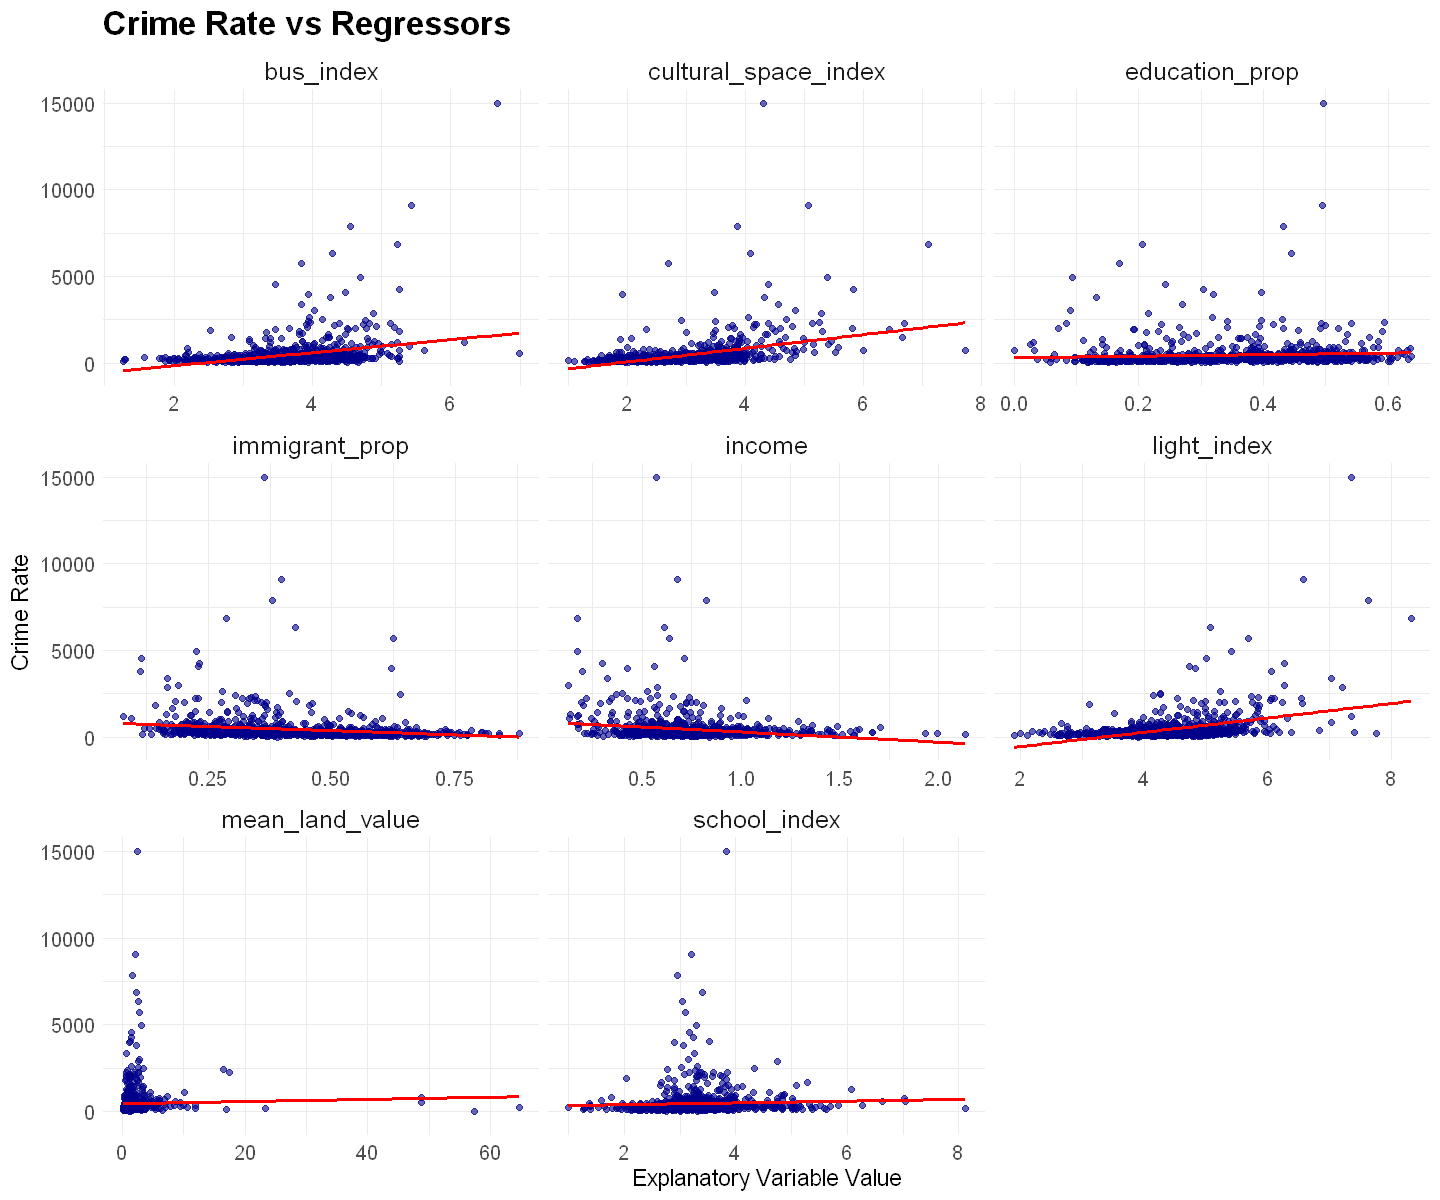

In [16]:
# Visualizing simple regressions
options(repr.plot.width = 12, repr.plot.height = 10)
simple_regression_plot <- variables_scatter +  geom_smooth(method = "lm", se = FALSE, color = "red") 

simple_regression_plot

In [17]:
# Test by running a model including all control
reg_all <- lm(crime_rate ~ mean_land_value + school_index + light_index + bus_index + cultural_space_index + 
    income + immigrant_prop + education_prop, data = census_index_crime)
    
stargazer(reg_all, type = "text",
          title = "Regression With All Variable Results",
          dep.var.labels = c("Crime Rate"))


Regression With All Variable Results
                         Dependent variable:    
                     ---------------------------
                             Crime Rate         
------------------------------------------------
mean_land_value                 7.998           
                               (6.161)          
                                                
school_index                 -320.348***        
                              (40.421)          
                                                
light_index                  415.367***         
                              (52.159)          
                                                
bus_index                      30.722           
                              (57.654)          
                                                
cultural_space_index         200.448***         
                              (49.038)          
                                                
income                       -2

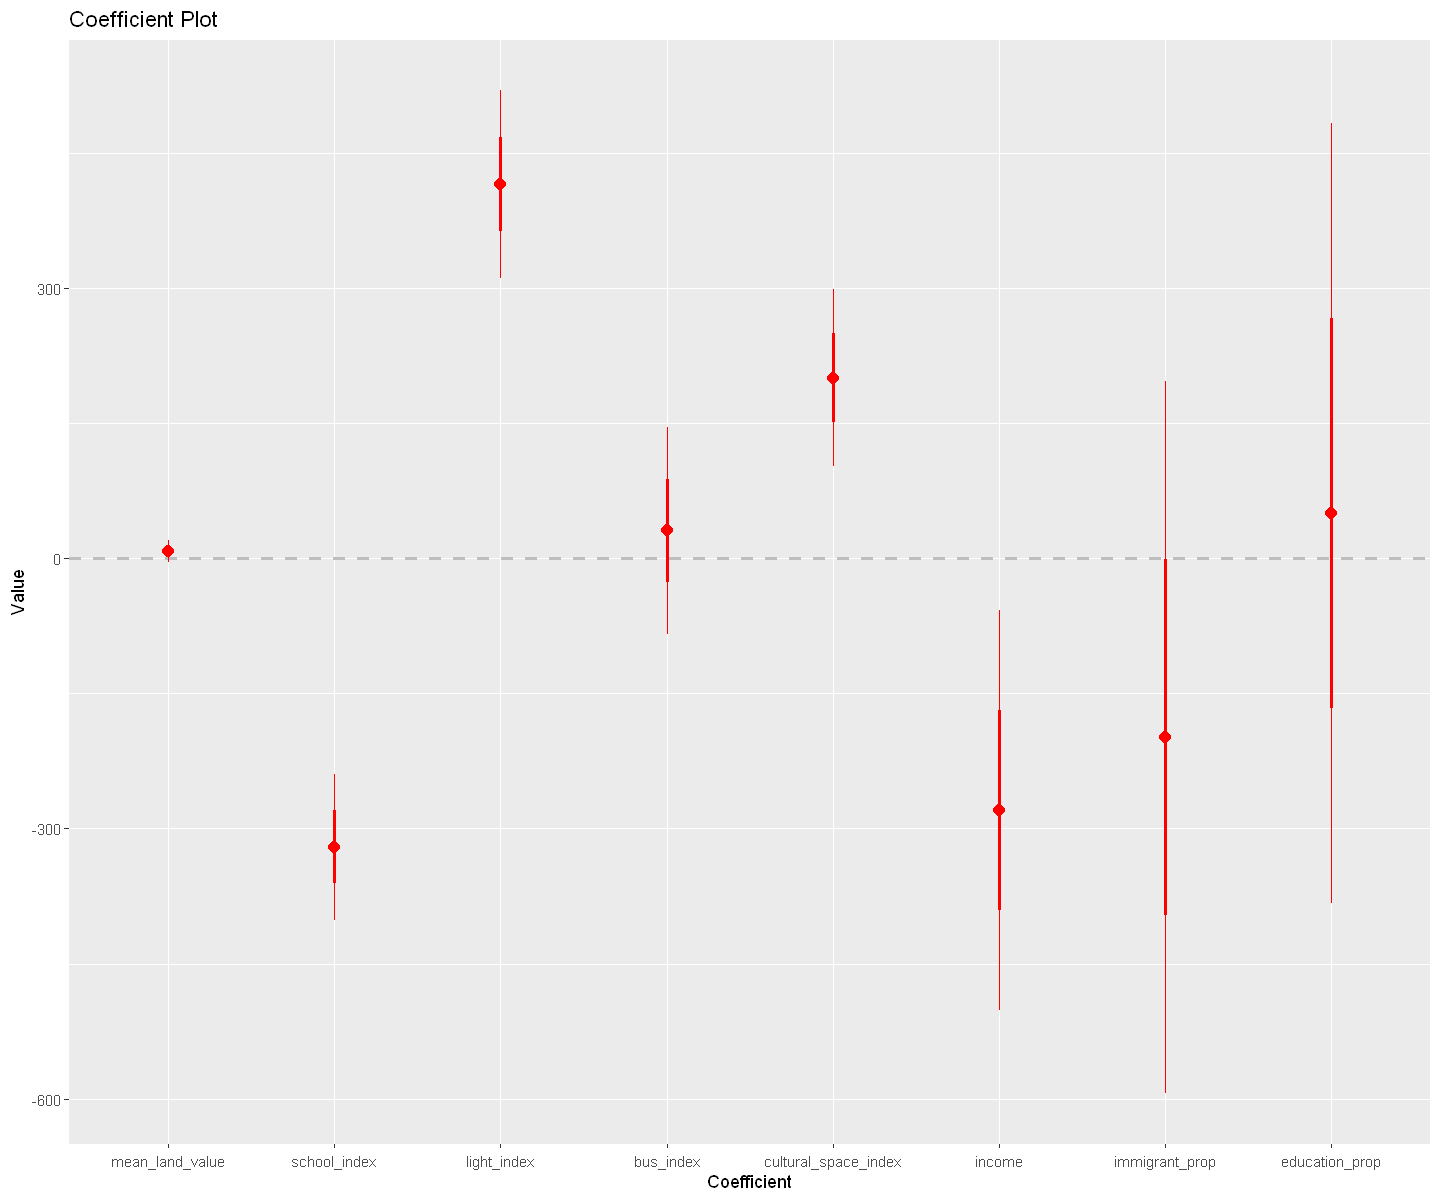

In [18]:
coefplot(reg_all, intercept = FALSE, horizontal = TRUE, color = "red")

The regression output above suggests that bus_index, immigrant_prop, and education_prop variables may be insignificant for having p-values > 0.1

In [19]:
# Examining the vif of the model
vif(reg_all, type = "terms")|>
tidy()

Warning message in tidy.numeric(vif(reg_all, type = "terms")):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
mean_land_value,1.023162
school_index,1.607921
light_index,3.238495
bus_index,3.080484
cultural_space_index,3.217620
income,1.401204
immigrant_prop,1.630032
education_prop,1.571661


In [20]:
# Predict y_hat
y_hat <- predict(reg_all)

In [21]:
# Carry out white's test
white <- lm(reg_all$residuals^2 ~ y_hat + I(y_hat^2))

stargazer(white, type = "text",
          title = "White's Test",
          dep.var.labels = c("Residual"))


White's Test
                        Dependent variable:    
                    ---------------------------
                             Residual          
-----------------------------------------------
y_hat                      -1,741.985**        
                             (735.017)         
                                               
I(y_hat2)                    3.610***          
                              (0.467)          
                                               
Constant                    -83,764.300        
                           (280,247.700)       
                                               
-----------------------------------------------
Observations                    989            
R2                             0.098           
Adjusted R2                    0.096           
Residual Std. Error  5,623,095.000 (df = 986)  
F Statistic           53.569*** (df = 2; 986)  
Note:               *p<0.1; **p<0.05; ***p<0.01


In [22]:
# Continuing on white's test
linearHypothesis(white, c("y_hat = 0", "I(y_hat^2) = 0"))

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,988,3.456412e+16,NA,NA,NA,NA
2,986,3.117652e+16,2,3.387597e+15,53.56868,8.216281e-23


The extremely small p-value suggests rejecting the null hypothesis that residuals are constant.
This means there is strong evidence of heteroskedasticity in the data. We need to use robust standard errors to resolve this issue.

In [23]:
reg1 <- lm(crime_rate ~ school_index + light_index + cultural_space_index + 
    income, data = census_index_crime)

stargazer(reg1, type = "text",
          title = "Regression With Significant Controls",
          dep.var.labels = c("Crime Rate"))


Regression With Significant Controls
                         Dependent variable:    
                     ---------------------------
                             Crime Rate         
------------------------------------------------
school_index                 -319.198***        
                              (38.640)          
                                                
light_index                  410.516***         
                              (40.955)          
                                                
cultural_space_index         241.313***         
                              (35.572)          
                                                
income                       -259.731***        
                              (97.444)          
                                                
Constant                     -812.062***        
                              (163.956)         
                                                
-------------------------------

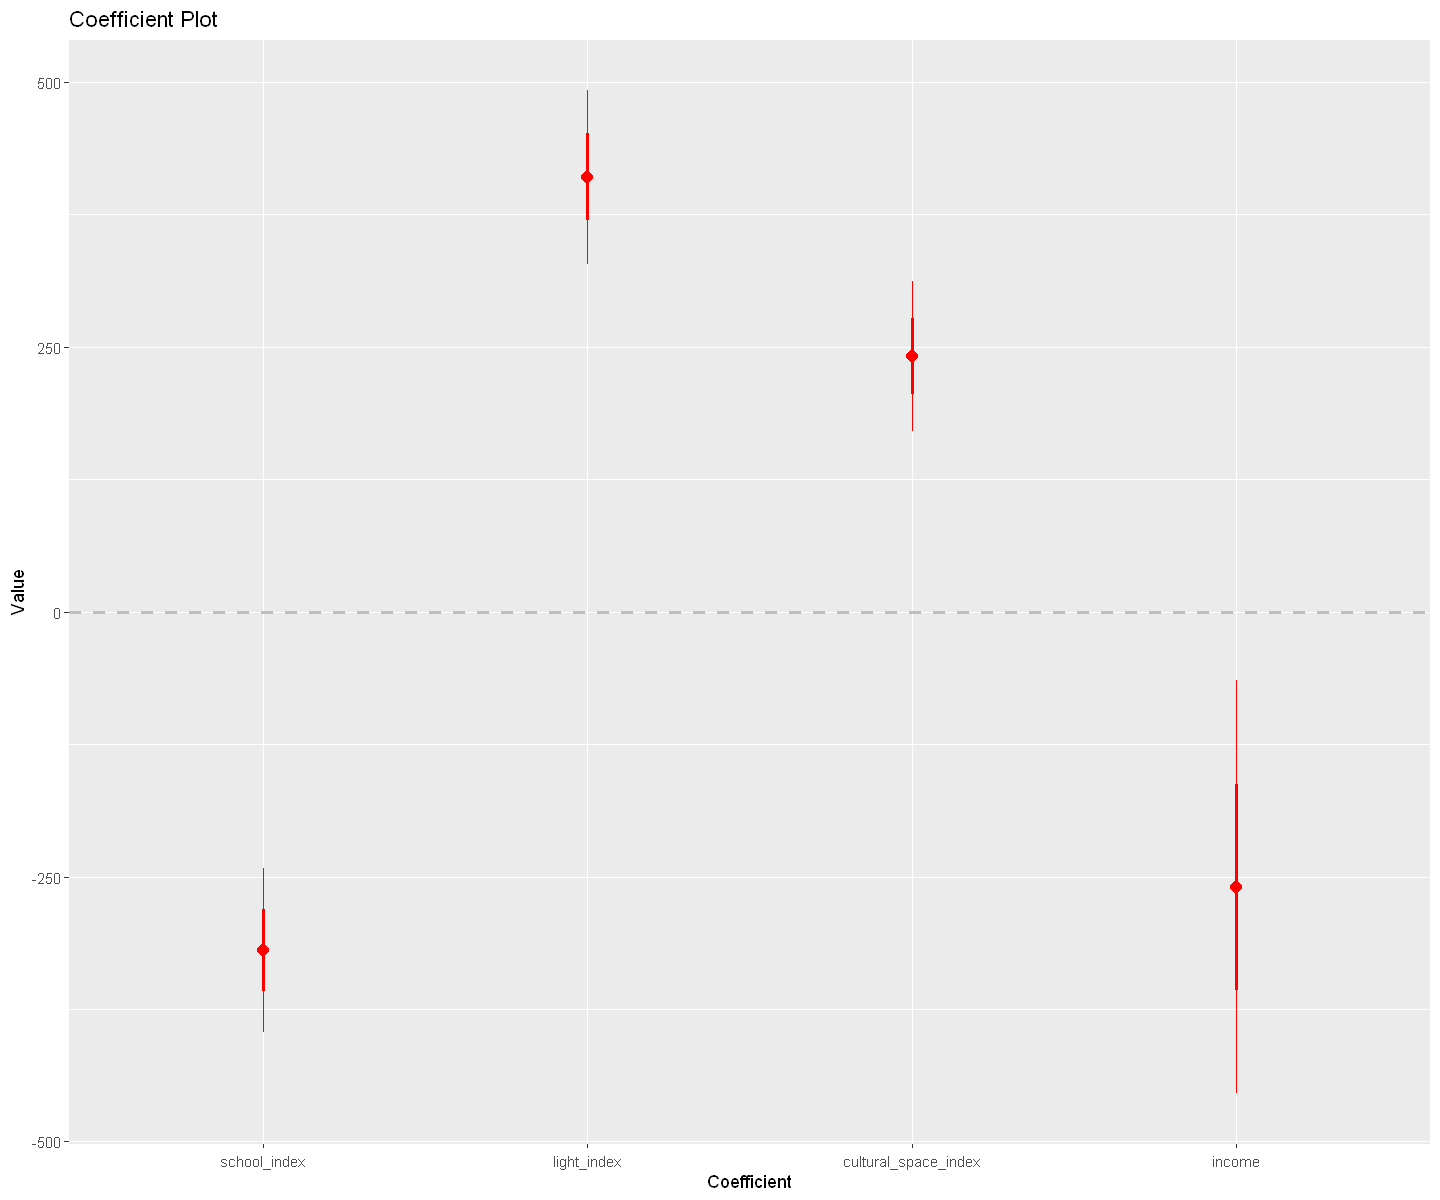

In [24]:
coefplot(reg1, intercept = FALSE, horizontal = TRUE, color = "red")

In [25]:
stargazer(simple_regressions, reg1, reg_all,
          type = "text", 
          title = "Regression Results",
          dep.var.labels = c("Crime Rate","Crime Rate"))


Regression Results
                                                                                                                               Dependent variable:                                                                                                           
                     ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                            Crime Rate                                                                                                          Crime Rate                   
                             (1)                 (2)                   (3)                      (4)                      (5)                      (6)                     (7)                    (8)                    (9

We want to make sure what made land_value and bus_index insignificant and school_index significant in our model with all variables, so we continue to run other models.

In [26]:
# Regressions with land_value always present
regressors_without_land_value <- c( 'school_index','light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
reg_with_land_value <-  map(regressors, ~ lm(as.formula(paste(outcome, "~ mean_land_value +", .x)), data = census_index_crime))

names(reg_with_land_value) <- regressors

stargazer(reg_with_land_value, type = "text",
          title = "Regression Results",
          dep.var.labels = c("Crime Rate"))


Regression Results
                                                                                                     Dependent variable:                                                                                 
                     ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                          Crime Rate                                                                                     
                             (1)                 (2)                   (3)                     (4)                     (5)                     (6)                     (7)                   (8)         
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
# Regressions with school always present
regressors_without_school <- c( 'mean_land_value','light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
reg_with_school <-  map(regressors, ~ lm(as.formula(paste(outcome, "~ school_index +",  .x)), data = census_index_crime))

names(reg_with_school) <- regressors

stargazer(reg_with_school, type = "text",
          title = "Regression Results",
          dep.var.labels = c("Crime Rate"))


Regression Results
                                                                                                       Dependent variable:                                                                                  
                     ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                           Crime Rate                                                                                       
                             (1)                 (2)                   (3)                      (4)                     (5)                      (6)                     (7)                    (8)         
----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
# Regressions with bus always present
regressors_without_bus <- c( 'mean_land_value','school_index','light_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
reg_with_bus <-  map(regressors, ~ lm(as.formula(paste(outcome, "~ bus_index +",  .x)), data = census_index_crime))

names(reg_with_bus) <- regressors

stargazer(reg_with_bus, type = "text",
          title = "Regression Results",
          dep.var.labels = c("Crime Rate"))


Regression Results
                                                                                                           Dependent variable:                                                                                       
                     ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                Crime Rate                                                                                           
                               (1)                     (2)                     (3)                     (4)                      (5)                     (6)                     (7)                     (8)          
----------------------------------------------------------------------------------------------------------------------------

From results above, we may conclude that mean land value is itself statistically insignificant, school is statistically significant when coexisting with most other variables, and bus is made insignificant by light_index (Which matched our hypothesis with visualization in fianl proposal). 

In [29]:
# Applying robust standard error to the first model
se <- sqrt(diag(vcovHC(reg_all, type = "HC1")))

stargazer(reg_all, reg_all, se = list(NULL, se), type = "text", column.labels=c("default","robust"), dep.var.labels = c("Crime Rate"))


                                   Dependent variable:     
                               ----------------------------
                                        Crime Rate         
                                  default        robust    
                                    (1)            (2)     
-----------------------------------------------------------
mean_land_value                    7.998          7.998    
                                  (6.161)        (7.369)   
                                                           
school_index                    -320.348***    -320.348*** 
                                  (40.421)      (81.012)   
                                                           
light_index                      415.367***    415.367***  
                                  (52.159)      (113.926)  
                                                           
bus_index                          30.722        30.722    
                                  (57.6


                                     Dependent variable:    
                                 ---------------------------
                                         Crime Rate         
------------------------------------------------------------
mean_land_value                             6.138           
                                           (5.607)          
                                                            
school_index                             -167.378***        
                                          (42.200)          
                                                            
education_prop                             47.129           
                                          (216.150)         
                                                            
immigrant_prop                             59.620           
                                          (205.062)         
                                                            
income                 

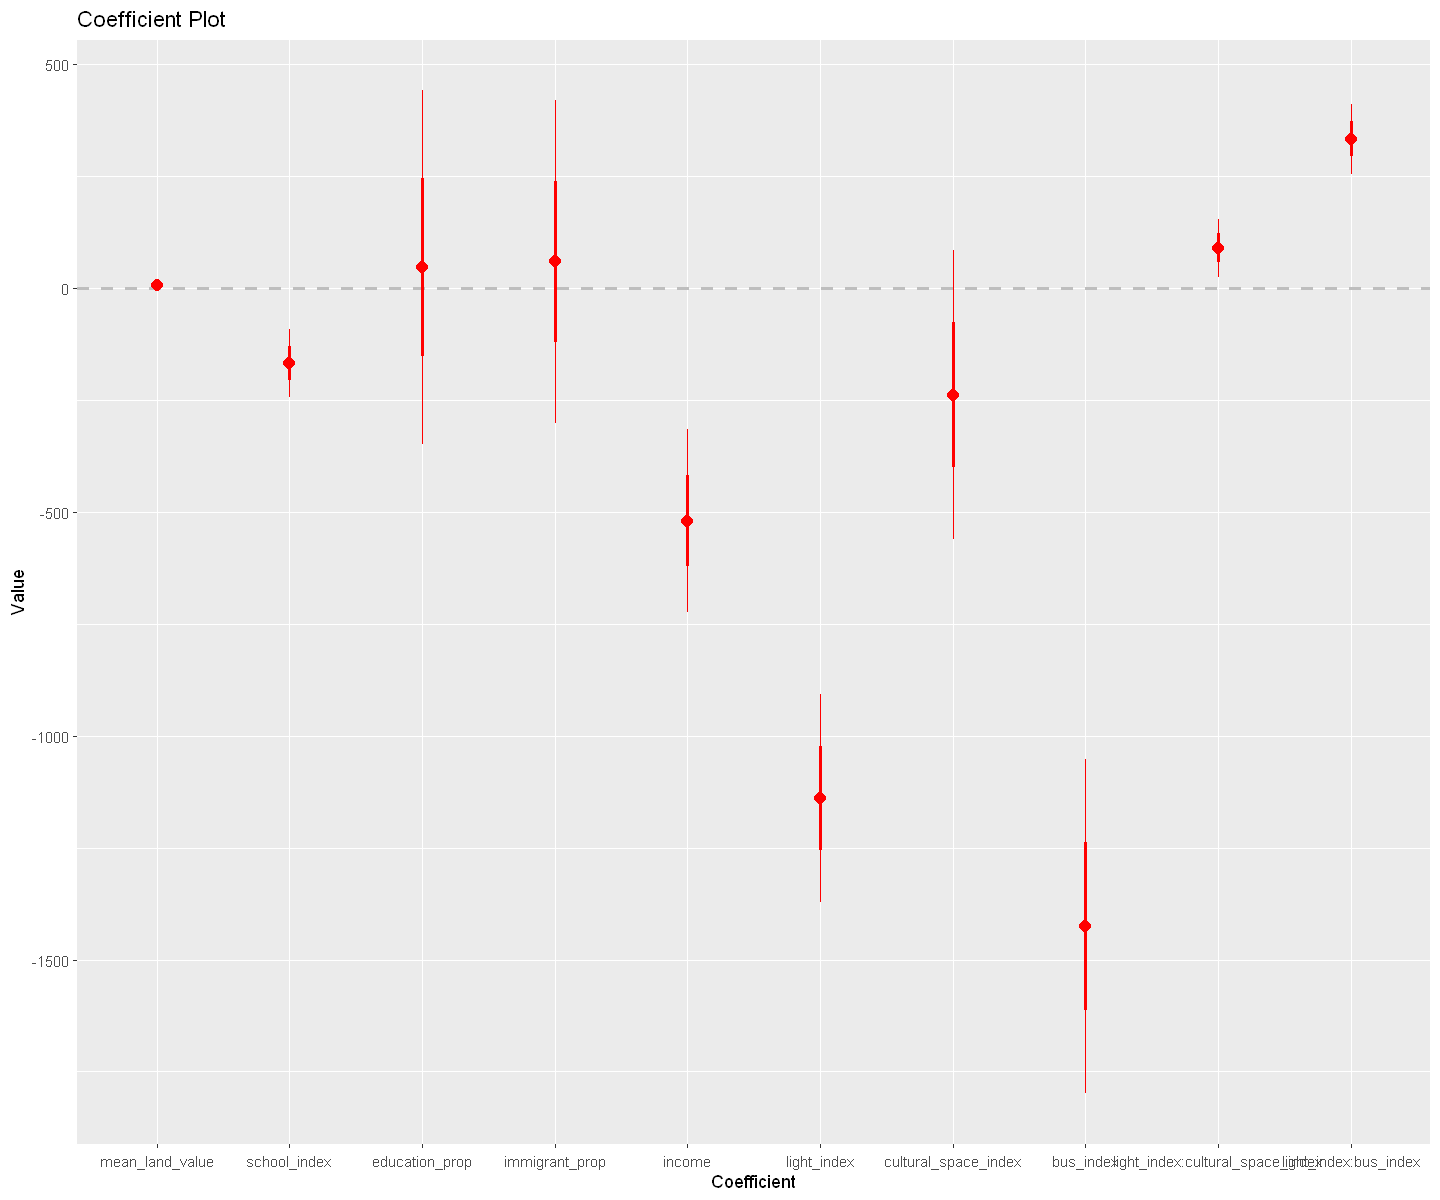

In [30]:
# Testing our specifications in final proposal, with robust standard error
reg_interaction <- lm(crime_rate ~ mean_land_value + school_index + education_prop + immigrant_prop + income + light_index
     + cultural_space_index + bus_index + light_index:cultural_space_index + light_index:bus_index, data = census_index_crime)
     
se_interaction <- sqrt(diag(vcovHC(reg_interaction, type = "HC1")))

stargazer(reg_interaction, se = list(se_interaction), type = "text", dep.var.labels = c("Crime Rate"))

coefplot(reg_interaction, intercept = FALSE, horizontal = TRUE, color = "red")

Although all explanatory variables have large p-values, the model generally has a larger F statistic comparing to previous model including all variables. However the F statistic is still lower than that excluded "insignificant" controls.


                             Dependent variable:    
                         ---------------------------
                                 Crime Rate         
----------------------------------------------------
mean_land_value                     4.377           
                                   (5.607)          
                                                    
school_index                     -146.953***        
                                  (42.200)          
                                                    
education_prop                     -51.997          
                                  (216.150)         
                                                    
immigrant_prop                     35.790           
                                  (205.062)         
                                                    
income                           -489.597***        
                                  (173.440)         
                                             

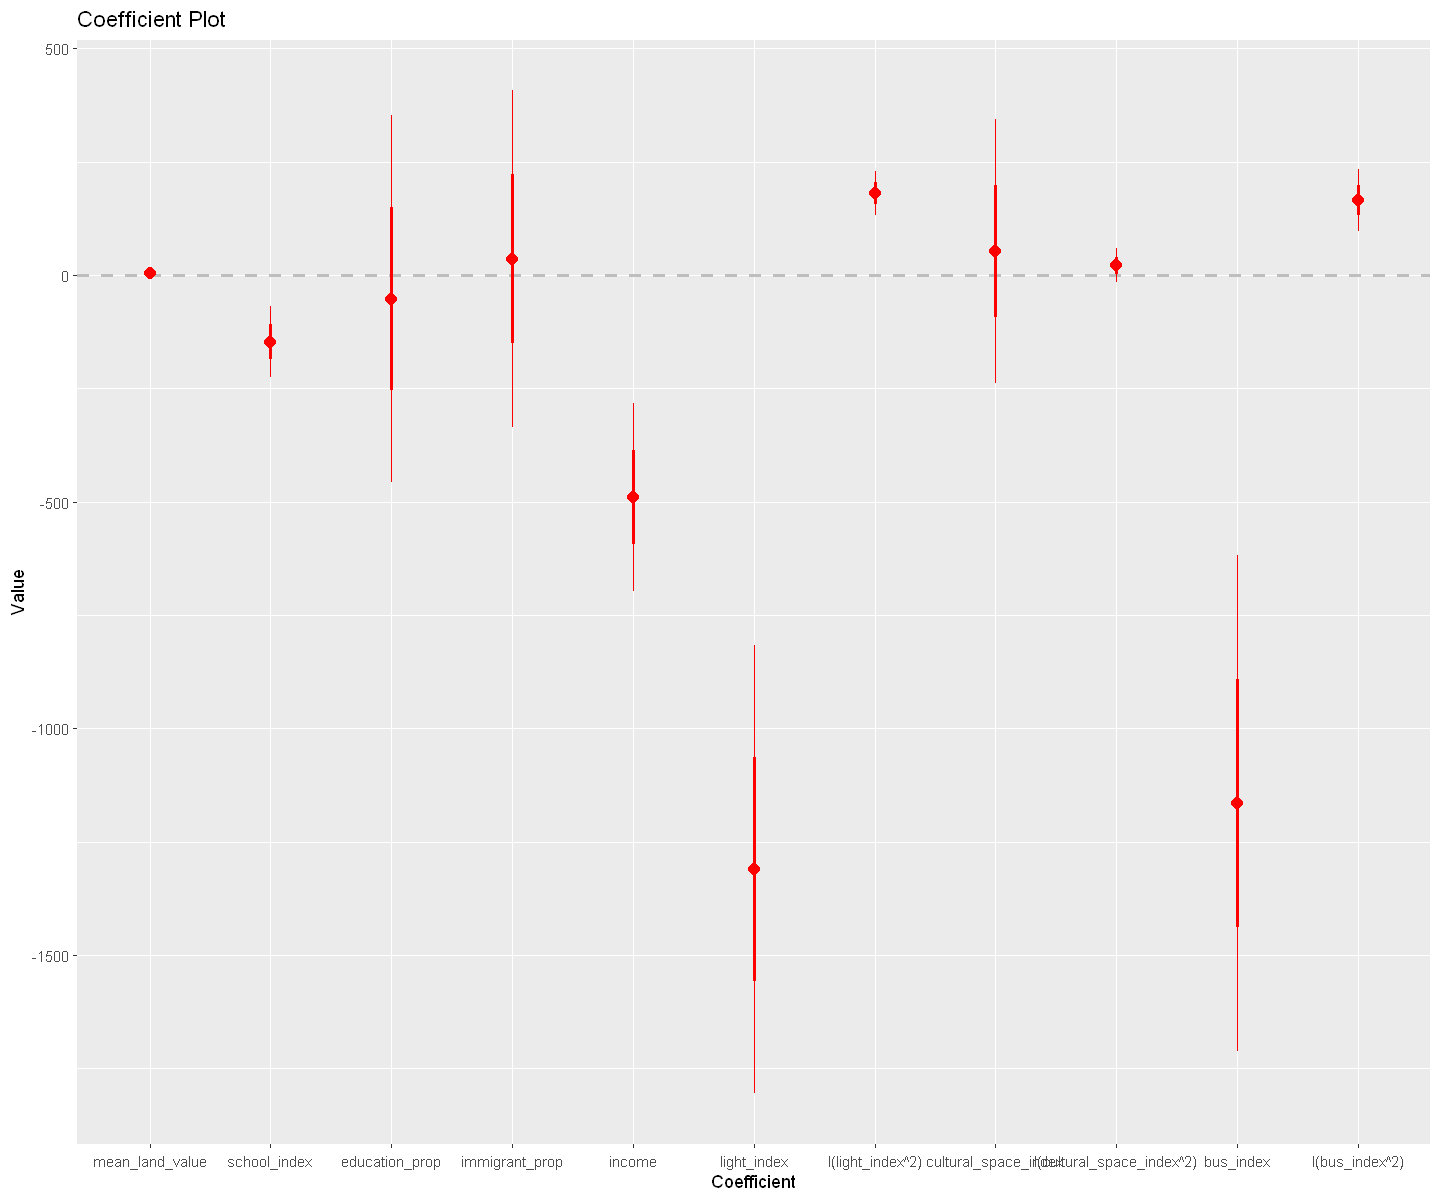

In [31]:
# Testing the specification with quadratic terms
reg_squared <- lm(crime_rate ~ mean_land_value + school_index  + education_prop + immigrant_prop + income + light_index + I(light_index^2)
     + cultural_space_index + I(cultural_space_index^2) + bus_index + I(bus_index^2), data = census_index_crime)
     
se_squared <- sqrt(diag(vcovHC(reg_squared, type = "HC1")))

stargazer(reg_squared, se =  list(se_interaction), type = "text", dep.var.labels = c("Crime Rate"))

coefplot(reg_squared, intercept = FALSE, horizontal = TRUE, color = "red")

We noticed a situation that is similar to the model with interaction happened.  

In [32]:
# Show four fitted models in a single output table
se_short <- sqrt(diag(vcovHC(reg1, type = "HC1")))

stargazer(reg1, reg_all, reg_interaction, reg_squared, se = list(se_short, se, se_interaction, se_squared), 
column.labels = c("short","all", "interaction", "squared"),  type = "text", dep.var.labels = c("Crime Rate"))


                                                                        Dependent variable:                                       
                                 -------------------------------------------------------------------------------------------------
                                                                            Crime Rate                                            
                                          short                    all                 interaction                squared         
                                           (1)                     (2)                     (3)                      (4)           
----------------------------------------------------------------------------------------------------------------------------------
mean_land_value                                                   7.998                   6.138                    4.377          
                                                                 (7.369)          

In [33]:
reg2 <- lm(crime_rate ~ log(mean_land_value), data = census_index_crime)
reg3 <- lm(crime_rate ~ mean_land_value + I(mean_land_value^2), data = census_index_crime)

se2 <- sqrt(diag(vcovHC(reg2, type = "HC1")))
se3 <- sqrt(diag(vcovHC(reg3, type = "HC1")))

stargazer(reg2, reg3, se = list(se2, se3), 
column.labels = c("log","squared"),  type = "text", dep.var.labels = c("Crime Rate"))


                                 Dependent variable:             
                     --------------------------------------------
                                      Crime Rate                 
                              log                  squared       
                              (1)                    (2)         
-----------------------------------------------------------------
log(mean_land_value)       112.107***                            
                            (33.032)                             
                                                                 
mean_land_value                                   50.700***      
                                                  (16.400)       
                                                                 
I(mean_land_value2)                               -0.905***      
                                                   (0.284)       
                                                                 
Constant 

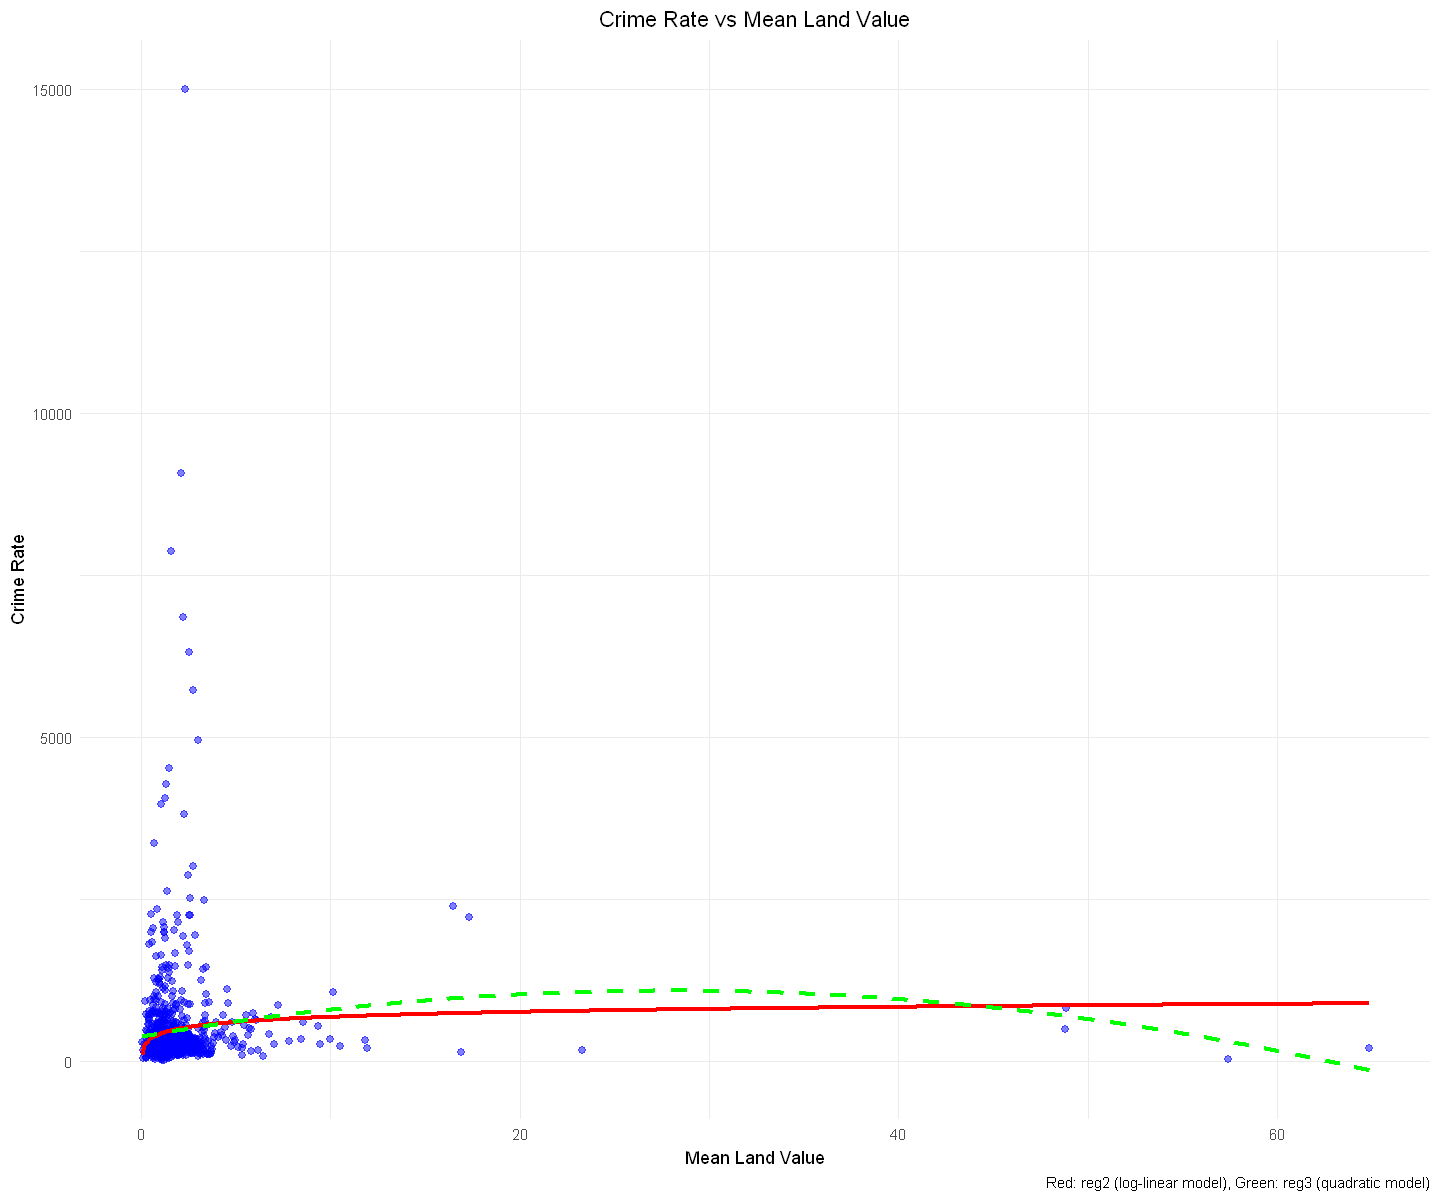

In [34]:
# Create a new data frame for predictions
census_index_crime$pred_reg2 <- predict(reg2)  # Predictions from reg2
census_index_crime$pred_reg3 <- predict(reg3)  # Predictions from reg3

# Generate a sequence of `mean_land_value` for smoother curves
land_value_seq <- seq(min(census_index_crime$mean_land_value), max(census_index_crime$mean_land_value), length.out = 500)

# Predictions for smoother visualization
smooth_data <- data.frame(
  mean_land_value = land_value_seq,
  pred_reg2 = predict(reg2, newdata = data.frame(mean_land_value = land_value_seq)),
  pred_reg3 = predict(reg3, newdata = data.frame(mean_land_value = land_value_seq))
)

# Plot observed data and regression lines
ggplot(census_index_crime, aes(x = mean_land_value, y = crime_rate)) +
  geom_point(alpha = 0.5, color = "blue", size = 2) + # Data points
  geom_line(data = smooth_data, aes(x = mean_land_value, y = pred_reg2), color = "red", size = 1.2) + # reg2 line
  geom_line(data = smooth_data, aes(x = mean_land_value, y = pred_reg3), color = "green", size = 1.2, linetype = "dashed") + # reg3 line
  labs(
    title = "Crime Rate vs Mean Land Value",
    x = "Mean Land Value",
    y = "Crime Rate",
    caption = "Red: reg2 (log-linear model), Green: reg3 (quadratic model)"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))


Call:
lm(formula = log(crime_rate) ~ log(mean_land_value), data = census_index_crime)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0182 -0.4950 -0.0926  0.3789  3.8690 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           5.63804    0.02848 197.951  < 2e-16 ***
log(mean_land_value)  0.12731    0.03736   3.408 0.000682 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8122 on 987 degrees of freedom
Multiple R-squared:  0.01163,	Adjusted R-squared:  0.01063 
F-statistic: 11.61 on 1 and 987 DF,  p-value: 0.000682


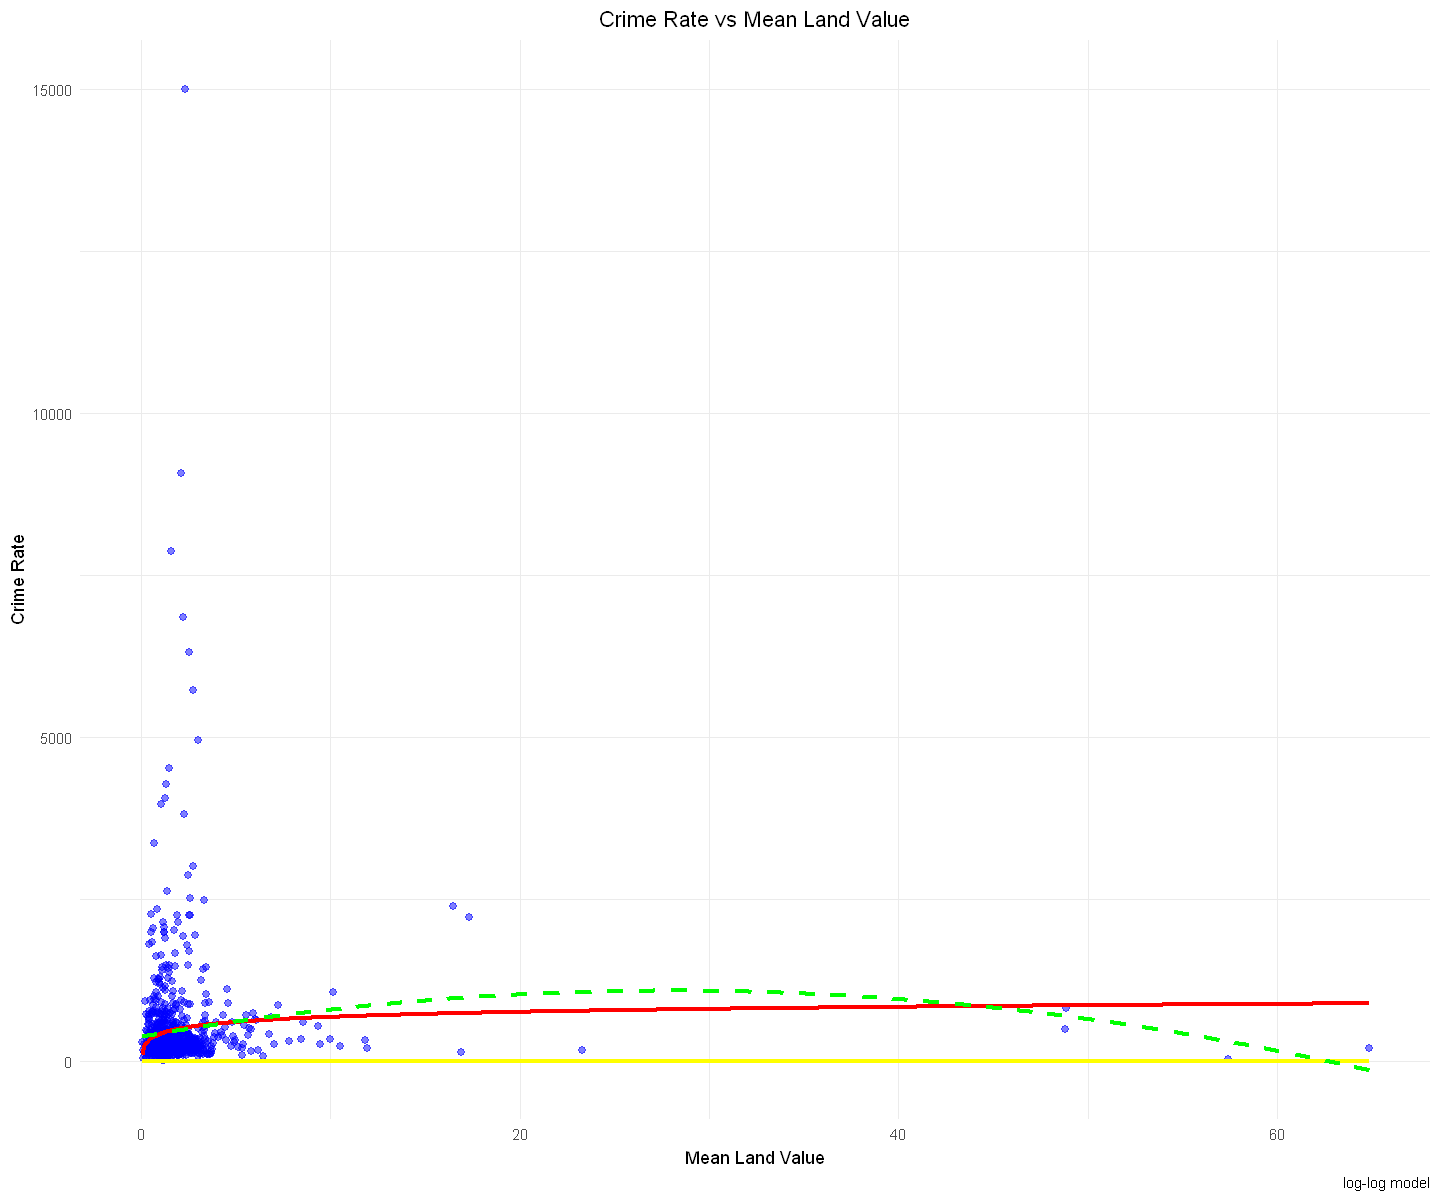

In [35]:
reg_log <- lm(log(crime_rate) ~ log(mean_land_value), data = census_index_crime)
census_index_crime$pred_reg4 <- predict(reg_log)

summary(reg_log)

# Predictions for smoother visualization
smooth_data <- data.frame(
  mean_land_value = land_value_seq,
    pred_reg2 = predict(reg2, newdata = data.frame(mean_land_value = land_value_seq)),
  pred_reg3 = predict(reg3, newdata = data.frame(mean_land_value = land_value_seq)),
  pred_reg4 = predict(reg_log, newdata = data.frame(mean_land_value = land_value_seq))
)

# Plot observed data and regression lines
ggplot(census_index_crime, aes(x = mean_land_value, y = crime_rate)) +
  geom_point(alpha = 0.5, color = "blue", size = 2) + # Data points
  geom_line(data = smooth_data, aes(x = mean_land_value, y = pred_reg4), color = "yellow", size = 1.2) + # reg_log line
  geom_line(data = smooth_data, aes(x = mean_land_value, y = pred_reg2), color = "red", size = 1.2) + # reg2 line
  geom_line(data = smooth_data, aes(x = mean_land_value, y = pred_reg3), color = "green", size = 1.2, linetype = "dashed") + # reg3 line
  labs(
    title = "Crime Rate vs Mean Land Value",
    x = "Mean Land Value",
    y = "Crime Rate",
    caption = "log-log model"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))



Call:
lm(formula = log(crime_rate) ~ log(mean_land_value), data = census_index_crime)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0182 -0.4950 -0.0926  0.3789  3.8690 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           5.63804    0.02848 197.951  < 2e-16 ***
log(mean_land_value)  0.12731    0.03736   3.408 0.000682 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8122 on 987 degrees of freedom
Multiple R-squared:  0.01163,	Adjusted R-squared:  0.01063 
F-statistic: 11.61 on 1 and 987 DF,  p-value: 0.000682



Call:
lm(formula = crime_rate ~ mean_land_value + I(mean_land_value^2), 
    data = census_index_crime)

Residuals:
    Min      1Q  Median      3Q     Max 
 -904.9  -275.5  -185.7   -30.7 14507.3 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          378.5689    40.8823   9.260  < 2e-16 ***
mean_land_value       50.7005    19.0317   2.664  0.00785 ** 
I(mean_land_value^2)  -0.9054     0.3599  -2.516  0.01203 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 839.8 on 986 degrees of freedom
Multiple R-squared:  0.007157,	Adjusted R-squared:  0.005144 
F-statistic: 3.554 on 2 and 986 DF,  p-value: 0.02898


Warning message in log(pred_reg3):
"NaNs produced"
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_line()`)."


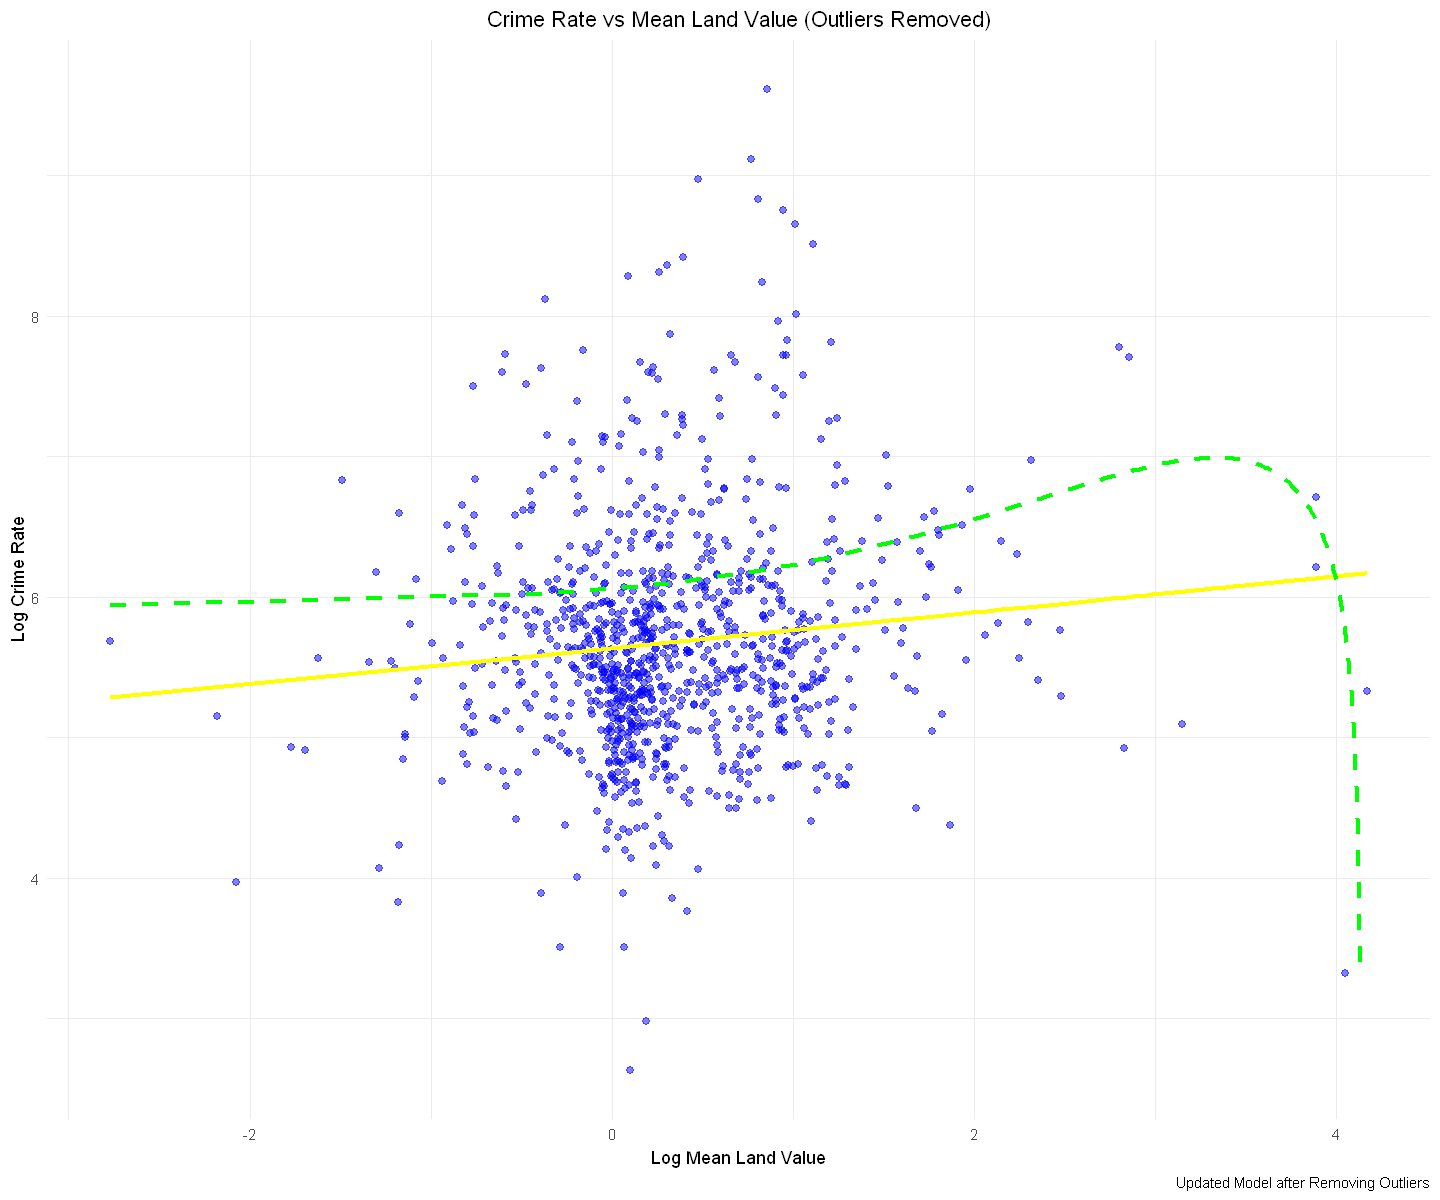

In [36]:
# census_index_crime <- census_index_crime %>%
#   arrange(desc(mean_land_value)) %>% 
#   slice(-1:-4)                     


reg_log <- lm(log(crime_rate) ~ log(mean_land_value), data = census_index_crime)
reg2 <- lm(crime_rate ~ log(mean_land_value), data = census_index_crime)
reg3 <- lm(crime_rate ~ mean_land_value + I(mean_land_value^2), data = census_index_crime)

census_index_crime$pred_reg4 <- predict(reg_log)

summary(reg_log)
summary(reg3)

land_value_seq <- seq(min(census_index_crime$mean_land_value), 
                      max(census_index_crime$mean_land_value), length.out = 100)

smooth_data <- data.frame(
  mean_land_value = land_value_seq,
  pred_reg2 = predict(reg2, newdata = data.frame(mean_land_value = land_value_seq)),
  pred_reg3 = predict(reg3, newdata = data.frame(mean_land_value = land_value_seq)),
  pred_reg4 = predict(reg_log, newdata = data.frame(mean_land_value = land_value_seq))
)

ggplot(census_index_crime, aes(x = log(mean_land_value), y = log(crime_rate))) +
  geom_point(alpha = 0.5, color = "blue", size = 2) + 
  geom_line(data = smooth_data, aes(x = log(mean_land_value), y = pred_reg4), color = "yellow", size = 1.2) + # reg_log line
  geom_line(data = smooth_data, aes(x = log(mean_land_value), y = log(pred_reg3)), color = "green", size = 1.2, linetype = "dashed") + # reg3 line
  labs(
    title = "Crime Rate vs Mean Land Value (Outliers Removed)",
    x = "Log Mean Land Value",
    y = "Log Crime Rate",
    caption = "Updated Model after Removing Outliers"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))


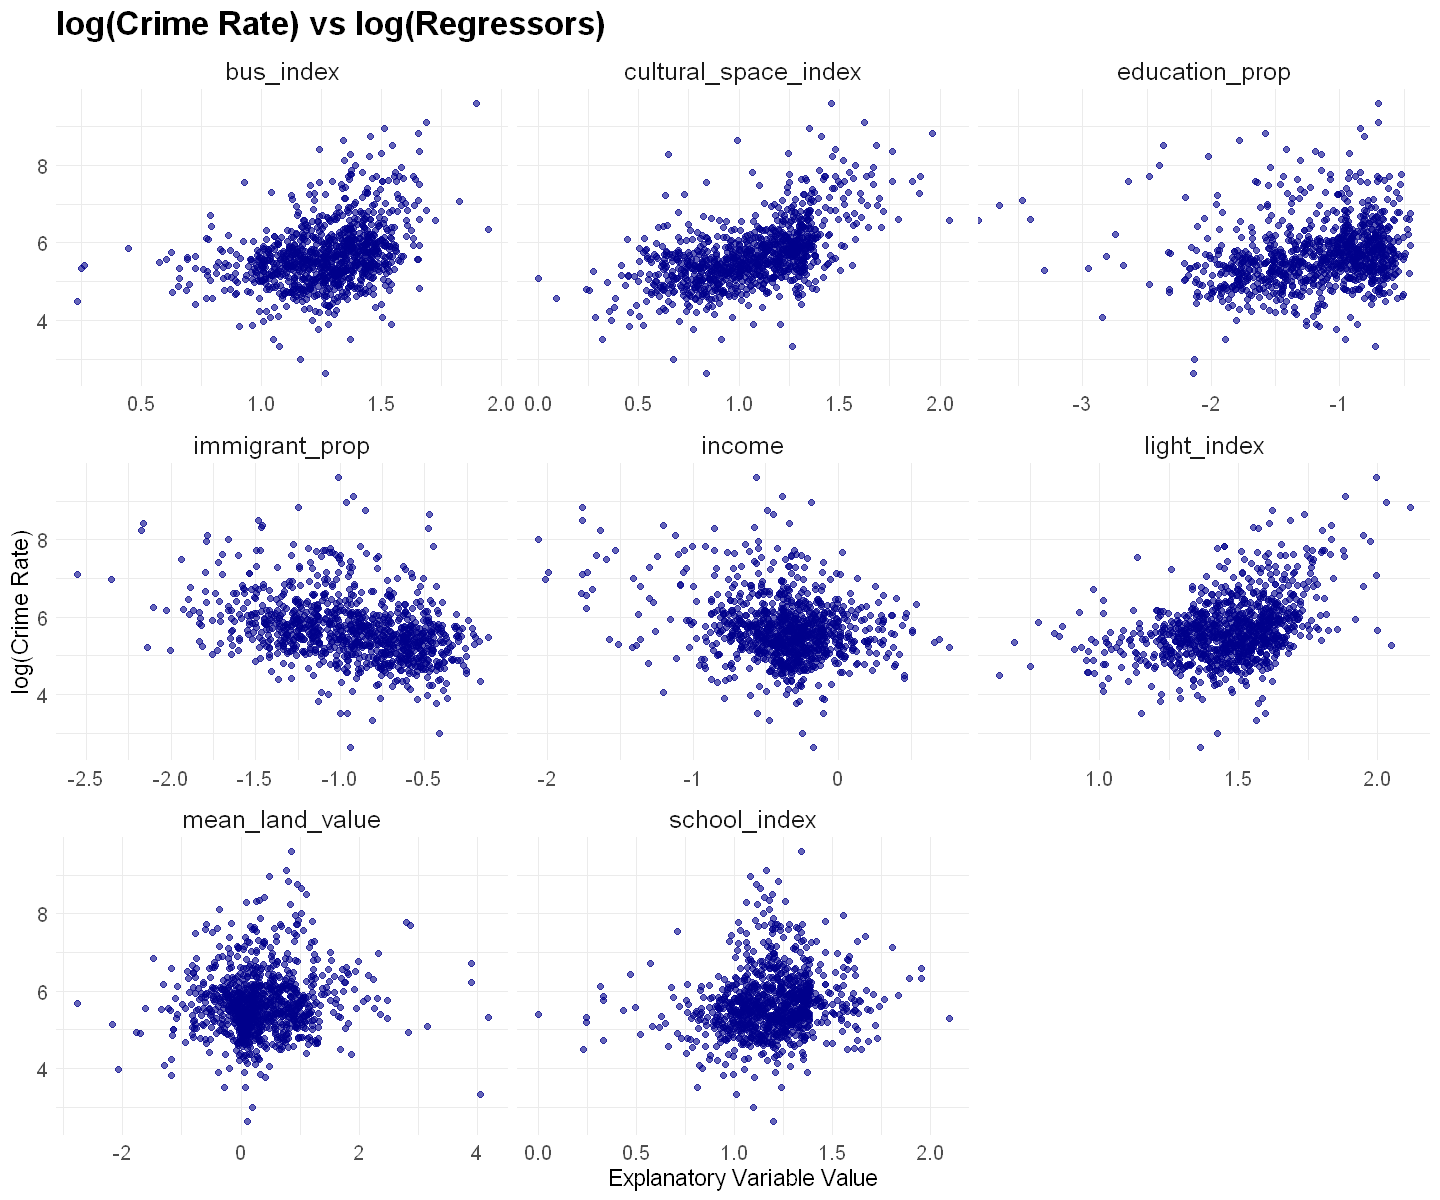

In [37]:
regressors <- c('mean_land_value','school_index', 'light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')

long_data <- census_index_crime |>
  pivot_longer(cols = regressors,
               names_to = "regressor",
               values_to = "value")

log_log_variables_scatter <- ggplot(long_data, aes(x = log(value), y = log(crime_rate))) +
  geom_point(color = "darkblue", alpha = 0.6) +
  facet_wrap(~ regressor, scales = "free_x") + 
  labs(title = "log(Crime Rate) vs log(Regressors)",
       x = "Explanatory Variable Value",
       y = "log(Crime Rate)") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        strip.text = element_text(size = 15),  
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

log_log_variables_scatter

In [38]:
# Identify variables with zeros
zero_counts <- sapply(census_index_crime, function(x) {
  if (is.numeric(x)) {
    sum(x == 0, na.rm = TRUE)
  } else {
    NA
  }
})
print("Variables with zero counts:")
print(zero_counts)

[1] "Variables with zero counts:"
                name           households            dwellings 
                  NA                    0                    0 
          population   population_density               region 
                   0                    0                   NA 
          area_sq_km                  age               income 
                   0                    0                    0 
      immigrant_prop       education_prop         school_index 
                   0                    1                    0 
         light_index            bus_index cultural_space_index 
                   0                    0                    0 
         crime_count           crime_rate      mean_land_value 
                   0                    0                    0 
            geometry            pred_reg2            pred_reg3 
                  NA                    0                    0 
           pred_reg4 
                   0 


In [39]:
min_positive_value_school <- min(census_index_crime$school_index[census_index_crime$school_index > 0], na.rm = TRUE)
min_positive_value_cultural_space <- min(census_index_crime$cultural_space_index[census_index_crime$cultural_space_index  > 0], na.rm = TRUE)

In [40]:
# Replace 0 with a small constant for log_cultural_space_index and remove log transformation for immigrant_prop and education_prop
census_index_crime_log <- census_index_crime %>% 
  mutate(
    log_crime_rate = log(crime_rate),
    log_mean_land_value = log(mean_land_value),
    log_school_index = log(ifelse(school_index == 0, min_positive_value_school/2, school_index)),
    log_light_index = log(light_index),
    log_bus_index = log(bus_index),
    log_cultural_space_index = log(ifelse(cultural_space_index == 0, min_positive_value_cultural_space/2, cultural_space_index)),
    log_income = log(income),
    immigrant_prop = immigrant_prop,  
    education_prop = education_prop 
  )

In [41]:
# Fit the log-log regression model (without log transformation for immigrant_prop and education_prop)
reg_log <- lm(log_crime_rate ~ log_mean_land_value + log_school_index + log_light_index + log_bus_index
                + log_cultural_space_index + log_income + 
                immigrant_prop + education_prop, 
              data = census_index_crime_log)

# Display summary of the model
summary(reg_log)

# Test for heteroskedasticity using the White test
white_test <- bptest(reg_log, ~ fitted(reg_log) + I(fitted(reg_log)^2), data = census_index_crime_log)
print(white_test)

# If heteroskedasticity is present, calculate robust standard errors
if (white_test$p.value < 0.05) {
  reg_log_robust <- coeftest(reg_log, vcov = vcovHC(reg_log, type = "HC1"))
  print("Heteroskedasticity detected. Using robust standard errors.")
  print(reg_log_robust)
} else {
  print("No significant heteroskedasticity detected.")
}
  # Use regular standard errors
  robust_se <- coef(summary(reg_log))[, "Std. Error"]

# Generate a regression table with stargazer
stargazer(reg_log, type = "text", 
          title = "Log-Log Regression Results", 
          dep.var.labels = c("Log Crime Rate"))

if (exists("reg_log_robust")) {
  stargazer(reg_log, type = "text", 
            title = "Log-Log Regression Results with Robust Errors", 
            dep.var.labels = c("Log Crime Rate"), 
            se = list(robust_se))
}


Call:
lm(formula = log_crime_rate ~ log_mean_land_value + log_school_index + 
    log_light_index + log_bus_index + log_cultural_space_index + 
    log_income + immigrant_prop + education_prop, data = census_index_crime_log)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6002 -0.3690 -0.0359  0.3427  2.7295 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               3.34420    0.20361  16.424  < 2e-16 ***
log_mean_land_value       0.17553    0.02966   5.918 4.50e-09 ***
log_school_index         -0.87999    0.13374  -6.580 7.65e-11 ***
log_light_index           1.50619    0.20733   7.265 7.62e-13 ***
log_bus_index             0.04377    0.18652   0.235 0.814535    
log_cultural_space_index  0.95612    0.13223   7.231 9.65e-13 ***
log_income               -0.35317    0.06748  -5.234 2.03e-07 ***
immigrant_prop           -0.62843    0.17075  -3.680 0.000245 ***
education_prop            0.52633    0.19469   2.703 0.006981 ** 
---
S


	studentized Breusch-Pagan test

data:  reg_log
BP = 39.234, df = 2, p-value = 3.024e-09

[1] "Heteroskedasticity detected. Using robust standard errors."

t test of coefficients:

                          Estimate Std. Error t value  Pr(>|t|)    
(Intercept)               3.344201   0.227806 14.6800 < 2.2e-16 ***
log_mean_land_value       0.175532   0.042072  4.1722 3.284e-05 ***
log_school_index         -0.879994   0.158724 -5.5442 3.797e-08 ***
log_light_index           1.506190   0.260227  5.7880 9.583e-09 ***
log_bus_index             0.043765   0.201921  0.2167 0.8284528    
log_cultural_space_index  0.956119   0.148798  6.4256 2.046e-10 ***
log_income               -0.353165   0.069485 -5.0826 4.457e-07 ***
immigrant_prop           -0.628427   0.173923 -3.6132 0.0003178 ***
education_prop            0.526331   0.211768  2.4854 0.0131061 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Log-Log Regression Results
                             Dependent var

In [42]:
vif(reg_log)|>
    tidy()

Warning message in tidy.numeric(vif(reg_log)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_mean_land_value,1.050700
log_school_index,2.139997
log_light_index,3.758177
log_bus_index,3.719139
log_cultural_space_index,3.524285
log_income,1.466573
immigrant_prop,1.638605
education_prop,1.716030


In [43]:
# Fit the log-log regression model (without log transformation for immigrant_prop and education_prop)
reg_log2 <- lm(log_crime_rate ~ log_mean_land_value + log_school_index + log_light_index + 
                log_cultural_space_index + log_income + 
                immigrant_prop + education_prop, 
              data = census_index_crime_log)

# Display summary of the model
summary(reg_log2)

# Test for heteroskedasticity using the White test
white_test <- bptest(reg_log2, ~ fitted(reg_log2) + I(fitted(reg_log2)^2), data = census_index_crime_log)
print(white_test)

# If heteroskedasticity is present, calculate robust standard errors
if (white_test$p.value < 0.05) {
  reg_log_robust2 <- coeftest(reg_log2, vcov = vcovHC(reg_log2, type = "HC1"))
  print("Heteroskedasticity detected. Using robust standard errors.")
  print(reg_log_robust2)
  
  # Extract robust standard errors
  robust_se2 <- sqrt(diag(vcovHC(reg_log2, type = "HC1")))
} else {
  print("No significant heteroskedasticity detected.")
  
  # Use regular standard errors
  robust_se2 <- coef(summary(reg_log2))[, "Std. Error"]
}

# Generate a regression table with stargazer
stargazer(reg_log2, type = "text", 
          title = "Log-Log Regression Results", 
          dep.var.labels = c("Log Crime Rate"),
          ci=FALSE, 
          single.row=TRUE)

# Add robust standard errors if heteroskedasticity was detected
if (white_test$p.value < 0.05) {
  stargazer(reg_log2, type = "text", 
            title = "Log-Log Regression Results with Robust Standard Errors", 
            dep.var.labels = c("Log Crime Rate"), 
            se = list(robust_se2),
            ci=FALSE, 
            single.row=TRUE)
}


Call:
lm(formula = log_crime_rate ~ log_mean_land_value + log_school_index + 
    log_light_index + log_cultural_space_index + log_income + 
    immigrant_prop + education_prop, data = census_index_crime_log)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6071 -0.3701 -0.0357  0.3430  2.7327 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               3.34361    0.20350  16.431  < 2e-16 ***
log_mean_land_value       0.17457    0.02936   5.945 3.83e-09 ***
log_school_index         -0.87042    0.12729  -6.838 1.41e-11 ***
log_light_index           1.53253    0.17423   8.796  < 2e-16 ***
log_cultural_space_index  0.96084    0.13062   7.356 4.00e-13 ***
log_income               -0.35568    0.06659  -5.342 1.15e-07 ***
immigrant_prop           -0.62714    0.17057  -3.677 0.000249 ***
education_prop            0.52589    0.19458   2.703 0.006998 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard e


	studentized Breusch-Pagan test

data:  reg_log2
BP = 39.082, df = 2, p-value = 3.262e-09

[1] "Heteroskedasticity detected. Using robust standard errors."

t test of coefficients:

                          Estimate Std. Error t value  Pr(>|t|)    
(Intercept)               3.343614   0.227892 14.6719 < 2.2e-16 ***
log_mean_land_value       0.174573   0.042363  4.1209 4.093e-05 ***
log_school_index         -0.870417   0.155474 -5.5985 2.806e-08 ***
log_light_index           1.532531   0.229616  6.6743 4.148e-11 ***
log_cultural_space_index  0.960844   0.145068  6.6234 5.775e-11 ***
log_income               -0.355684   0.070201 -5.0667 4.836e-07 ***
immigrant_prop           -0.627142   0.173835 -3.6077 0.0003245 ***
education_prop            0.525890   0.211478  2.4867 0.0130574 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Log-Log Regression Results
                             Dependent variable:    
                         ---------------------------
   

In [44]:
stargazer(reg_log, reg_log2, type = "text", 
        title = "Log-Log Regression Results with Robust Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se,robust_se2))


Log-Log Regression Results with Robust Errors
                                       Dependent variable:              
                         -----------------------------------------------
                                         Log Crime Rate                 
                                   (1)                     (2)          
------------------------------------------------------------------------
log_mean_land_value             0.176***                0.175***        
                                 (0.030)                 (0.042)        
                                                                        
log_school_index                -0.880***               -0.870***       
                                 (0.134)                 (0.155)        
                                                                        
log_light_index                 1.506***                1.533***        
                                 (0.207)                 (0.230)        
    

In [45]:
 stargazer(reg_log2, type = "text", 
            title = "Log-Log Regression Results with Robust Errors", 
            dep.var.labels = c("Log Crime Rate"), 
            se = list(robust_se2))


Log-Log Regression Results with Robust Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_mean_land_value               0.175***          
                                   (0.042)          
                                                    
log_school_index                  -0.870***         
                                   (0.155)          
                                                    
log_light_index                   1.533***          
                                   (0.230)          
                                                    
log_cultural_space_index          0.961***          
                                   (0.145)          
                                                    
log_income                        -0.356***         
                                   (0.070)          

In [46]:
vif(reg_log2)|>
    tidy()

Warning message in tidy.numeric(vif(reg_log2)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_mean_land_value,1.030734
log_school_index,1.940639
log_light_index,2.656461
log_cultural_space_index,3.442545
log_income,1.429481
immigrant_prop,1.636919
education_prop,1.715870


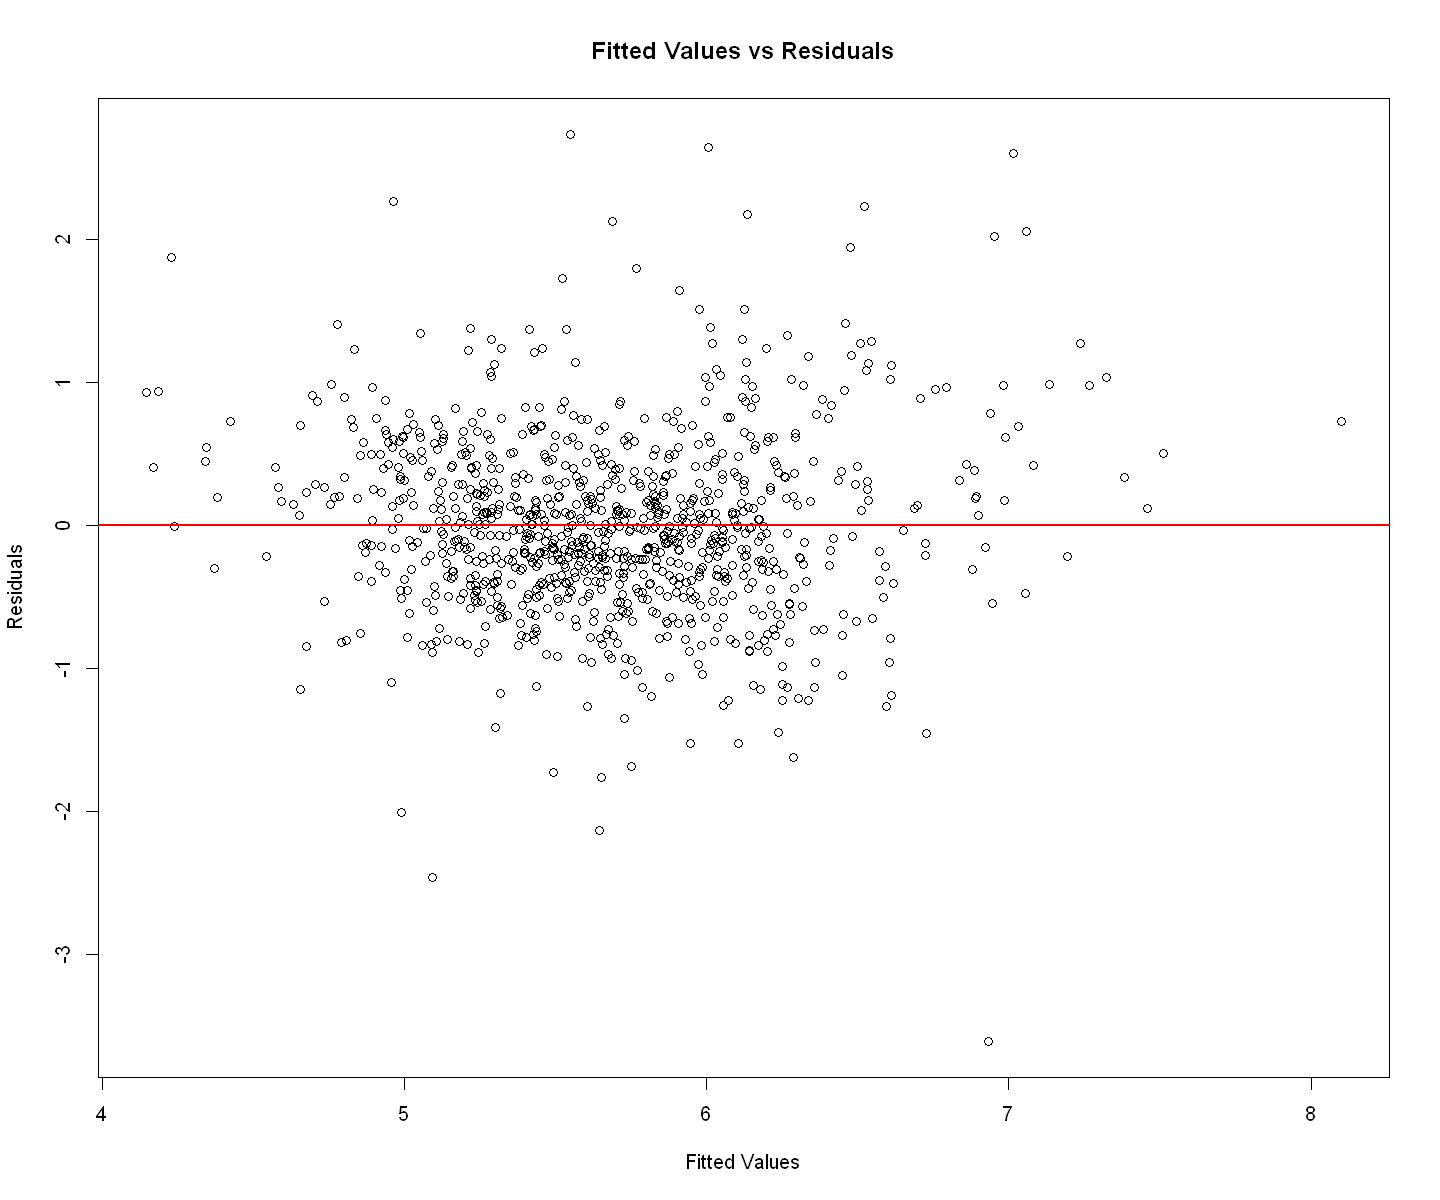

In [47]:
# Plot fitted values vs residuals
plot(fitted(reg_log2), residuals(reg_log2), 
     xlab = "Fitted Values", ylab = "Residuals",
     main = "Fitted Values vs Residuals")

# Add a horizontal line at 0 to assess heteroskedasticity
abline(h = 0, col = "red", lwd = 2)


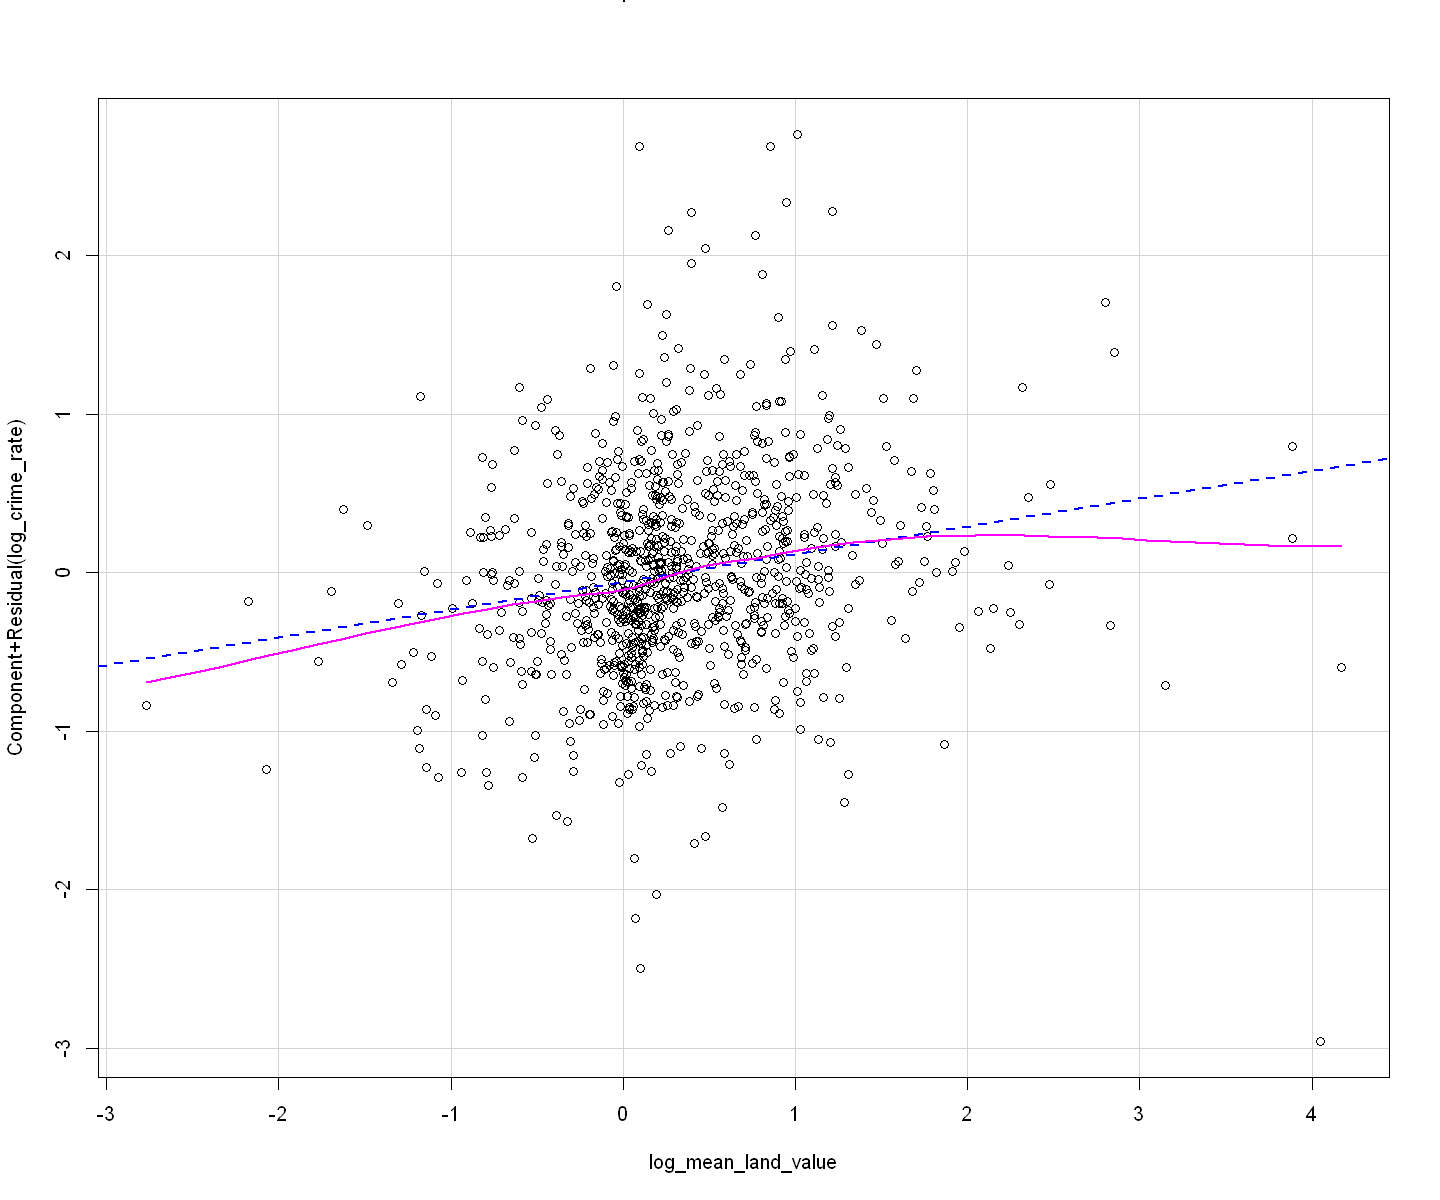

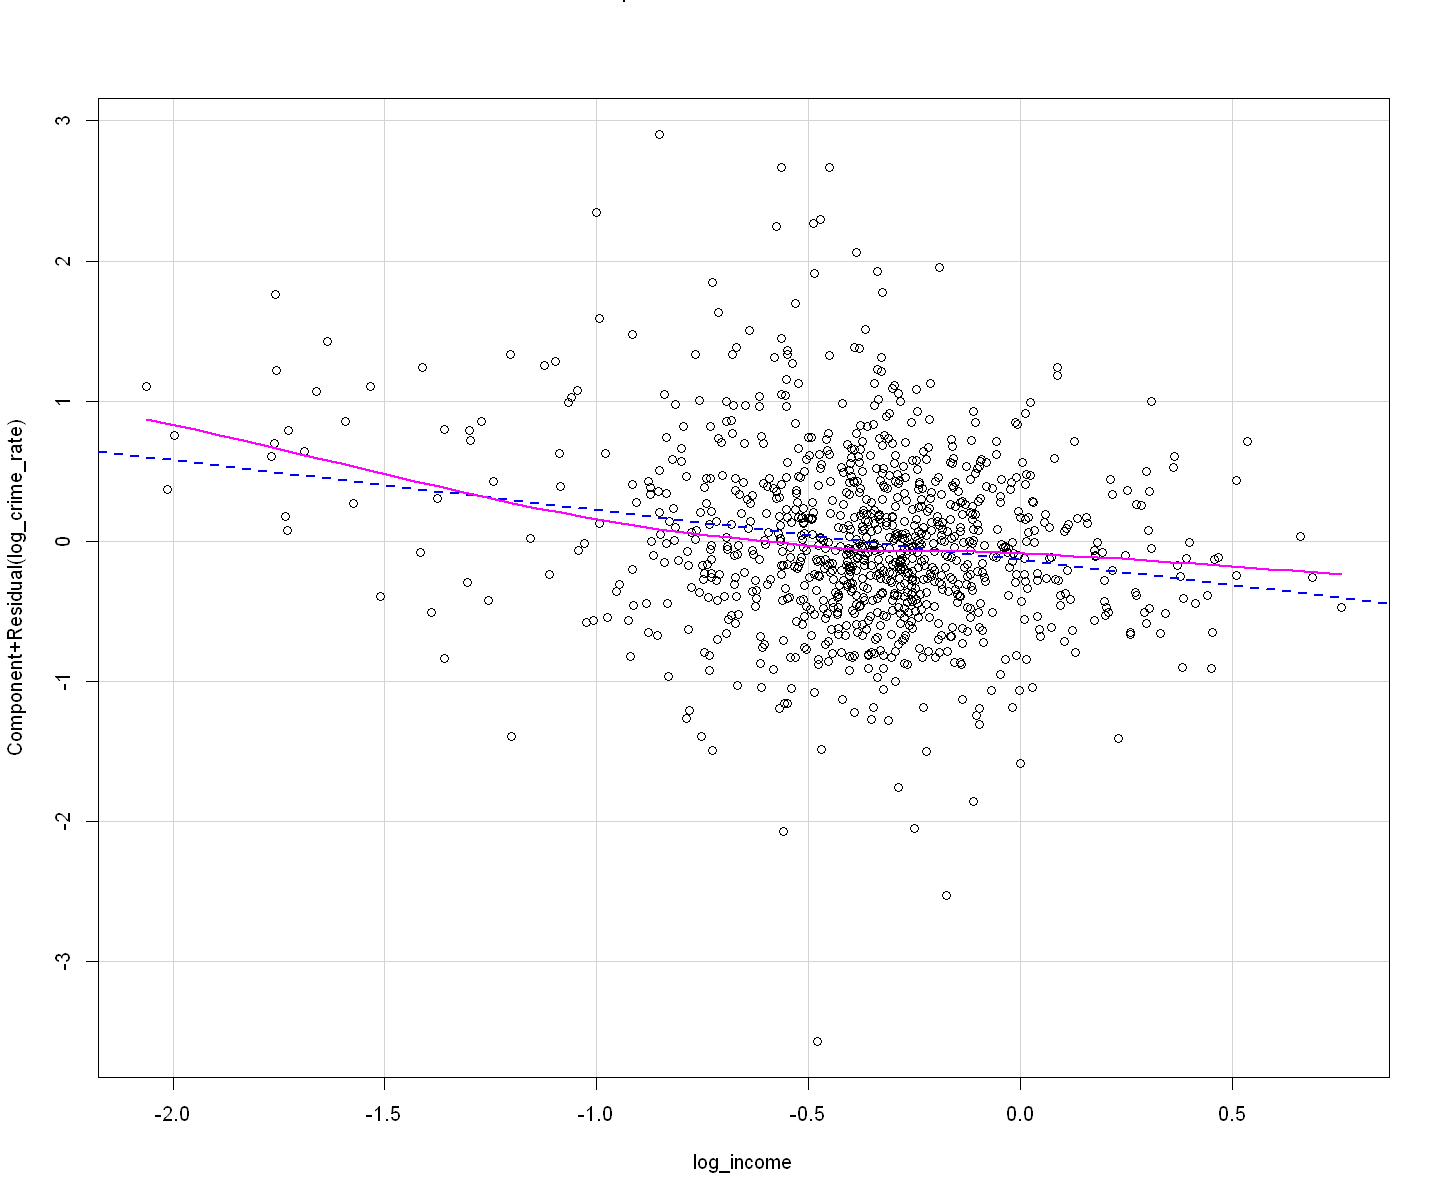

In [48]:
# Partial regression plot for log_mean_land_value
crPlots(reg_log2, terms = ~ log_mean_land_value)

# Partial regression plot for log_income
crPlots(reg_log2, terms = ~ log_income)

In [49]:
library(VancouvR)

Warning message:
"package 'VancouvR' was built under R version 4.4.2"


In [50]:
local_area_boundary <- get_cov_data("local-area-boundary")|>
    st_sf()

glimpse(local_area_boundary)

Rows: 22
Columns: 4
$ name         <chr> "Downtown", "Hastings-Sunrise", "Kerrisdale", "Marpole", …
$ geom         <chr> "{\"coordinates\": [[[-123.11226654052733, 49.29016494657…
$ geo_point_2d <chr> "49.28074707013743, -123.11656700827415", "49.27793405209…
$ geometry     <POLYGON [°]> POLYGON ((-123.1123 49.2901..., POLYGON ((-123.05…


In [51]:
census_index_crime_log_st <- st_sf(census_index_crime_log)
# Step 1: Fix invalid geometries using st_make_valid()
census_index_crime_log_st_valid <- st_make_valid(census_index_crime_log_st)
local_area_boundary_valid <- st_make_valid(local_area_boundary)

# Step 2: Filter local_area_boundary to include only "West End" and "Downtown"
selected_areas <- local_area_boundary_valid %>%
  filter(name %in% c("West End", "Downtown"))

# Optional: Simplify geometries if needed (helps in performance and resolves minor geometry issues)
# Adjust dTolerance as appropriate for your spatial resolution
census_index_crime_log_st_valid <- st_simplify(census_index_crime_log_st_valid, dTolerance = 0.01)
selected_areas <- st_simplify(selected_areas, dTolerance = 0.01)

# Step 3: Ensure both datasets use the same Coordinate Reference System (CRS)
desired_crs <- st_crs(selected_areas)
census_index_crime_log_st_valid <- st_transform(census_index_crime_log_st_valid, crs = desired_crs)

# Step 4: Perform spatial join to keep only records within "West End" and "Downtown"
census_index_crime_log_filtered <- st_join(
  census_index_crime_log_st_valid,
  selected_areas,
  join = st_within,
  left = FALSE
)

# Step 5: Verify the resulting dataset
glimpse(census_index_crime_log_filtered)

problematic_geometries <- census_index_crime_log_st[!st_is_valid(census_index_crime_log_st), ]
if(nrow(problematic_geometries) > 0){
  print("Problematic Geometries:")
  print(problematic_geometries)
} else {
  print("No problematic geometries found.")
}

Rows: 96
Columns: 32
$ name.x                   <chr> "59150777", "59150779", "59150780", "59150782…
$ households               <int> 622, 589, 1461, 301, 400, 1325, 320, 205, 404…
$ dwellings                <int> 658, 652, 1596, 338, 442, 1431, 366, 236, 440…
$ population               <int> 1212, 987, 2306, 464, 642, 1895, 566, 488, 70…
$ population_density       <dbl> 77692.3, 59101.8, 34728.9, 28466.3, 37764.7, …
$ region                   <chr> "Vancouver", "Vancouver", "Vancouver", "Vanco…
$ area_sq_km               <dbl> 0.01556, 0.01673, 0.06649, 0.01626, 0.01699, …
$ age                      <int> 1210, 990, 2305, 465, 640, 1895, 570, 490, 70…
$ income                   <dbl> 0.74496, 0.80512, 0.67533, 0.67456, 0.33792, …
$ immigrant_prop           <dbl> 0.3589109, 0.3140831, 0.3057242, 0.4418103, 0…
$ education_prop           <dbl> 0.4702970, 0.5116515, 0.4856895, 0.4849138, 0…
$ school_index             <dbl> 3.447539, 3.401538, 3.333522, 3.250987, 3.323…
$ light_index      

In [52]:
distinct(census_index_crime_log_filtered,name.y)

name.y
<chr>
Downtown
West End


In [53]:
# Fit the log-log regression model (without log transformation for immigrant_prop and education_prop)
reg_log_dt <- lm(log_crime_rate ~ log_mean_land_value + log_school_index + log_light_index + 
                log_cultural_space_index + log_income + 
                immigrant_prop + education_prop, 
                data = census_index_crime_log_filtered)

# Display summary of the model
summary(reg_log_dt)

# Test for heteroskedasticity using the White test
white_test <- bptest(reg_log_dt, ~ fitted(reg_log_dt) + I(fitted(reg_log_dt)^2), data = census_index_crime_log_filtered)
print(white_test)

# Initialize variable to store standard errors
robust_se_dt <- NULL

# If heteroskedasticity is present, calculate robust standard errors
if (white_test$p.value < 0.05) {
  # Calculate robust variance-covariance matrix
  vcov_robust <- vcovHC(reg_log_dt, type = "HC1")
  
  # Extract variances from the diagonal
  variances <- diag(vcov_robust)
  
  # Check for negative variances
  if(any(variances < 0)){
    stop("Negative variances detected in the robust variance-covariance matrix. Please check the model specification.")
  }
  
  # Calculate robust standard errors
  robust_se_dt <- sqrt(variances)
  
  # Optionally, display the robust coefficients
  reg_log_robust_dt <- coeftest(reg_log_dt, vcov = vcov_robust)
  print("Heteroskedasticity detected. Using robust standard errors.")
  print(reg_log_robust_dt)
} else {
  print("No significant heteroskedasticity detected.")
  # Use regular standard errors
  robust_se_dt <- coef(summary(reg_log_dt))[, "Std. Error"]
}

# Generate a regression table with stargazer
if (!is.null(robust_se_dt)) {
  stargazer(reg_log_dt, type = "text", 
            title = "Log-Log Regression Results", 
            dep.var.labels = c("Log Crime Rate"),
            se = list(robust_se_dt),
            ci = FALSE, 
            single.row = TRUE)
} else {
  # If robust_se_dt is NULL, display the standard model without robust SEs
  stargazer(reg_log_dt, type = "text", 
            title = "Log-Log Regression Results", 
            dep.var.labels = c("Log Crime Rate"),
            ci = FALSE, 
            single.row = TRUE)
}


Call:
lm(formula = log_crime_rate ~ log_mean_land_value + log_school_index + 
    log_light_index + log_cultural_space_index + log_income + 
    immigrant_prop + education_prop, data = census_index_crime_log_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2535 -0.4596  0.0213  0.4734  1.7066 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)   
(Intercept)               2.09453    1.30553   1.604  0.11222   
log_mean_land_value       0.09080    0.08131   1.117  0.26714   
log_school_index         -1.73519    1.02174  -1.698  0.09299 . 
log_light_index           2.20322    0.67514   3.263  0.00157 **
log_cultural_space_index  2.20662    0.81881   2.695  0.00843 **
log_income               -0.50665    0.35930  -1.410  0.16203   
immigrant_prop            0.50948    0.99365   0.513  0.60942   
education_prop           -1.72322    1.18218  -1.458  0.14849   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard e


	studentized Breusch-Pagan test

data:  reg_log_dt
BP = 7.0951, df = 2, p-value = 0.02879

[1] "Heteroskedasticity detected. Using robust standard errors."

t test of coefficients:

                          Estimate Std. Error t value Pr(>|t|)  
(Intercept)               2.094529   1.267413  1.6526  0.10198  
log_mean_land_value       0.090802   0.152569  0.5952  0.55327  
log_school_index         -1.735185   1.109706 -1.5636  0.12149  
log_light_index           2.203222   0.989510  2.2266  0.02853 *
log_cultural_space_index  2.206623   0.979145  2.2536  0.02670 *
log_income               -0.506651   0.337187 -1.5026  0.13653  
immigrant_prop            0.509478   0.986328  0.5165  0.60677  
education_prop           -1.723218   1.182169 -1.4577  0.14849  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Log-Log Regression Results
                             Dependent variable:    
                         ---------------------------
                              

In [54]:
vif(reg_log_dt)|>
    tidy()

Warning message in tidy.numeric(vif(reg_log_dt)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_mean_land_value,1.227383
log_school_index,1.812273
log_light_index,2.341006
log_cultural_space_index,1.850063
log_income,2.141717
immigrant_prop,1.442053
education_prop,1.789167


In [55]:
stargazer(reg_log2, reg_log_dt, type = "text", 
        title = "Log-Log Regression Results with Robust Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se2,robust_se_dt),
        column.labels = c("Vancouver", "Downtown only"),
        single.row = TRUE)


Log-Log Regression Results with Robust Errors
                                      Dependent variable:             
                         ---------------------------------------------
                                        Log Crime Rate                
                                Vancouver            Downtown only    
                                   (1)                    (2)         
----------------------------------------------------------------------
log_mean_land_value         0.175*** (0.042)         0.091 (0.153)    
log_school_index            -0.870*** (0.155)       -1.735 (1.110)    
log_light_index             1.533*** (0.230)        2.203** (0.990)   
log_cultural_space_index    0.961*** (0.145)        2.207** (0.979)   
log_income                  -0.356*** (0.070)       -0.507 (0.337)    
immigrant_prop              -0.627*** (0.174)        0.509 (0.986)    
education_prop               0.526** (0.211)        -1.723 (1.182)    
Constant                    3.

We notice that in Downtown, there are some very different behaviours of our variables. So we want to see if the existence of Insite in the region will have significant impact on the crime rate.

In [56]:
# Add insite dummy
locations_df <- data.frame(
  id = 1:3,
  lon = c(-123.10129, -123.10555, -123.12074), 
  lat = c(49.28160, 49.28302, 49.27544)          
) # Source: Google Map

locations_sf <- st_as_sf(locations_df, coords = c("lon", "lat"), crs = 4326)

if (st_crs(census_index_crime_log_st) != st_crs(locations_sf)) {
  locations_sf <- st_transform(locations_sf, st_crs(census_index_crime_log_st))
}

valid_geometries <- st_is_valid(census_index_crime_log_st)

if (!all(valid_geometries)) {
  invalid_indices <- which(!valid_geometries)
  invalid_reasons <- st_is_valid(census_index_crime_log_st[invalid_indices, ], reason = TRUE)
  cat("Invalid geometries found. Reasons:\n")
  print(invalid_reasons)

  census_index_crime_log_st <- st_make_valid(census_index_crime_log_st)

  valid_geometries <- st_is_valid(census_index_crime_log_st)
  
  if (!all(valid_geometries)) {
    census_index_crime_log_st <- st_buffer(census_index_crime_log_st, dist = 0)
    valid_geometries <- st_is_valid(census_index_crime_log_st)
    
    if (!all(valid_geometries)) {
      stop("Some geometries are still invalid after attempting to fix them.")
    }
  }
}

contains_result <- st_contains(census_index_crime_log_st, locations_sf, sparse = FALSE)

census_index_crime_log_st$insite_dummy <- as.integer(apply(contains_result, 1, any))

head(census_index_crime_log_st$insite_dummy)

Invalid geometries found. Reasons:
[1] "Loop 0: Edge 8 is degenerate (duplicate vertex)"  
[2] "Loop 0: Edge 149 is degenerate (duplicate vertex)"


[1] 0 0 0 0 0 0

`geom_smooth()` using formula = 'y ~ x'


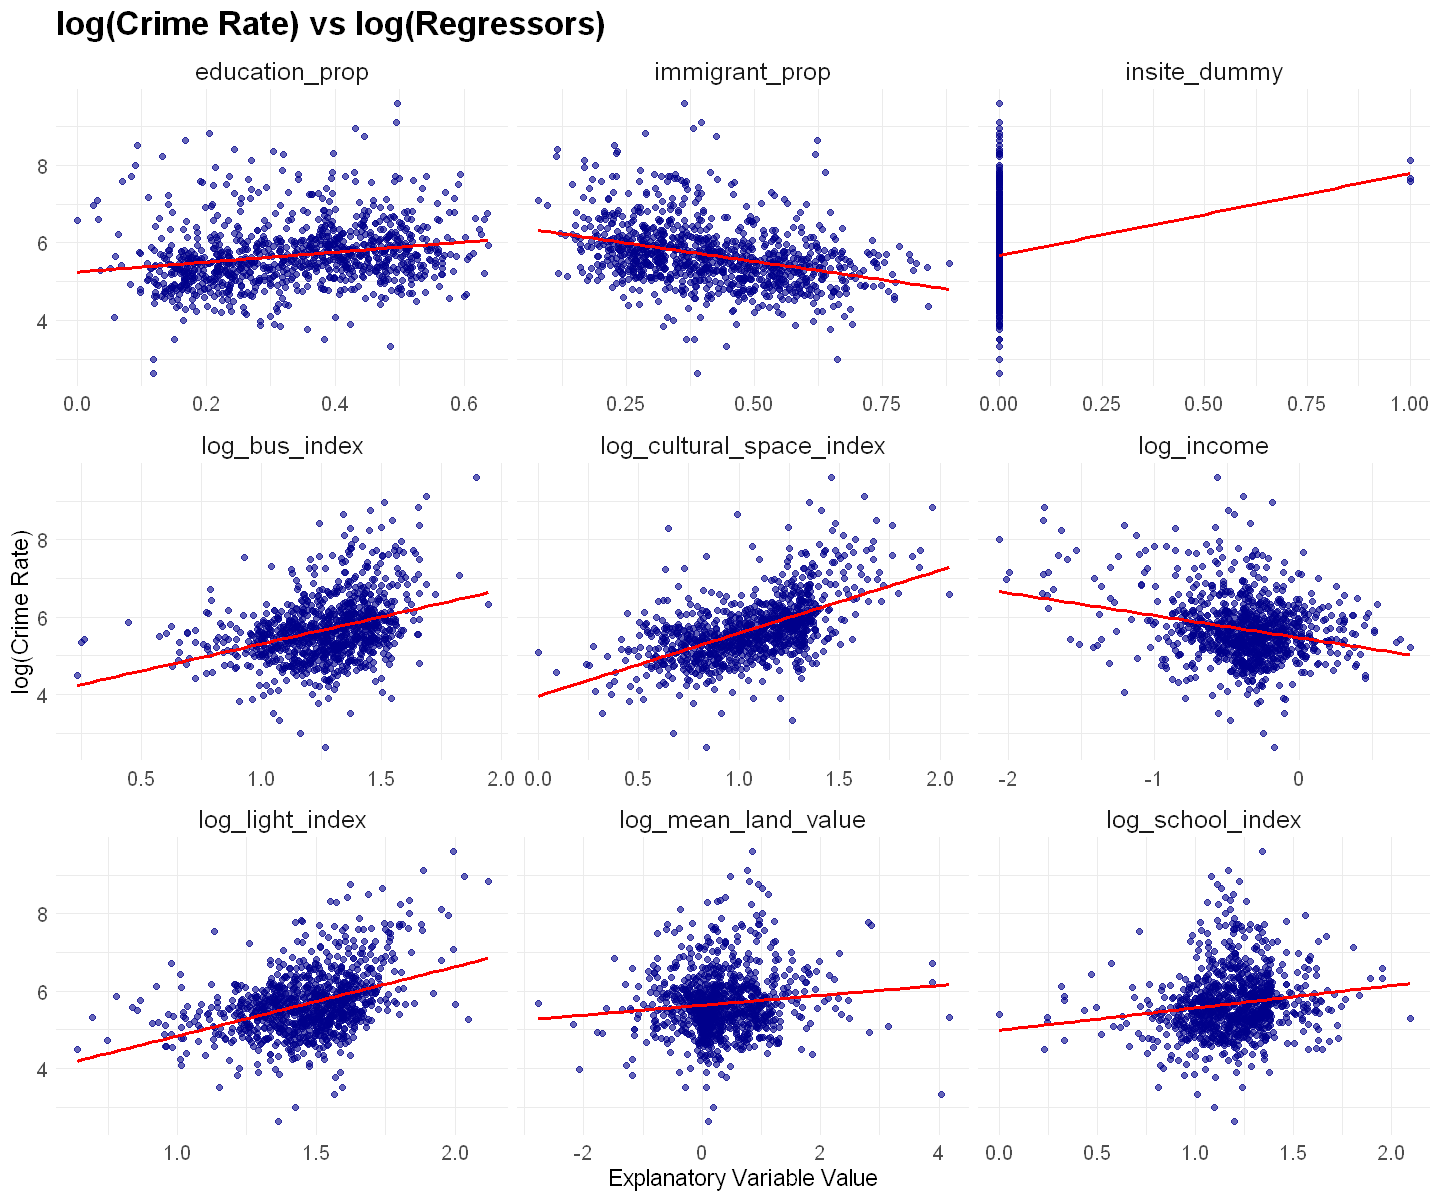

In [57]:
regressors <- c('log_mean_land_value','log_school_index', 'log_light_index', 'log_bus_index', 'log_cultural_space_index', 
                'log_income', 'immigrant_prop', 'education_prop','insite_dummy')

long_data <- census_index_crime_log_st |>
  pivot_longer(cols = regressors,
               names_to = "regressor",
               values_to = "value")

log_log_variables_scatter <- ggplot(long_data, aes(x = value, y = log_crime_rate)) +
  geom_point(color = "darkblue", alpha = 0.6) +
  facet_wrap(~ regressor, scales = "free_x") + 
  labs(title = "log(Crime Rate) vs log(Regressors)",
       x = "Explanatory Variable Value",
       y = "log(Crime Rate)") +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        strip.text = element_text(size = 15),  
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

log_log_variables_scatter

In [58]:
# Fit the log-log regression model (without log transformation for immigrant_prop and education_prop)
# For this model we add insite_dummy
reg_log3 <- lm(log_crime_rate ~  log_light_index + log_mean_land_value + log_school_index +
              log_cultural_space_index + log_income + immigrant_prop + education_prop + insite_dummy,  
              data = census_index_crime_log_st)

# Test for heteroskedasticity using the White test
white_test <- bptest(reg_log3, ~ fitted(reg_log3) + I(fitted(reg_log3)^2), data = census_index_crime_log)
print(white_test)

# If heteroskedasticity is present, calculate robust standard errors
if (white_test$p.value < 0.05) {
  reg_log_robust3 <- coeftest(reg_log3, vcov = vcovHC(reg_log3, type = "HC1"))
  print("Heteroskedasticity detected. Using robust standard errors.")
  print(reg_log_robust3)
  
  # Extract robust standard errors
  robust_se3 <- sqrt(diag(vcovHC(reg_log3, type = "HC1")))
} else {
  print("No significant heteroskedasticity detected.")
  
  # Use regular standard errors
  robust_se3 <- coef(summary(reg_log3))[, "Std. Error"]
}

# Generate a regression table with stargazer
stargazer(reg_log3, type = "text", 
          title = "Log-Log Regression Results", 
          dep.var.labels = c("Log Crime Rate"),
          ci=FALSE, 
          single.row=TRUE)

# Add robust standard errors if heteroskedasticity was detected
if (white_test$p.value < 0.05) {
  stargazer(reg_log3, type = "text", 
            title = "Log-Log Regression Results with Robust Standard Errors", 
            dep.var.labels = c("Log Crime Rate"), 
            se = list(robust_se3),
            single.row=TRUE)
}


	studentized Breusch-Pagan test

data:  reg_log3
BP = 28.772, df = 2, p-value = 5.653e-07

[1] "Heteroskedasticity detected. Using robust standard errors."

t test of coefficients:

                          Estimate Std. Error t value  Pr(>|t|)    
(Intercept)               3.359250   0.228330 14.7122 < 2.2e-16 ***
log_light_index           1.486730   0.231037  6.4350 1.928e-10 ***
log_mean_land_value       0.175177   0.042312  4.1401 3.770e-05 ***
log_school_index         -0.838403   0.156048 -5.3727 9.691e-08 ***
log_cultural_space_index  0.955265   0.144454  6.6129 6.184e-11 ***
log_income               -0.350491   0.069760 -5.0243 6.004e-07 ***
immigrant_prop           -0.604020   0.173493 -3.4815 0.0005206 ***
education_prop            0.551642   0.211563  2.6075 0.0092604 ** 
insite_dummy              0.941019   0.150789  6.2406 6.477e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Log-Log Regression Results
                             Dependent va

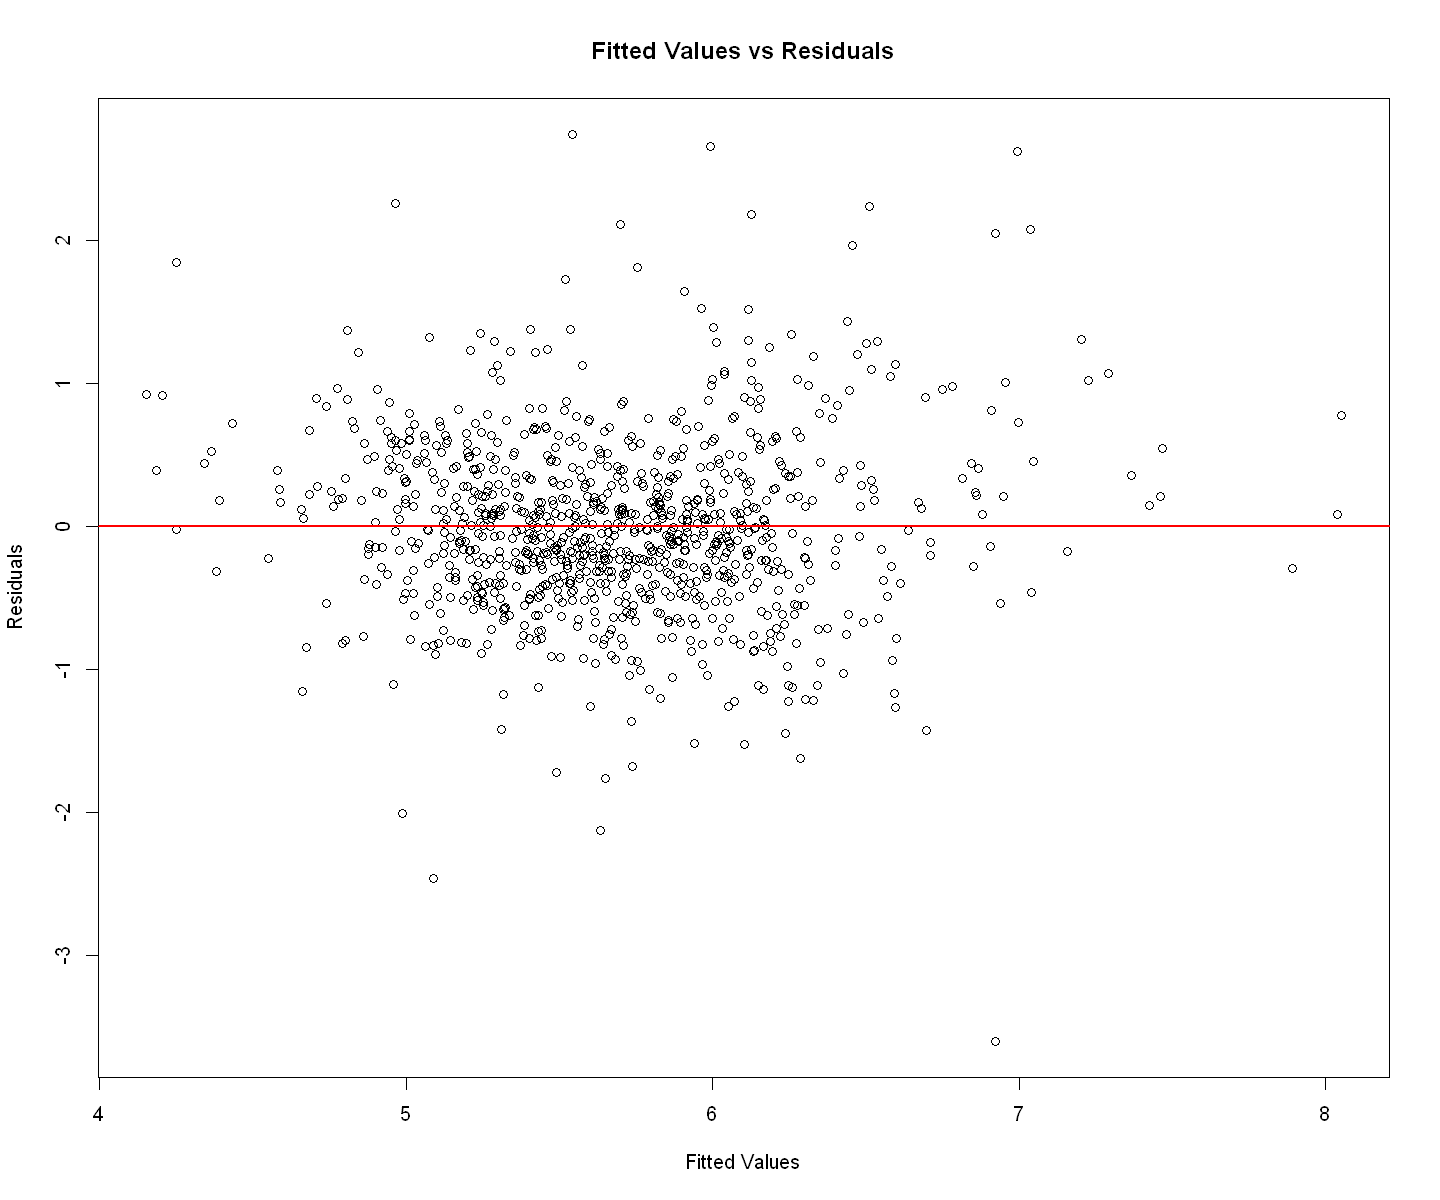

In [59]:
# Plot fitted values vs residuals
plot(fitted(reg_log3), residuals(reg_log3), 
     xlab = "Fitted Values", ylab = "Residuals",
     main = "Fitted Values vs Residuals")

# Add a horizontal line at 0 to assess heteroskedasticity
abline(h = 0, col = "red", lwd = 2)


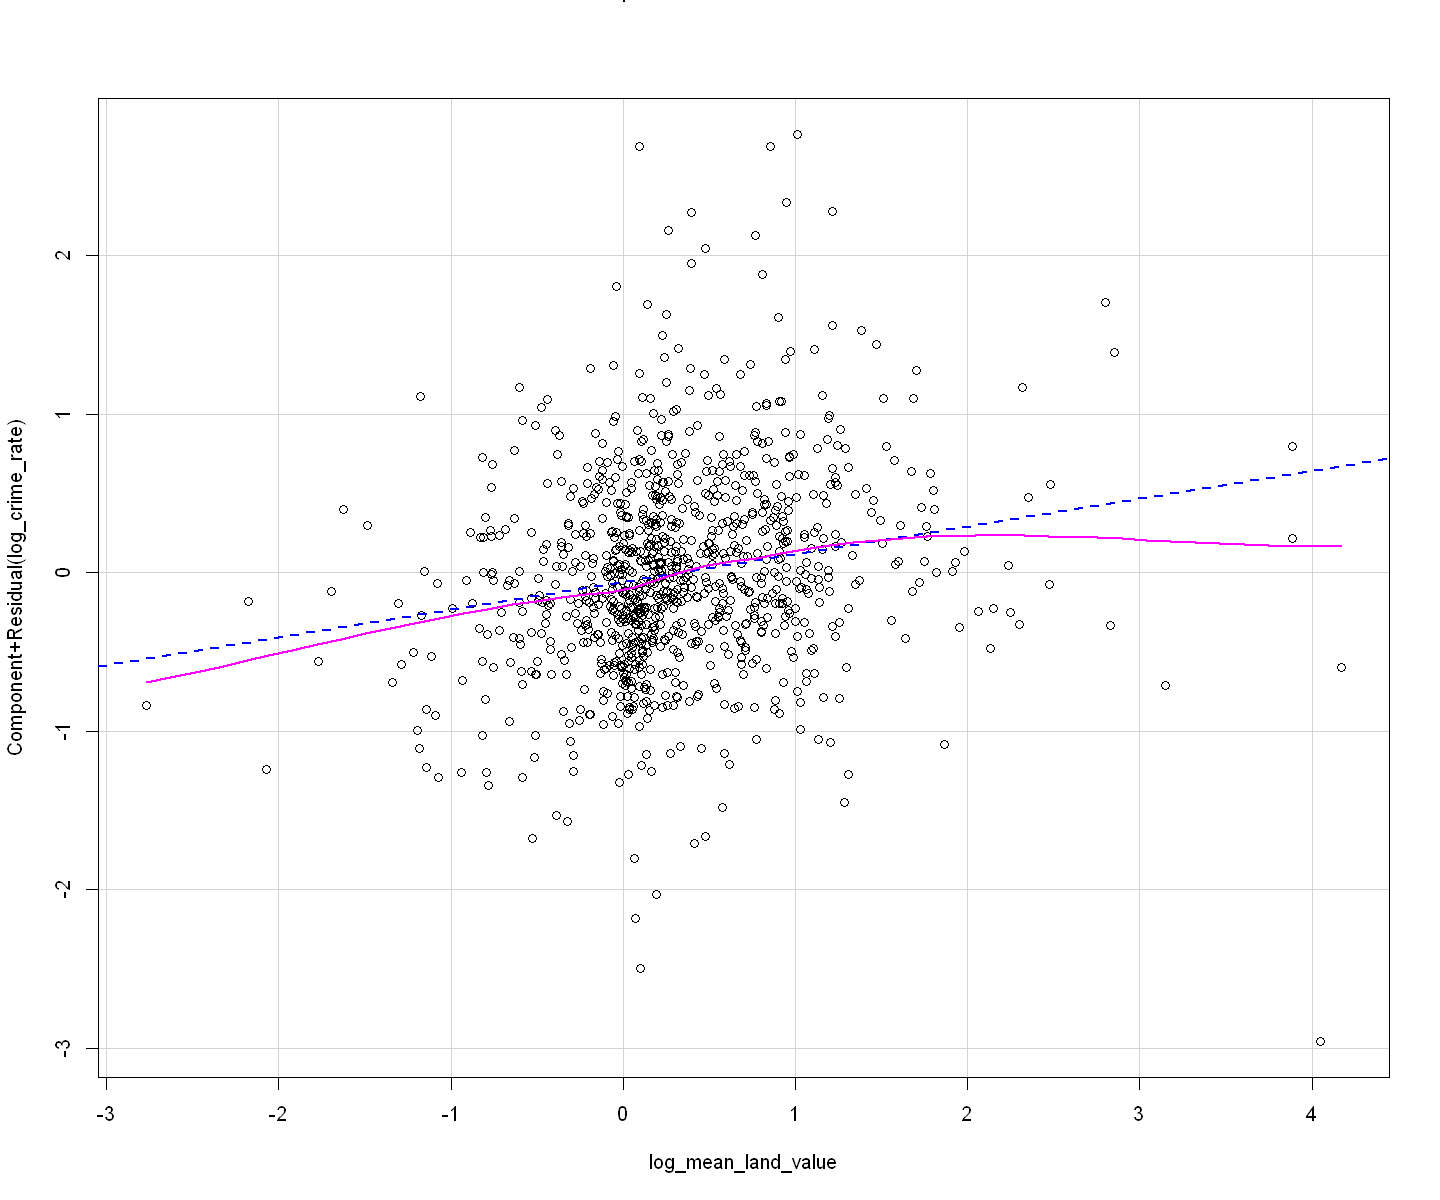

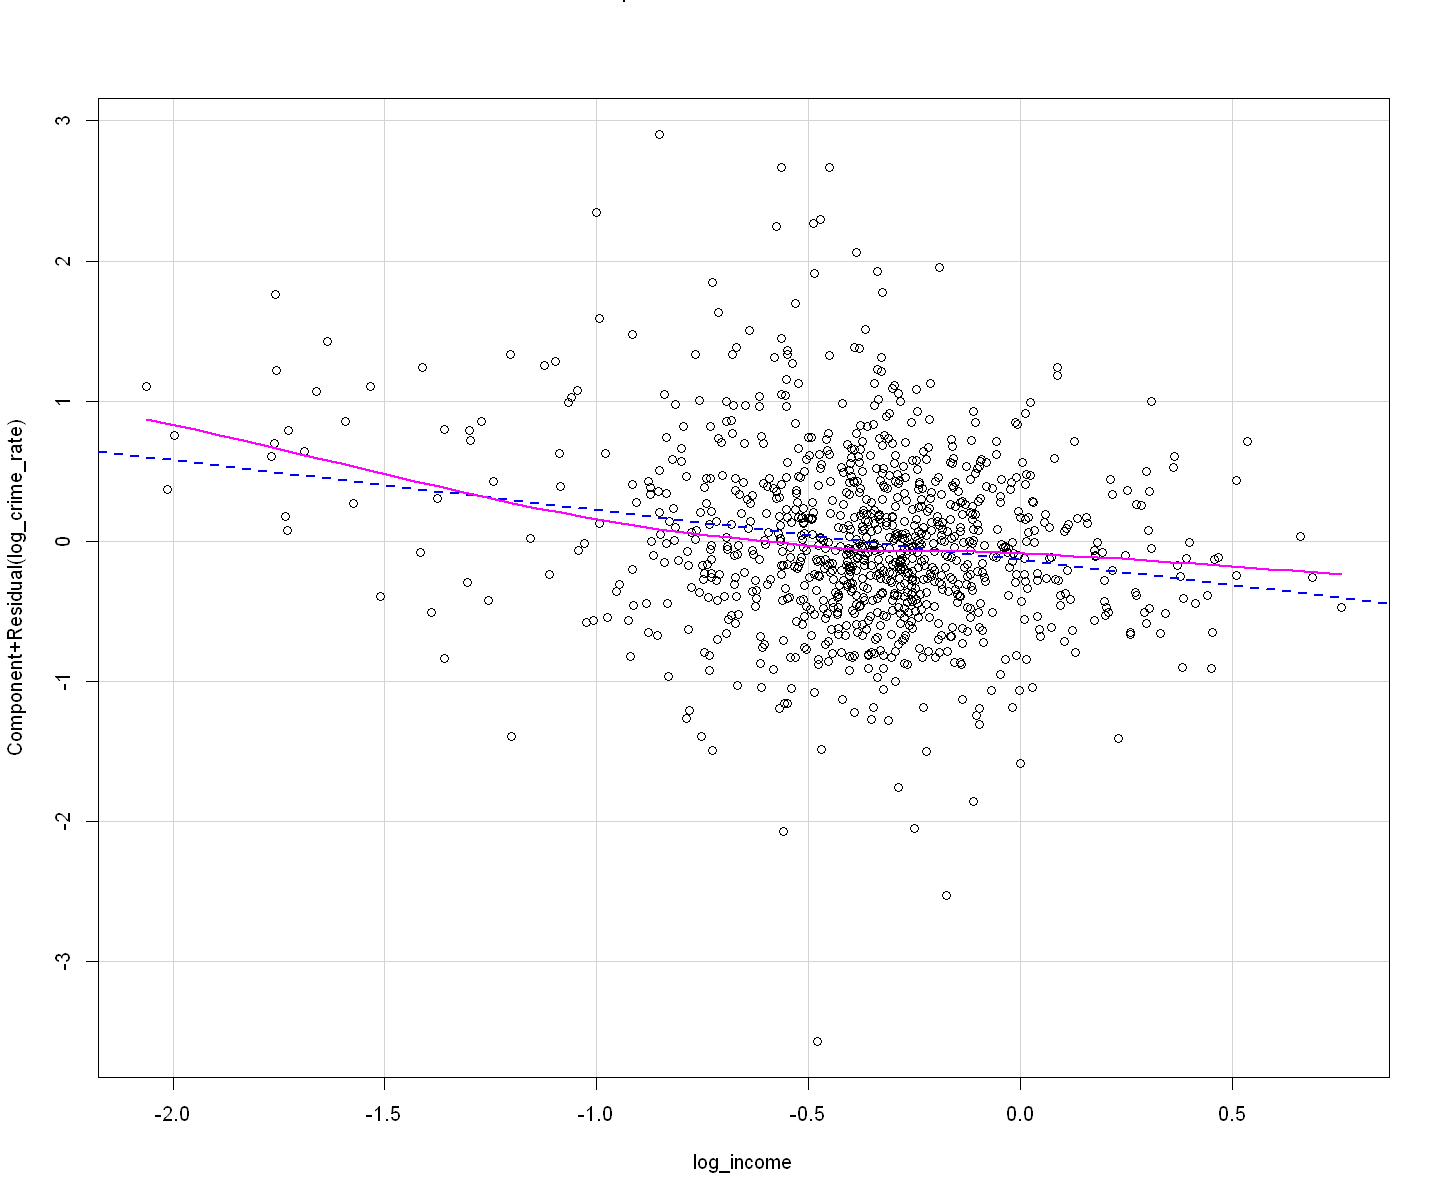

In [60]:
# Partial regression plot for log_mean_land_value
crPlots(reg_log2, terms = ~ log_mean_land_value)

# Partial regression plot for log_income
crPlots(reg_log2, terms = ~ log_income)

In [61]:
# Fit the log-log regression model (without log transformation for immigrant_prop and education_prop)
# For this model we create interaction terms of education_prop and immigrant_prop
reg_log4 <- lm(log_crime_rate ~ log_mean_land_value + log_school_index + log_light_index + log_cultural_space_index
               + log_income + immigrant_prop + education_prop + insite_dummy + immigrant_prop:education_prop,  
              data = census_index_crime_log_st)

# Test for heteroskedasticity using the White test
white_test <- bptest(reg_log4, ~ fitted(reg_log4) + I(fitted(reg_log4)^2), data = census_index_crime_log)
print(white_test)

# If heteroskedasticity is present, calculate robust standard errors
if (white_test$p.value < 0.05) {
  reg_log_robust4 <- coeftest(reg_log4, vcov = vcovHC(reg_log4, type = "HC1"))
  print("Heteroskedasticity detected. Using robust standard errors.")
  print(reg_log_robust4)
  
  # Extract robust standard errors
  robust_se4 <- sqrt(diag(vcovHC(reg_log4, type = "HC1")))
} else {
  print("No significant heteroskedasticity detected.")
  
  # Use regular standard errors
  robust_se4 <- coef(summary(reg_log4))[, "Std. Error"]
}

# Generate a regression table with stargazer
stargazer(reg_log4, type = "text", 
          title = "Log-Log Regression Results", 
          dep.var.labels = c("Log Crime Rate"),
          ci=FALSE, 
          single.row=TRUE)

# Add robust standard errors if heteroskedasticity was detected
if (white_test$p.value < 0.05) {
  stargazer(reg_log4, type = "text", 
            title = "Log-Log Regression Results with Robust Standard Errors", 
            dep.var.labels = c("Log Crime Rate"), 
            se = list(robust_se4),
            single.row=TRUE)}


	studentized Breusch-Pagan test

data:  reg_log4
BP = 26.392, df = 2, p-value = 1.858e-06

[1] "Heteroskedasticity detected. Using robust standard errors."

t test of coefficients:

                               Estimate Std. Error t value  Pr(>|t|)    
(Intercept)                    3.678450   0.293886 12.5166 < 2.2e-16 ***
log_mean_land_value            0.169975   0.042354  4.0132 6.447e-05 ***
log_school_index              -0.814257   0.156453 -5.2045 2.370e-07 ***
log_light_index                1.455732   0.233627  6.2310 6.874e-10 ***
log_cultural_space_index       0.953734   0.144492  6.6006 6.700e-11 ***
log_income                    -0.337442   0.069480 -4.8567 1.389e-06 ***
immigrant_prop                -1.278614   0.384646 -3.3241 0.0009198 ***
education_prop                -0.316664   0.497961 -0.6359 0.5249759    
insite_dummy                   0.899173   0.171403  5.2460 1.906e-07 ***
immigrant_prop:education_prop  2.113767   1.098655  1.9240 0.0546493 .  
---
Signif. co

In [62]:
  stargazer(reg_log2, reg_log3, reg_log4, type = "text", 
            title = "Log-Log Regression Results with Robust Standard Errors", 
            dep.var.labels = c("Log Crime Rate"), 
            se = list(robust_se2, robust_se3, robust_se4),
            single.row=TRUE)


Log-Log Regression Results with Robust Standard Errors
                                                        Dependent variable:                          
                              -----------------------------------------------------------------------
                                                          Log Crime Rate                             
                                        (1)                     (2)                     (3)          
-----------------------------------------------------------------------------------------------------
log_mean_land_value              0.175*** (0.042)        0.175*** (0.042)        0.170*** (0.042)    
log_school_index                 -0.870*** (0.155)       -0.838*** (0.156)       -0.814*** (0.156)   
log_light_index                  1.533*** (0.230)        1.487*** (0.231)        1.456*** (0.234)    
log_cultural_space_index         0.961*** (0.145)        0.955*** (0.144)        0.954*** (0.144)    
log_income                

In [63]:
reg_log5 <- lm(log_crime_rate ~ log_mean_land_value + log_school_index + log_light_index + log_cultural_space_index
               + log_income + immigrant_prop + insite_dummy + immigrant_prop:education_prop,  
              data = census_index_crime_log_st)

white_test <- bptest(reg_log4, ~ fitted(reg_log4) + I(fitted(reg_log4)^2), data = census_index_crime_log)
print(white_test)

robust_se5 <- sqrt(diag(vcovHC(reg_log5, type = "HC1")))

stargazer(reg_log5, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se5),
        single.row=TRUE)



	studentized Breusch-Pagan test

data:  reg_log4
BP = 26.392, df = 2, p-value = 1.858e-06


Log-Log Regression Results with Robust Standard Errors
                                  Dependent variable:    
                              ---------------------------
                                    Log Crime Rate       
---------------------------------------------------------
log_mean_land_value                0.171*** (0.042)      
log_school_index                   -0.816*** (0.156)     
log_light_index                    1.474*** (0.227)      
log_cultural_space_index           0.940*** (0.140)      
log_income                         -0.349*** (0.066)     
immigrant_prop                     -1.063*** (0.199)     
insite_dummy                       0.917*** (0.163)      
immigrant_prop:education_prop      1.460*** (0.465)      
Constant                           3.554*** (0.192)      
---------------------------------------------------------
Observations                            

In [64]:
vif(reg_log5)|> tidy()

there are higher-order terms (interactions) in this model
consider setting type = 'predictor'; see ?vif

Warning message in tidy.numeric(vif(reg_log5)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_mean_land_value,1.036290
log_school_index,1.978037
log_light_index,2.637571
log_cultural_space_index,3.353155
log_income,1.336756
immigrant_prop,2.345211
insite_dummy,1.029107
immigrant_prop:education_prop,1.650235


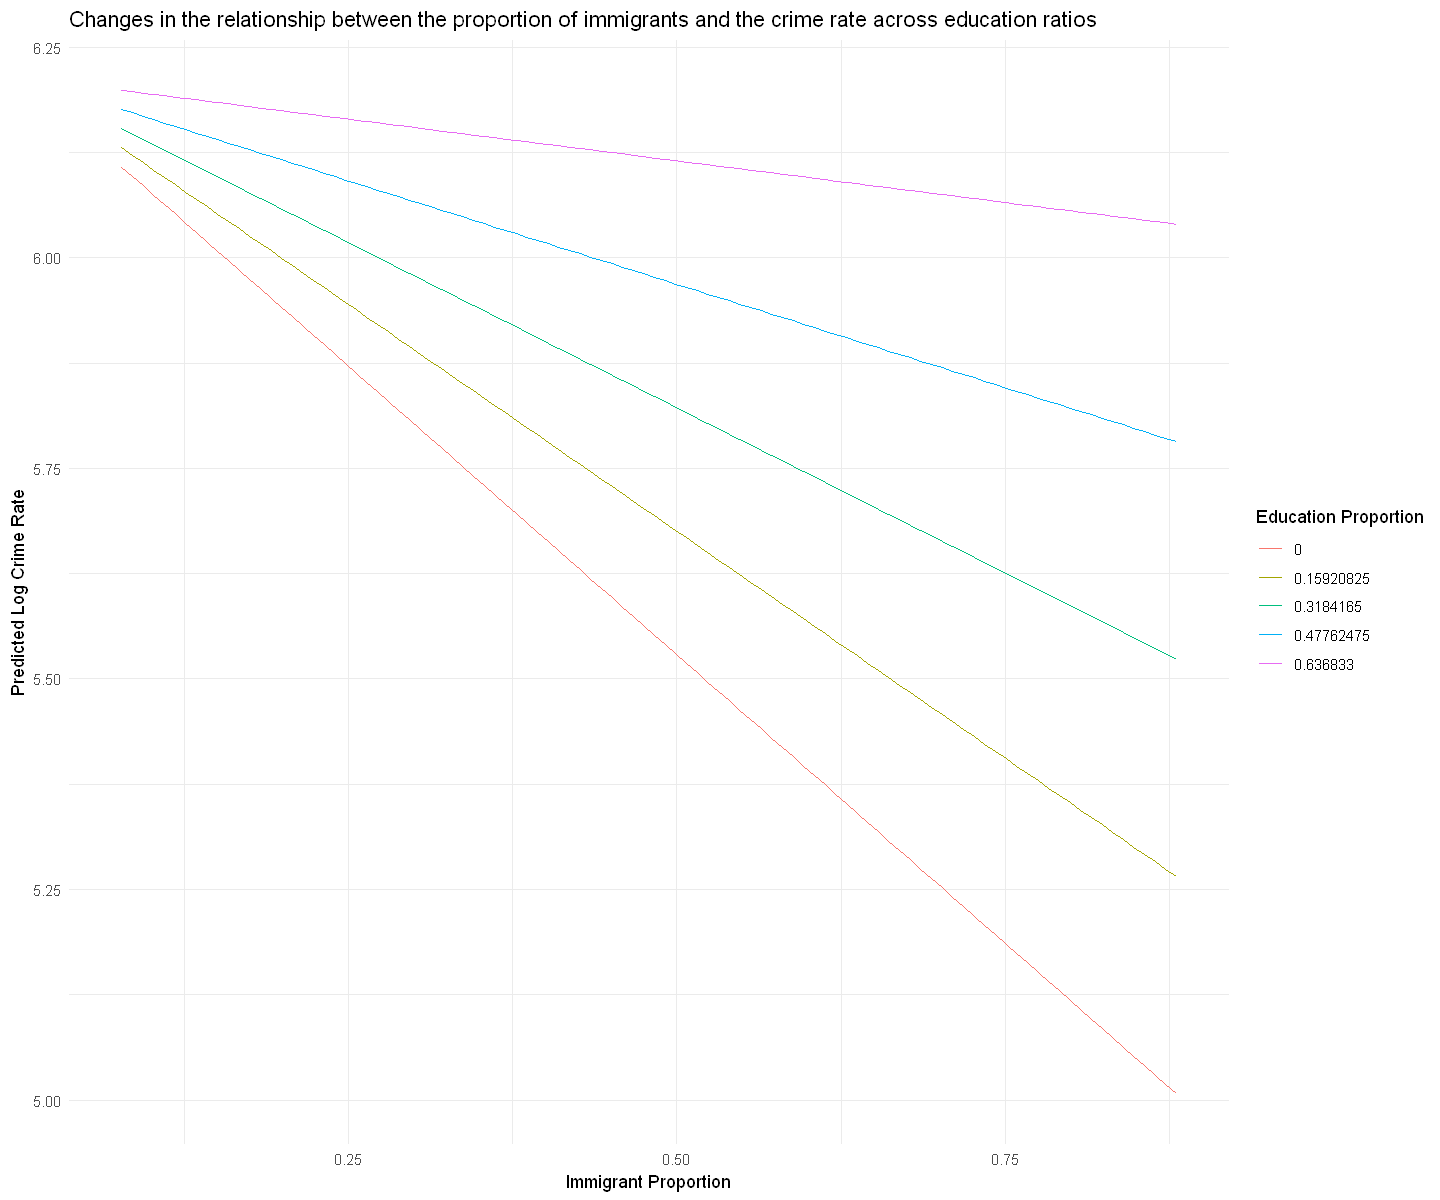

In [65]:
education_levels <- seq(min(census_index_crime_log_st$education_prop), 
                        max(census_index_crime_log_st$education_prop), length.out = 5)
immigrant_levels <- seq(min(census_index_crime_log_st$immigrant_prop), 
                        max(census_index_crime_log_st$immigrant_prop), length.out = 100)
plot_data <- expand.grid(education_prop = education_levels, 
                         immigrant_prop = immigrant_levels)

plot_data$pred_log_crime_rate <- 4.35911 + 
  0.15751 * mean(census_index_crime_log_st$log_mean_land_value) +
  (-0.56388) * mean(census_index_crime_log_st$log_school_index) +
  1.27117 * mean(census_index_crime_log_st$log_light_index) +
  0.42509 * mean(census_index_crime_log_st$log_cultural_space_index) +
  (-0.41789) * mean(census_index_crime_log_st$log_income) +
  (-1.37070) * plot_data$immigrant_prop +
  0.96127 * mean(census_index_crime_log_st$insite_dummy) +
  1.84146 * plot_data$immigrant_prop * plot_data$education_prop

ggplot(plot_data, aes(x = immigrant_prop, y = pred_log_crime_rate, color = as.factor(education_prop))) +
  geom_line() +
  labs(title = "Changes in the relationship between the proportion of immigrants and the crime rate across education ratios",
       x = "Immigrant Proportion",
       y = "Predicted Log Crime Rate",
       color = "Education Proportion") +
  theme_minimal()

In [66]:
# Pull unemployment census data and calculate the unemployment rate
library(cancensus)
options(cancensus.api_key='CensusMapper_f228791d9506a7a747ece66db73b95be')
options(cancensus.cache_path = "/cache")
census_data_unemployed <- get_census(dataset='CA16', regions=list(CSD="5915022"), vectors=c("v_CA16_5600","v_CA16_5606"), labels="detailed", geo_format= 'sf', level='DA')|>
    mutate(unemployment_rate = `v_CA16_5606: Unemployed`/`v_CA16_5600: In the labour force`)|>
    rename(name = GeoUID)|>
    select(name, unemployment_rate)|>
    st_drop_geometry()

glimpse(census_data_unemployed)

Warning message:
"package 'cancensus' was built under R version 4.4.2"
Census data is currently stored temporarily.

 In order to speed up performance, reduce API quota usage, and reduce unnecessary network calls, please set up a persistent cache directory via `set_cancensus_cache_path('<local cache path>', install = TRUE)`.
 This will add your cache directory as environment varianble to your .Renviron to be used across sessions and projects.



Reading vectors data from local cache.

Reading geo data from local cache.



Rows: 993
Columns: 2
$ name              <chr> "59150307", "59150308", "59150309", "59150310", "591…
$ unemployment_rate <dbl> 0.07228916, 0.10937500, 0.00000000, 0.05769231, 0.02…


In [67]:
# Merge two dataset
census_index_crime_log_st <- merge(census_index_crime_log_st, census_data_unemployed, by = "name") |>
    mutate(unemployment_rate = ifelse(is.na(unemployment_rate)|is.nan(unemployment_rate), 0, unemployment_rate)) |>
    glimpse()

Rows: 989
Columns: 31
$ name                     <chr> "59150307", "59150308", "59150309", "59150310…
$ households               <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, …
$ dwellings                <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, …
$ population               <int> 632, 501, 745, 536, 532, 562, 1088, 556, 959,…
$ population_density       <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.…
$ region                   <chr> "Vancouver", "Vancouver", "Vancouver", "Vanco…
$ area_sq_km               <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, …
$ age                      <int> 630, 500, 745, 540, 530, 560, 1085, 555, 960,…
$ income                   <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, …
$ immigrant_prop           <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0…
$ education_prop           <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0…
$ school_index             <dbl> 1.967207, 2.127046, 2.283703, 3.196982, 2.388…
$ light_index     

In [68]:
sum(census_index_crime_log_st$unemployment_rate == 0)

[1] 94

In [69]:
mean(census_index_crime_log_st$unemployment_rate)

[1] 0.05799239

In [70]:
reg_log6 <- lm(log_crime_rate ~ log_mean_land_value + log_school_index + log_light_index + log_cultural_space_index
               + log_income + immigrant_prop + education_prop + insite_dummy + unemployment_rate ,  
              data = census_index_crime_log_st)

white_test <- bptest(reg_log6, ~ fitted(reg_log6) + I(fitted(reg_log6)^2), data = census_index_crime_log_st)
print(white_test)      

robust_se6 <- sqrt(diag(vcovHC(reg_log6, type = "HC1")))

stargazer(reg_log6, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se6),
        single.row=TRUE)


	studentized Breusch-Pagan test

data:  reg_log6
BP = 26.291, df = 2, p-value = 1.954e-06


Log-Log Regression Results with Robust Standard Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_mean_land_value           0.172*** (0.043)      
log_school_index              -0.833*** (0.155)     
log_light_index               1.490*** (0.230)      
log_cultural_space_index      0.957*** (0.145)      
log_income                    -0.328*** (0.073)     
immigrant_prop                -0.615*** (0.174)     
education_prop                0.564*** (0.212)      
insite_dummy                  0.929*** (0.166)      
unemployment_rate               0.972 (0.706)       
Constant                      3.301*** (0.230)      
----------------------------------------------------
Observations                         989            
R2  

In [71]:
vif(reg_log6)|>tidy()

Warning message in tidy.numeric(vif(reg_log6)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_mean_land_value,1.036224
log_school_index,1.960712
log_light_index,2.685020
log_cultural_space_index,3.443722
log_income,1.494640
immigrant_prop,1.644282
education_prop,1.723161
insite_dummy,1.031699
unemployment_rate,1.079211


In [72]:
stargazer(reg_log2,reg_log3, reg_log4, reg_log5, reg_log6, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se2, robust_se3, robust_se4, robust_se5, robust_se6),
        single.row=TRUE)


Log-Log Regression Results with Robust Standard Errors
                                                                                Dependent variable:                                                  
                              -----------------------------------------------------------------------------------------------------------------------
                                                                                  Log Crime Rate                                                     
                                        (1)                     (2)                     (3)                     (4)                     (5)          
-----------------------------------------------------------------------------------------------------------------------------------------------------
log_mean_land_value              0.175*** (0.042)        0.175*** (0.042)        0.170*** (0.042)        0.171*** (0.042)        0.172*** (0.043)    
log_school_index                 -0.870*** (

In [73]:
# Carry out all the simple regressions
# Specifically evaluate if unemployment rate is significant
regressors <- c('log_mean_land_value','log_school_index', 'log_light_index', 'log_bus_index', 'log_cultural_space_index', 
                'log_income', 'immigrant_prop', 'education_prop','insite_dummy', 'unemployment_rate')

outcome <- "log_crime_rate"

log_log_simple_regressions <- map(regressors, ~ lm(as.formula(paste(outcome, "~", .x)), data = census_index_crime_log_st))

names(log_log_simple_regressions) <- regressors

stargazer(log_log_simple_regressions, type = "text",
          title = "Log-Log Simple Regression Results",
          dep.var.labels = c("Log Crime Rate"))


Log-Log Simple Regression Results
                                                                        Dependent variable:                                          
                               ------------------------------------------------------------------------------------------------------
                                                                           Log Crime Rate                                            
                                  (1)       (2)       (3)        (4)        (5)        (6)       (7)        (8)       (9)      (10)  
-------------------------------------------------------------------------------------------------------------------------------------
log_mean_land_value            0.127***                                                                                              
                                (0.037)                                                                                              
                           

In [74]:
# Correctly filter out rows where unemployment_rate is 0 and select relevant columns
census_unemployment_omit_zero <- census_index_crime_log_st |>
    filter(unemployment_rate != 0)

regression_omit_zero <- lm(log_crime_rate ~ unemployment_rate, data = census_unemployment_omit_zero)

summary(regression_omit_zero)


Call:
lm(formula = log_crime_rate ~ unemployment_rate, data = census_unemployment_omit_zero)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7559 -0.5102 -0.1010  0.3612  3.9302 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        5.59827    0.06302  88.831   <2e-16 ***
unemployment_rate  1.41407    0.89024   1.588    0.113    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8011 on 893 degrees of freedom
Multiple R-squared:  0.002817,	Adjusted R-squared:  0.001701 
F-statistic: 2.523 on 1 and 893 DF,  p-value: 0.1125


`geom_smooth()` using formula = 'y ~ x'


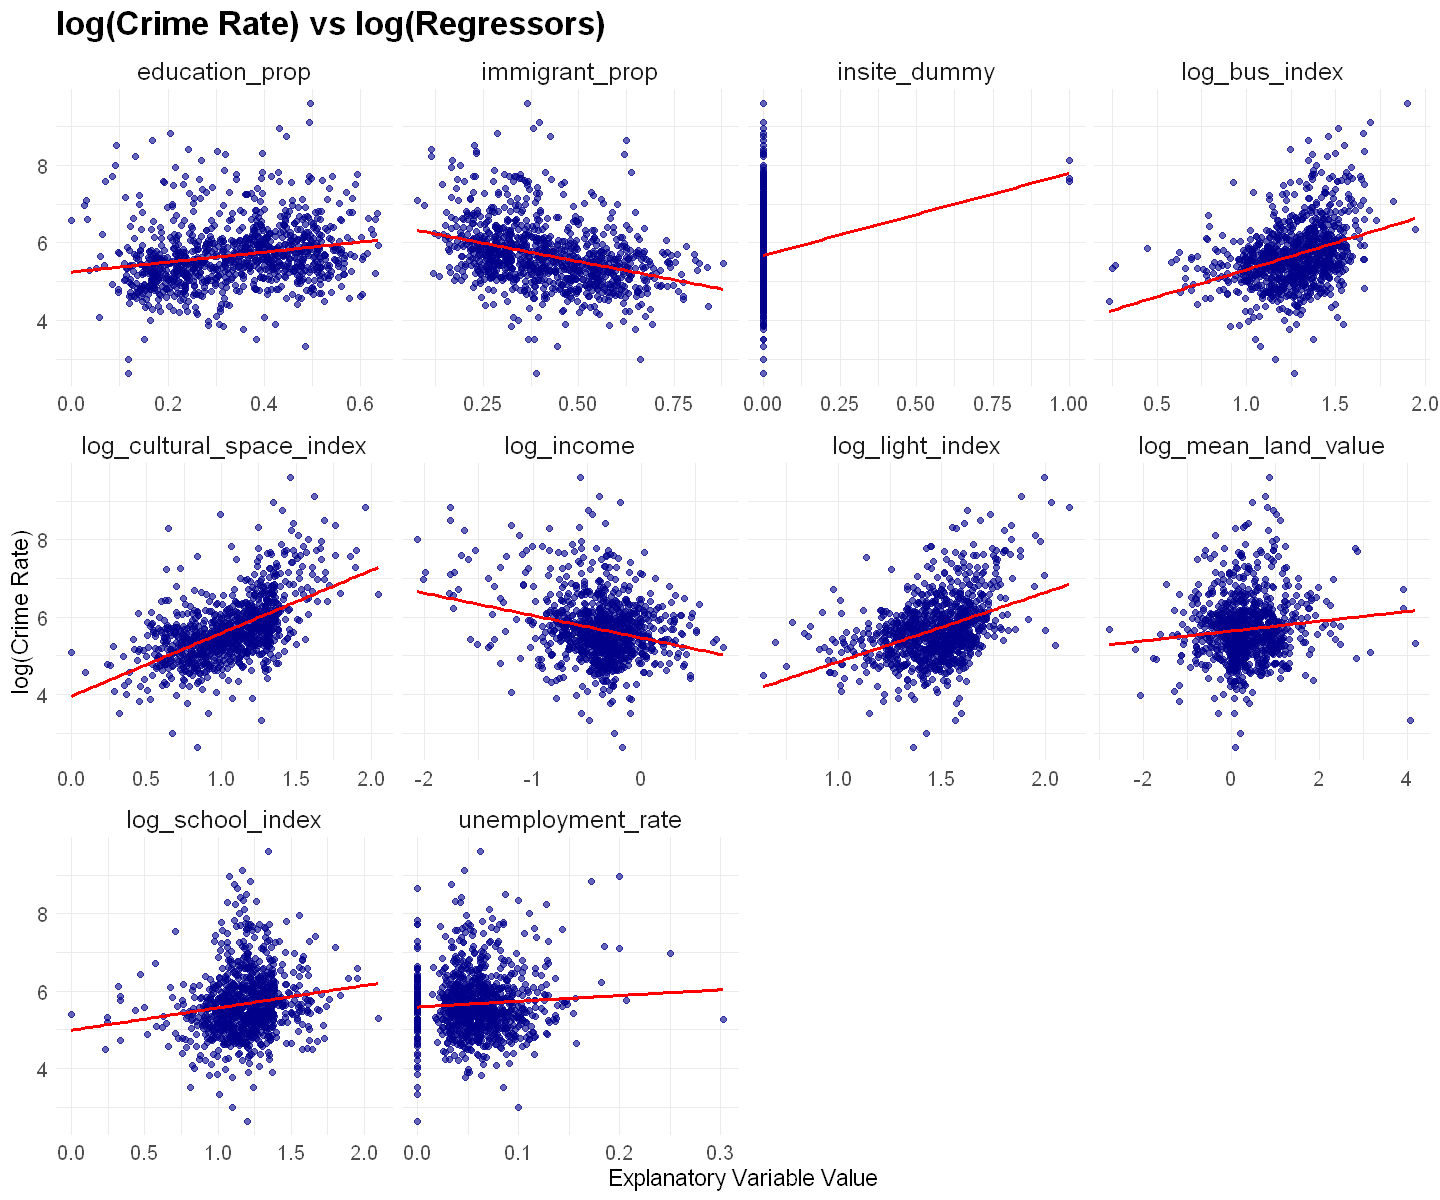

In [75]:
long_data <- census_index_crime_log_st |>
  pivot_longer(cols = regressors,
               names_to = "regressor",
               values_to = "value")

log_log_variables_scatter <- ggplot(long_data, aes(x = value, y = log_crime_rate)) +
  geom_point(color = "darkblue", alpha = 0.6) +
  facet_wrap(~ regressor, scales = "free_x") + 
  labs(title = "log(Crime Rate) vs log(Regressors)",
       x = "Explanatory Variable Value",
       y = "log(Crime Rate)") +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        strip.text = element_text(size = 15),  
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

log_log_variables_scatter

In [76]:
light_data <- get_cov_data(dataset_id = 'street-lighting-poles')|>
    st_sf()

In [77]:
# Merge light counts back into the census dataset
light_data <- st_transform(light_data, st_crs(census_index_crime_log_st))

lights_with_census <- st_join(light_data, census_index_crime_log_st, join = st_within)

light_counts <- lights_with_census %>%
    st_drop_geometry() %>% 
    group_by(name) %>%     
    summarize(light_count = n(), .groups = "drop")

census_index_crime_log_st <- census_index_crime_log_st %>%
    left_join(light_counts, by = "name") %>%
    mutate(light_count = replace_na(light_count, 0))|>
    mutate(light_count_sq_km
     = light_count/area_sq_km)|>
    mutate(log_light_count = log(if_else(light_count == 0, 0.01, light_count)),
        log_light_count_sq_km = log(if_else(light_count_sq_km == 0, 0.01, light_count_sq_km))) # Fill missing values with 0

glimpse(census_index_crime_log_st)

Rows: 989
Columns: 35
$ name                     <chr> "59150307", "59150308", "59150309", "59150310…
$ households               <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, …
$ dwellings                <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, …
$ population               <int> 632, 501, 745, 536, 532, 562, 1088, 556, 959,…
$ population_density       <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.…
$ region                   <chr> "Vancouver", "Vancouver", "Vancouver", "Vanco…
$ area_sq_km               <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, …
$ age                      <int> 630, 500, 745, 540, 530, 560, 1085, 555, 960,…
$ income                   <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, …
$ immigrant_prop           <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0…
$ education_prop           <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0…
$ school_index             <dbl> 1.967207, 2.127046, 2.283703, 3.196982, 2.388…
$ light_index     

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(regressors_light_count)

  # Now:
  data %>% select(all_of(regressors_light_count))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."
`geom_smooth()` using formula = 'y ~ x'


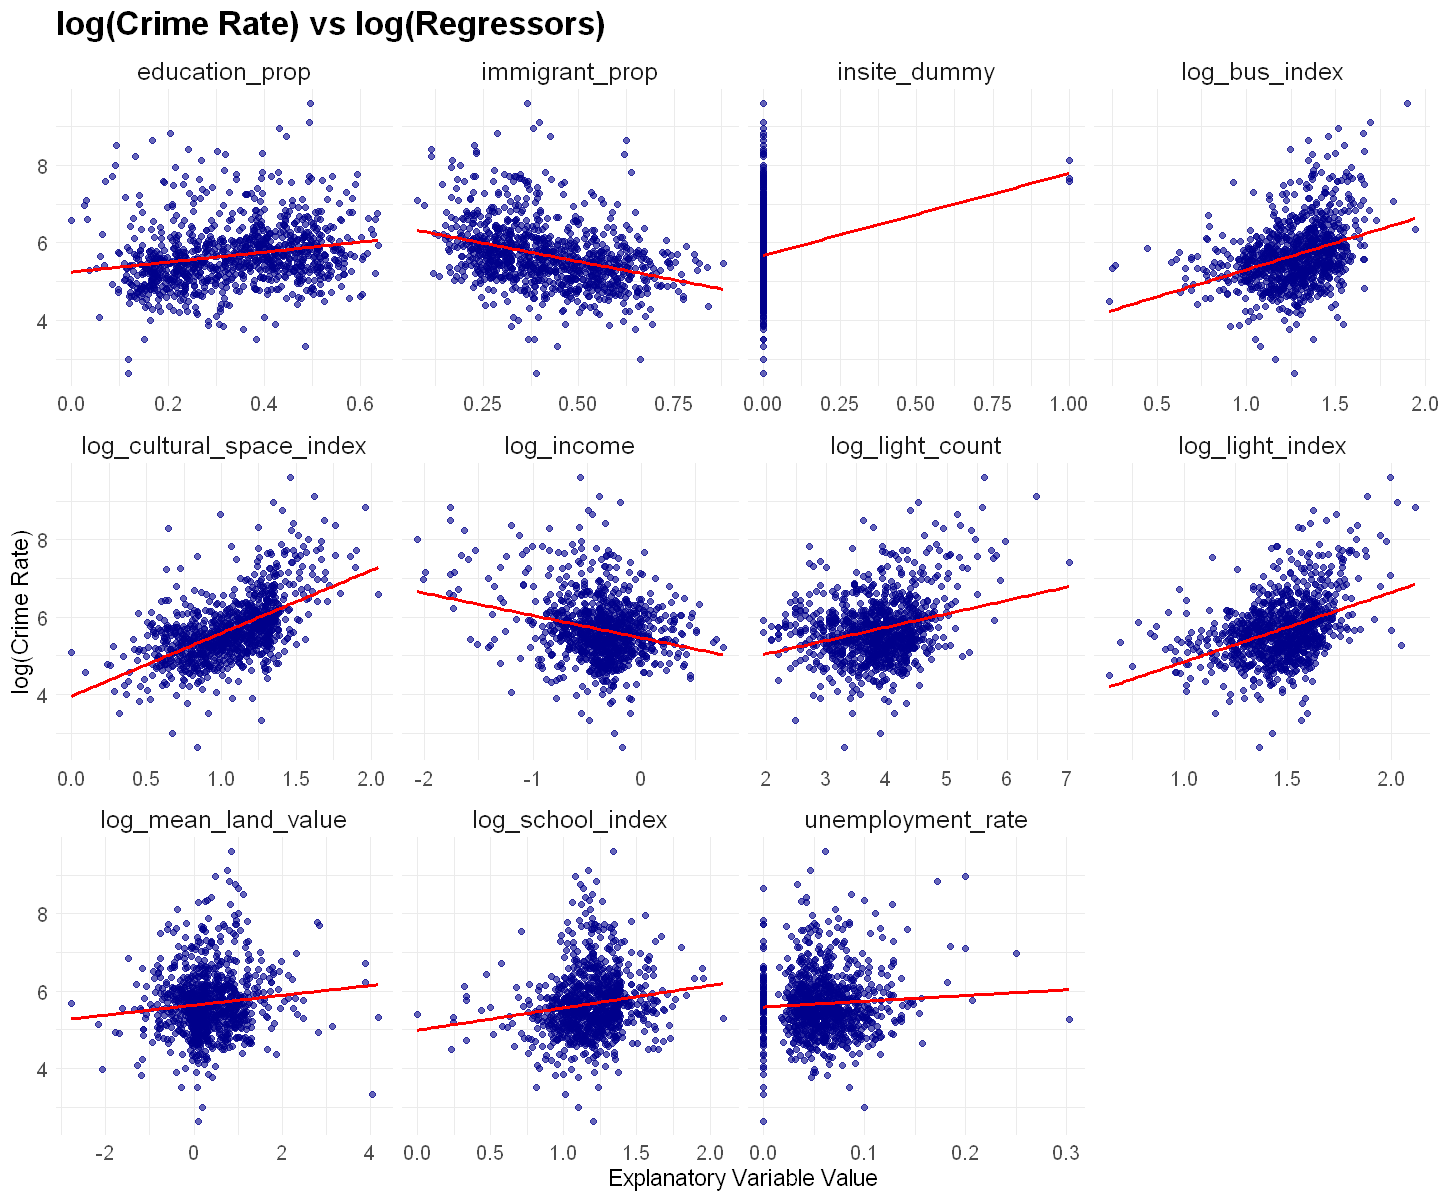

In [78]:
regressors_light_count <- c('log_mean_land_value','log_school_index', 'log_light_index', 'log_bus_index', 'log_cultural_space_index', 
                'log_income', 'immigrant_prop', 'education_prop','insite_dummy', 'unemployment_rate', 'log_light_count')

long_data_light_count <- census_index_crime_log_st |>
  pivot_longer(cols = regressors_light_count,
               names_to = "regressor",
               values_to = "value")

log_log_variables_scatter_light_count <- ggplot(long_data_light_count, aes(x = value, y = log_crime_rate)) +
  geom_point(color = "darkblue", alpha = 0.6) +
  facet_wrap(~ regressor, scales = "free_x") + 
  labs(title = "log(Crime Rate) vs log(Regressors)",
       x = "Explanatory Variable Value",
       y = "log(Crime Rate)") +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        strip.text = element_text(size = 15),  
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

log_log_variables_scatter_light_count

In [79]:
# replace light_index with light_count
reg_log7 <- lm(log_crime_rate ~ log_light_count+ log_mean_land_value + log_school_index + log_cultural_space_index
               + log_income + immigrant_prop + education_prop + insite_dummy , 
              data = census_index_crime_log_st)

white_test <- bptest(reg_log7, ~ fitted(reg_log7) + I(fitted(reg_log7)^2), data = census_index_crime_log_st)
print(white_test)  

robust_se7 <- sqrt(diag(vcovHC(reg_log7, type = "HC1")))

stargazer(reg_log7, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        # se = list(robust_se7),
        single.row=TRUE)


	studentized Breusch-Pagan test

data:  reg_log7
BP = 5.2295, df = 2, p-value = 0.07319


Log-Log Regression Results with Robust Standard Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_light_count               0.508*** (0.030)      
log_mean_land_value           0.084*** (0.027)      
log_school_index              -0.483*** (0.105)     
log_cultural_space_index      1.454*** (0.100)      
log_income                    -0.531*** (0.062)     
immigrant_prop                -0.522*** (0.152)     
education_prop                0.781*** (0.177)      
insite_dummy                   0.818** (0.335)      
Constant                      2.494*** (0.188)      
----------------------------------------------------
Observations                         989            
R2                                  0.514           
Adjust

In [80]:
vif(reg_log7)|>tidy()

Warning message in tidy.numeric(vif(reg_log7)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_light_count,1.163292
log_mean_land_value,1.056504
log_school_index,1.582956
log_cultural_space_index,2.461671
log_income,1.494789
immigrant_prop,1.565124
education_prop,1.713568
insite_dummy,1.026754


In [81]:
reg_log_area <- lm(log_crime_rate ~ log_light_count_sq_km+ log_mean_land_value + log_school_index + log_cultural_space_index
               + log_income + immigrant_prop + education_prop + insite_dummy , 
              data = census_index_crime_log_st)

robust_se_area <- sqrt(diag(vcovHC(reg_log_area, type = "HC1")))

stargazer(reg_log_area, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se_area),
        single.row=TRUE)


Log-Log Regression Results with Robust Standard Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_light_count_sq_km           0.030 (0.084)       
log_mean_land_value           0.166*** (0.050)      
log_school_index              -0.352*** (0.119)     
log_cultural_space_index      1.527*** (0.133)      
log_income                    -0.267*** (0.080)     
immigrant_prop                 -0.276 (0.178)       
education_prop                  0.226 (0.218)       
insite_dummy                  1.240*** (0.193)      
Constant                      4.171*** (0.502)      
----------------------------------------------------
Observations                         989            
R2                                  0.372           
Adjusted R2                         0.367           
Residual Std. Error           0.650 (df = 9

In [82]:
stargazer(reg_log3,reg_log7, reg_log_area, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        column.labels = c("index","count"),
        se = list(robust_se3,robust_se7, robust_se_area),
        single.row=TRUE)


Log-Log Regression Results with Robust Standard Errors
                                                Dependent variable:                 
                               -----------------------------------------------------
                                                  Log Crime Rate                    
                                     index             count                        
                                      (1)               (2)               (3)       
------------------------------------------------------------------------------------
log_light_index                1.487*** (0.231)                                     
log_light_count                                  0.508*** (0.037)                   
log_light_count_sq_km                                                0.030 (0.084)  
log_mean_land_value            0.175*** (0.042)   0.084** (0.034)  0.166*** (0.050) 
log_school_index               -0.838*** (0.156) -0.483*** (0.105) -0.352*** (0.119)
log_cultu

In [83]:
# Create a downtown dummy in our dataset
census_index_crime_log_st_valid <- st_make_valid(census_index_crime_log_st)
local_area_boundary_valid <- st_make_valid(local_area_boundary)

selected_areas <- local_area_boundary_valid %>%
  filter(name %in% c("West End", "Downtown", "Strathcona"))

census_index_crime_log_st_valid <- st_simplify(census_index_crime_log_st_valid, dTolerance = 0.01)
selected_areas <- st_simplify(selected_areas, dTolerance = 0.01)

desired_crs <- st_crs(selected_areas)
census_index_crime_log_st_valid <- st_transform(census_index_crime_log_st_valid, crs = desired_crs)

census_index_crime_log_st_valid$is_downtown <- as.integer(
  lengths(st_intersects(census_index_crime_log_st_valid, selected_areas)) > 0
)

glimpse(census_index_crime_log_st_valid)

problematic_geometries <- census_index_crime_log_st[!st_is_valid(census_index_crime_log_st), ]
if (nrow(problematic_geometries) > 0) {
  print("Problematic Geometries:")
  print(problematic_geometries)
} else {
  print("No problematic geometries found.")
}

Rows: 989
Columns: 36
$ name                     <chr> "59150307", "59150308", "59150309", "59150310…
$ households               <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, …
$ dwellings                <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, …
$ population               <int> 632, 501, 745, 536, 532, 562, 1088, 556, 959,…
$ population_density       <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.…
$ region                   <chr> "Vancouver", "Vancouver", "Vancouver", "Vanco…
$ area_sq_km               <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, …
$ age                      <int> 630, 500, 745, 540, 530, 560, 1085, 555, 960,…
$ income                   <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, …
$ immigrant_prop           <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0…
$ education_prop           <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0…
$ school_index             <dbl> 1.967207, 2.127046, 2.283703, 3.196982, 2.388…
$ light_index     

In [84]:
# replace insite_dummy with is_downtown
reg_log8 <- lm(log_crime_rate ~ log_light_count + log_mean_land_value + log_school_index  + log_cultural_space_index
               + log_income + immigrant_prop + education_prop + is_downtown , 
              data = census_index_crime_log_st_valid)

white_test <- bptest(reg_log8, ~ fitted(reg_log8) + I(fitted(reg_log8)^2), data = census_index_crime_log_st_valid)
print(white_test) 

robust_se8 <- sqrt(diag(vcovHC(reg_log8, type = "HC1")))

stargazer(reg_log8, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se8),
        single.row=TRUE)


	studentized Breusch-Pagan test

data:  reg_log8
BP = 6.8532, df = 2, p-value = 0.0325


Log-Log Regression Results with Robust Standard Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_light_count               0.520*** (0.037)      
log_mean_land_value            0.082** (0.035)      
log_school_index              -0.311*** (0.103)     
log_cultural_space_index      1.212*** (0.111)      
log_income                    -0.454*** (0.068)     
immigrant_prop                -0.656*** (0.151)     
education_prop                0.691*** (0.192)      
is_downtown                   0.315*** (0.075)      
Constant                      2.571*** (0.206)      
----------------------------------------------------
Observations                         989            
R2                                  0.522           
Adjuste

In [85]:
vif(reg_log8)|>tidy()

Warning message in tidy.numeric(vif(reg_log8)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_light_count,1.157983
log_mean_land_value,1.055765
log_school_index,1.803407
log_cultural_space_index,3.183091
log_income,1.609053
immigrant_prop,1.606229
education_prop,1.718257
is_downtown,1.741731


In [86]:
stargazer(reg_log7,reg_log8, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        column.labels = c("insite","downtown"),
        se = list(robust_se7,robust_se8),
        single.row=TRUE)


Log-Log Regression Results with Robust Standard Errors
                                       Dependent variable:        
                               -----------------------------------
                                         Log Crime Rate           
                                    insite           downtown     
                                      (1)               (2)       
------------------------------------------------------------------
log_light_count                0.508*** (0.037)  0.520*** (0.037) 
log_mean_land_value             0.084** (0.034)   0.082** (0.035) 
log_school_index               -0.483*** (0.105) -0.311*** (0.103)
log_cultural_space_index       1.454*** (0.111)  1.212*** (0.111) 
log_income                     -0.531*** (0.065) -0.454*** (0.068)
immigrant_prop                 -0.522*** (0.153) -0.656*** (0.151)
education_prop                 0.781*** (0.195)  0.691*** (0.192) 
insite_dummy                   0.818*** (0.142)                   
is_dow

In [87]:
# drop log_mean_land_value
reg_log9 <- lm(log_crime_rate ~  log_light_count + log_school_index +  log_cultural_space_index
               + log_income + immigrant_prop + education_prop + is_downtown , 
              data = census_index_crime_log_st_valid)

white_test <- bptest(reg_log9, ~ fitted(reg_log9) + I(fitted(reg_log9)^2), data = census_index_crime_log_st_valid)
print(white_test) 

robust_se9 <- sqrt(diag(vcovHC(reg_log9, type = "HC1")))

stargazer(reg_log9, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se9),
        single.row=TRUE)


	studentized Breusch-Pagan test

data:  reg_log9
BP = 7.054, df = 2, p-value = 0.02939


Log-Log Regression Results with Robust Standard Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_light_count               0.535*** (0.035)      
log_school_index              -0.332*** (0.104)     
log_cultural_space_index      1.202*** (0.112)      
log_income                    -0.454*** (0.069)     
immigrant_prop                -0.660*** (0.152)     
education_prop                0.751*** (0.191)      
is_downtown                   0.316*** (0.075)      
Constant                      2.557*** (0.207)      
----------------------------------------------------
Observations                         989            
R2                                  0.517           
Adjusted R2                         0.514           
Residua

In [88]:
# Create interaction for light and downtown
reg_log10 <- lm(log_crime_rate ~  log_light_count + log_mean_land_value + log_school_index +  log_cultural_space_index
               + log_income + immigrant_prop + education_prop + is_downtown + is_downtown:log_light_count, 
              data = census_index_crime_log_st_valid)

white_test <- bptest(reg_log10, ~ fitted(reg_log10) + I(fitted(reg_log10)^2), data = census_index_crime_log_st_valid)
print(white_test) 

robust_se10 <- sqrt(diag(vcovHC(reg_log10, type = "HC1")))

stargazer(reg_log10, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se10),
        single.row=TRUE)


	studentized Breusch-Pagan test

data:  reg_log10
BP = 6.4181, df = 2, p-value = 0.04039


Log-Log Regression Results with Robust Standard Errors
                                Dependent variable:    
                            ---------------------------
                                  Log Crime Rate       
-------------------------------------------------------
log_light_count                  0.455*** (0.045)      
log_mean_land_value              0.095*** (0.034)      
log_school_index                 -0.299*** (0.104)     
log_cultural_space_index         1.193*** (0.112)      
log_income                       -0.434*** (0.071)     
immigrant_prop                   -0.616*** (0.150)     
education_prop                   0.672*** (0.193)      
is_downtown                       -0.236 (0.263)       
log_light_count:is_downtown       0.154** (0.075)      
Constant                         2.817*** (0.226)      
-------------------------------------------------------
Observations 

In [89]:
# Test inverse causality
reg_log_inverse <- lm(log_light_count ~ log_crime_rate + log_mean_land_value + log_school_index +  log_cultural_space_index
               + log_income + immigrant_prop + education_prop + is_downtown , 
              data = census_index_crime_log_st_valid)

robust_se_inverse <- sqrt(diag(vcovHC(reg_log_inverse, type = "HC1")))

stargazer(reg_log_inverse, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Light Count"), 
        se = list(robust_se_inverse),
        single.row=TRUE)


Log-Log Regression Results with Robust Standard Errors
                             Dependent variable:    
                         ---------------------------
                               Log Light Count      
----------------------------------------------------
log_crime_rate                0.457*** (0.031)      
log_mean_land_value            0.076** (0.031)      
log_school_index              0.277*** (0.099)      
log_cultural_space_index      -0.338*** (0.130)     
log_income                    0.573*** (0.065)      
immigrant_prop                0.711*** (0.147)      
education_prop                -1.153*** (0.167)     
is_downtown                   -0.212*** (0.079)     
Constant                      1.576*** (0.201)      
----------------------------------------------------
Observations                         989            
R2                                  0.342           
Adjusted R2                         0.336           
Residual Std. Error           0.532 (df = 9

In [90]:
# include population density in our model
census_index_crime_log_st_valid_density <- census_index_crime_log_st_valid|>
    mutate(log_population_density = log(ifelse(population_density == 0, 0.01, population_density)))|>
    glimpse()

Rows: 989
Columns: 37
$ name                     <chr> "59150307", "59150308", "59150309", "59150310…
$ households               <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, …
$ dwellings                <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, …
$ population               <int> 632, 501, 745, 536, 532, 562, 1088, 556, 959,…
$ population_density       <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.…
$ region                   <chr> "Vancouver", "Vancouver", "Vancouver", "Vanco…
$ area_sq_km               <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, …
$ age                      <int> 630, 500, 745, 540, 530, 560, 1085, 555, 960,…
$ income                   <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, …
$ immigrant_prop           <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0…
$ education_prop           <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0…
$ school_index             <dbl> 1.967207, 2.127046, 2.283703, 3.196982, 2.388…
$ light_index     

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(regressors_density)

  # Now:
  data %>% select(all_of(regressors_density))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."
`geom_smooth()` using formula = 'y ~ x'


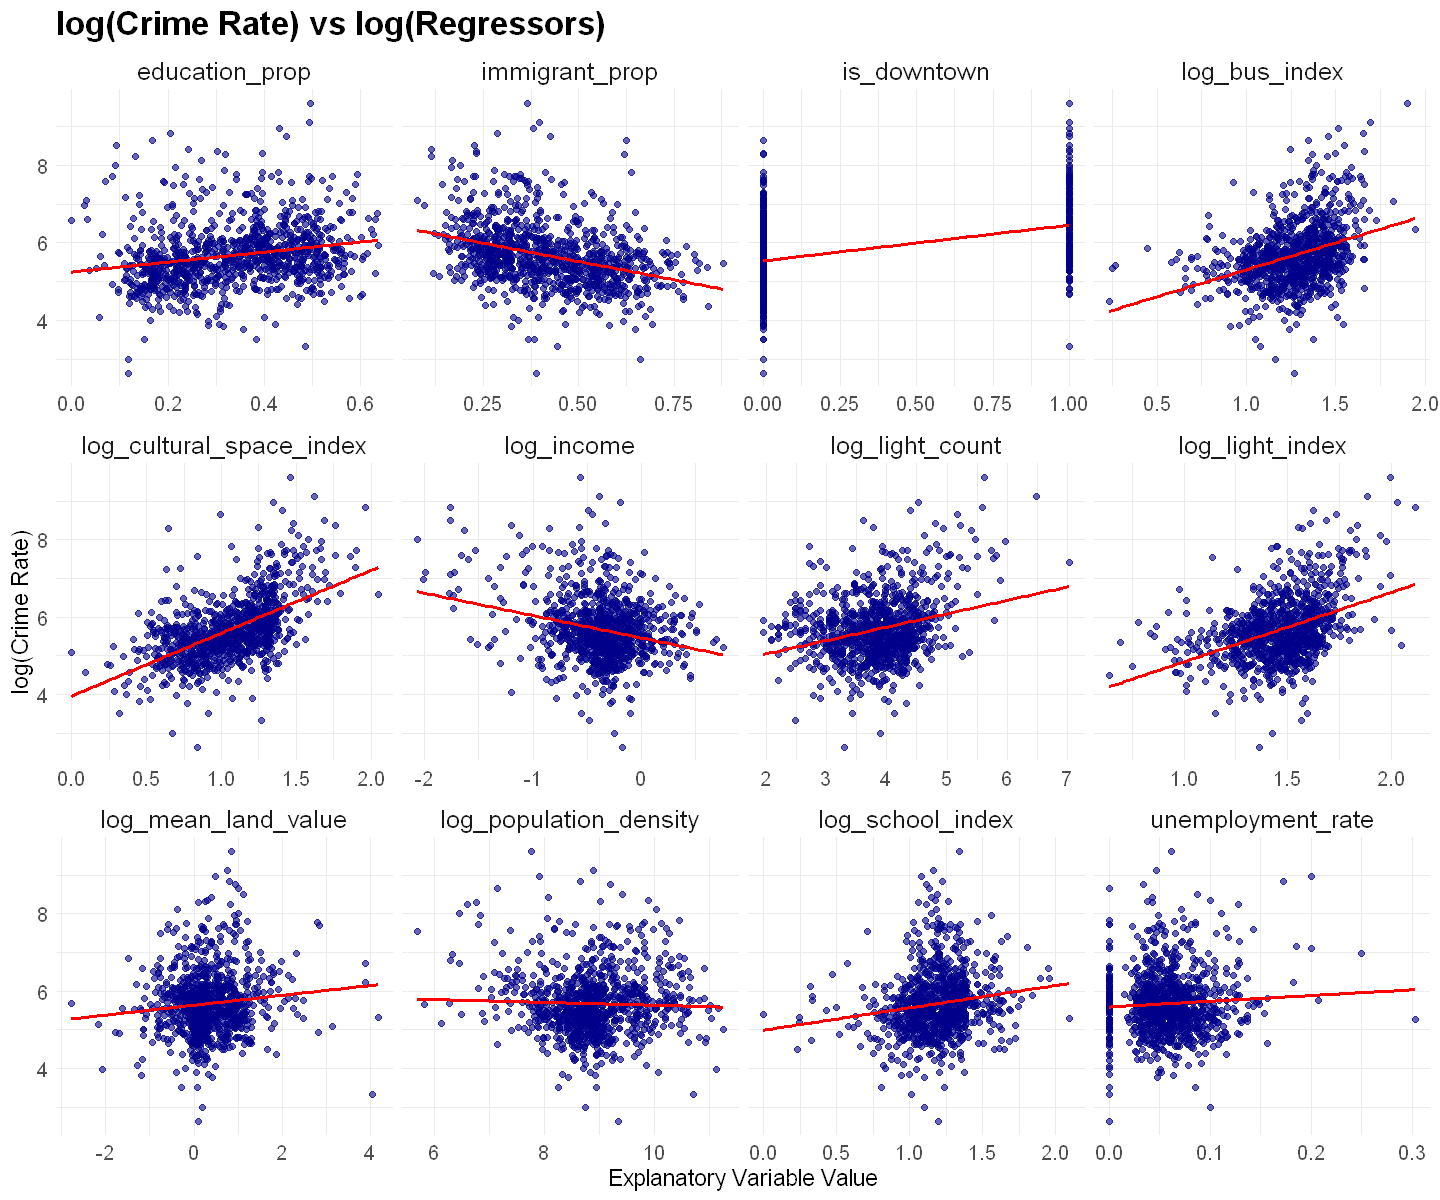

In [91]:
regressors_density <- c('log_mean_land_value','log_school_index', 'log_light_index', 'log_bus_index', 'log_cultural_space_index', 
                'log_income', 'immigrant_prop', 'education_prop','is_downtown', 'unemployment_rate', 'log_light_count', 'log_population_density')

long_data_density <- census_index_crime_log_st_valid_density |>
  pivot_longer(cols = regressors_density,
               names_to = "regressor",
               values_to = "value")

log_log_variables_scatter_density <- ggplot(long_data_density, aes(x = value, y = log_crime_rate)) +
  geom_point(color = "darkblue", alpha = 0.6) +
  facet_wrap(~ regressor, scales = "free_x") + 
  labs(title = "log(Crime Rate) vs log(Regressors)",
       x = "Explanatory Variable Value",
       y = "log(Crime Rate)") +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        strip.text = element_text(size = 15),  
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

log_log_variables_scatter_density

In [92]:
# include log_population_density
reg_log11 <- lm(log_crime_rate ~  log_light_count + log_school_index +  log_cultural_space_index
               + log_income + log_population_density + immigrant_prop + education_prop + is_downtown , 
              data = census_index_crime_log_st_valid_density)

white_test <- bptest(reg_log11, ~ fitted(reg_log11) + I(fitted(reg_log11)^2), data = census_index_crime_log_st_valid)
print(white_test) 

robust_se11 <- sqrt(diag(vcovHC(reg_log11, type = "HC1")))

stargazer(reg_log11, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se11),
        single.row=TRUE)


	studentized Breusch-Pagan test

data:  reg_log11
BP = 12.751, df = 2, p-value = 0.001703


Log-Log Regression Results with Robust Standard Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_light_count               0.353*** (0.042)      
log_school_index              -0.319*** (0.104)     
log_cultural_space_index      1.312*** (0.112)      
log_income                    -0.565*** (0.073)     
log_population_density        -0.263*** (0.041)     
immigrant_prop                -0.524*** (0.152)     
education_prop                0.903*** (0.189)      
is_downtown                   0.453*** (0.076)      
Constant                      5.290*** (0.448)      
----------------------------------------------------
Observations                         989            
R2                                  0.543           
Adju

In [93]:
vif(reg_log11)|>
    tidy()

Warning message in tidy.numeric(vif(reg_log11)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_light_count,1.961655
log_school_index,1.796803
log_cultural_space_index,3.238163
log_income,1.702624
log_population_density,2.593235
immigrant_prop,1.630702
education_prop,1.721259
is_downtown,1.888152


In [94]:
stargazer(reg_log9,reg_log11, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se9,robust_se11),
        single.row=TRUE)


Log-Log Regression Results with Robust Standard Errors
                                        Dependent variable:               
                         -------------------------------------------------
                                          Log Crime Rate                  
                                   (1)                      (2)           
--------------------------------------------------------------------------
log_light_count              0.535*** (0.035)         0.353*** (0.042)    
log_school_index            -0.332*** (0.104)        -0.319*** (0.104)    
log_cultural_space_index     1.202*** (0.112)         1.312*** (0.112)    
log_income                  -0.454*** (0.069)        -0.565*** (0.073)    
log_population_density                               -0.263*** (0.041)    
immigrant_prop              -0.660*** (0.152)        -0.524*** (0.152)    
education_prop               0.751*** (0.191)         0.903*** (0.189)    
is_downtown                  0.316*** (0.075

In [95]:
# Carry out all the simple regressions
regressors_density <- c('log_light_count','log_school_index', 'log_cultural_space_index', 
                'log_income', 'immigrant_prop', 'education_prop','is_downtown','log_population_density' )

outcome <- "log_crime_rate"

log_log_simple_regressions <- map(regressors_density, ~ lm(as.formula(paste(outcome, "~", .x)), data = census_index_crime_log_st_valid_density))

robust_se_simple <- map(log_log_simple_regressions, ~ sqrt(diag(vcovHC(.x, type = "HC1"))))

names(log_log_simple_regressions) <- regressors_density

stargazer(log_log_simple_regressions, reg_log11, type = "text",
          title = "Log-Log Simple Regression Results",
          dep.var.labels = c("Log Crime Rate", "Log Crime Rate"),
          se = robust_se_simple,
          single.row = TRUE)


Log-Log Simple Regression Results
                                                                                                                           Dependent variable:                                                                                                  
                         -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                 Log Crime Rate                                                                                              Log Crime Rate     
                                   (1)                     (2)                     (3)                      (4)                     (5)                      (6)                     (7)                    (8)                   (9)           
-

In [96]:
# add interaction
reg_log12 <- lm(log_crime_rate ~  log_light_count + log_school_index +  log_cultural_space_index
               + log_income + log_population_density + immigrant_prop + education_prop +  is_downtown:log_light_count, 
              data = census_index_crime_log_st_valid_density)

white_test <- bptest(reg_log12, ~ fitted(reg_log12) + I(fitted(reg_log12)^2), data = census_index_crime_log_st_valid_density)
print(white_test) 

robust_se12 <- sqrt(diag(vcovHC(reg_log12, type = "HC1")))

stargazer(reg_log12, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se12),
        single.row=TRUE)


	studentized Breusch-Pagan test

data:  reg_log12
BP = 12.644, df = 2, p-value = 0.001797


Log-Log Regression Results with Robust Standard Errors
                                Dependent variable:    
                            ---------------------------
                                  Log Crime Rate       
-------------------------------------------------------
log_light_count                  0.296*** (0.043)      
log_school_index                 -0.308*** (0.106)     
log_cultural_space_index         1.293*** (0.113)      
log_income                       -0.549*** (0.074)     
log_population_density           -0.270*** (0.042)     
immigrant_prop                   -0.490*** (0.152)     
education_prop                   0.898*** (0.188)      
log_light_count:is_downtown      0.130*** (0.021)      
Constant                         5.565*** (0.465)      
-------------------------------------------------------
Observations                            989            
R2          

In [97]:
vif(reg_log12)|>
    tidy()

there are higher-order terms (interactions) in this model
consider setting type = 'predictor'; see ?vif

Warning message in tidy.numeric(vif(reg_log12)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_light_count,2.156704
log_school_index,1.787256
log_cultural_space_index,3.233122
log_income,1.717569
log_population_density,2.605308
immigrant_prop,1.617597
education_prop,1.721539
log_light_count:is_downtown,1.906021


In [98]:
reg_log13 <- lm(log_crime_rate ~  log_light_count + log_school_index +  log_cultural_space_index
               + log_income + log_population_density + immigrant_prop + education_prop + is_downtown +  is_downtown:log_light_count, 
              data = census_index_crime_log_st_valid_density)

white_test <- bptest(reg_log13, ~ fitted(reg_log13) + I(fitted(reg_log13)^2), data = census_index_crime_log_st_valid_density)
print(white_test) 

robust_se13 <- sqrt(diag(vcovHC(reg_log13, type = "HC1")))

stargazer(reg_log13, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se13),
        single.row=TRUE)


	studentized Breusch-Pagan test

data:  reg_log13
BP = 12.652, df = 2, p-value = 0.00179


Log-Log Regression Results with Robust Standard Errors
                                Dependent variable:    
                            ---------------------------
                                  Log Crime Rate       
-------------------------------------------------------
log_light_count                  0.289*** (0.048)      
log_school_index                 -0.311*** (0.105)     
log_cultural_space_index         1.295*** (0.112)      
log_income                       -0.548*** (0.075)     
log_population_density           -0.269*** (0.043)     
immigrant_prop                   -0.483*** (0.151)     
education_prop                   0.898*** (0.188)      
is_downtown                       -0.066 (0.249)       
log_light_count:is_downtown       0.146** (0.071)      
Constant                         5.588*** (0.471)      
-------------------------------------------------------
Observations 

In [99]:
stargazer(reg_log11, reg_log12,reg_log13, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log (Crime Rate)"), 
          covariate.labels = c(
                "Log (Light Count)", 
                "Log (School Index)", 
                "Log (Cultural Space Index)", 
                "Log Income", 
                "Log (Population Density)",
                "Immigrant Proportion", 
                "Education Proportion", 
                "Is Downtown", 
                "Log (Light Count) × Is Downtown"),
        se = list(robust_se11,robust_se12,robust_se13),
        single.row = TRUE)


Log-Log Regression Results with Robust Standard Errors
                                                           Dependent variable:                            
                                --------------------------------------------------------------------------
                                                             Log (Crime Rate)                             
                                          (1)                      (2)                      (3)           
----------------------------------------------------------------------------------------------------------
Log (Light Count)                   0.353*** (0.042)         0.296*** (0.043)         0.289*** (0.048)    
Log (School Index)                 -0.319*** (0.104)        -0.308*** (0.106)        -0.311*** (0.105)    
Log (Cultural Space Index)          1.312*** (0.112)         1.293*** (0.113)         1.295*** (0.112)    
Log Income                         -0.565*** (0.073)        -0.549*** (0.074)        -0.

To further illustrate this problem, we hope to take age groups into account.

In [100]:
# Load average age data
options(cancensus.api_key='CensusMapper_f228791d9506a7a747ece66db73b95be')
options(cancensus.cache_path = "/cache")

census_data_age <- get_census(dataset='CA16', regions=list(CSD="5915022"), vectors=c("v_CA16_379","v_CA16_388"), labels="detailed", geo_format="sf", level='DA')|>
    rename(mean_age = `v_CA16_379: Average age`, name = GeoUID)|>
    mutate(prop_working_age = `v_CA16_388: 15 to 64 years`/100)|>
    select(name, mean_age, prop_working_age)|>
    st_drop_geometry()|>
    glimpse()

Reading vectors data from local cache.

Reading geo data from local cache.



Rows: 993
Columns: 3
$ name             <chr> "59150307", "59150308", "59150309", "59150310", "5915…
$ mean_age         <dbl> 43.2, 42.2, 41.5, 40.2, 40.1, 41.0, 43.9, 37.6, 42.3,…
$ prop_working_age <dbl> 0.622, 0.670, 0.745, 0.815, 0.710, 0.743, 0.696, 0.73…


In [101]:
mean(census_data_age$mean_age)
mean(census_data_age$prop_working_age)

[1] 41.70373

[1] 0.7241027

In [102]:
census_index_crime_log_st_valid_density_age <- merge(census_index_crime_log_st_valid_density, census_data_age, by = "name")|>
    mutate(log_mean_age = log(if_else(is.na(mean_age),0,mean_age)))|>
    glimpse()

Rows: 989
Columns: 40
$ name                     <chr> "59150307", "59150308", "59150309", "59150310…
$ households               <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, …
$ dwellings                <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, …
$ population               <int> 632, 501, 745, 536, 532, 562, 1088, 556, 959,…
$ population_density       <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.…
$ region                   <chr> "Vancouver", "Vancouver", "Vancouver", "Vanco…
$ area_sq_km               <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, …
$ age                      <int> 630, 500, 745, 540, 530, 560, 1085, 555, 960,…
$ income                   <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, …
$ immigrant_prop           <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0…
$ education_prop           <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0…
$ school_index             <dbl> 1.967207, 2.127046, 2.283703, 3.196982, 2.388…
$ light_index     

In [103]:
reg_log14 <- lm(log_crime_rate ~  log_light_count + log_school_index +  log_cultural_space_index
               + log_income + log_population_density + immigrant_prop + education_prop + log_mean_age + is_downtown:log_light_count, 
              data = census_index_crime_log_st_valid_density_age)

white_test <- bptest(reg_log14, ~ fitted(reg_log14) + I(fitted(reg_log14)^2), data = census_index_crime_log_st_valid_density_age)
print(white_test) 

robust_se14 <- sqrt(diag(vcovHC(reg_log14, type = "HC1")))

stargazer(reg_log14, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se14),
        single.row=TRUE)


	studentized Breusch-Pagan test

data:  reg_log14
BP = 13.194, df = 2, p-value = 0.001364


Log-Log Regression Results with Robust Standard Errors
                                Dependent variable:    
                            ---------------------------
                                  Log Crime Rate       
-------------------------------------------------------
log_light_count                  0.286*** (0.043)      
log_school_index                 -0.355*** (0.106)     
log_cultural_space_index         1.310*** (0.112)      
log_income                       -0.597*** (0.076)     
log_population_density           -0.298*** (0.043)     
immigrant_prop                   -0.438*** (0.151)     
education_prop                   0.875*** (0.187)      
log_mean_age                     -0.735*** (0.224)     
log_light_count:is_downtown      0.137*** (0.021)      
Constant                         8.596*** (1.063)      
-------------------------------------------------------
Observations

In [104]:
vif(reg_log14)|>
    tidy()

there are higher-order terms (interactions) in this model
consider setting type = 'predictor'; see ?vif

Warning message in tidy.numeric(vif(reg_log14)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_light_count,2.167112
log_school_index,1.810303
log_cultural_space_index,3.238628
log_income,1.783241
log_population_density,2.718941
immigrant_prop,1.631104
education_prop,1.723664
log_mean_age,1.135210
log_light_count:is_downtown,1.926401


In [105]:
stargazer(reg_log12,reg_log14, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log (Crime Rate)"), 
          covariate.labels = c(
                "Log (Light Count)", 
                "Log (School Index)", 
                "Log (Cultural Space Index)", 
                "Log Income", 
                "Log (Population Density)",
                "Immigrant Proportion", 
                "Education Proportion",
                "Log (Mean Age)",
                "Log (Light Count) × Is Downtown"),
        se = list(robust_se12,robust_se14),
        single.row = TRUE)


Log-Log Regression Results with Robust Standard Errors
                                               Dependent variable:               
                                -------------------------------------------------
                                                Log (Crime Rate)                 
                                          (1)                      (2)           
---------------------------------------------------------------------------------
Log (Light Count)                   0.296*** (0.043)         0.286*** (0.043)    
Log (School Index)                 -0.308*** (0.106)        -0.355*** (0.106)    
Log (Cultural Space Index)          1.293*** (0.113)         1.310*** (0.112)    
Log Income                         -0.549*** (0.074)        -0.597*** (0.076)    
Log (Population Density)           -0.270*** (0.042)        -0.298*** (0.043)    
Immigrant Proportion               -0.490*** (0.152)        -0.438*** (0.151)    
Education Proportion                0.898*

In [106]:
# Add labour age proportion
reg_log15 <- lm(log_crime_rate ~  log_light_count + log_school_index +  log_cultural_space_index
               + log_income + log_population_density + immigrant_prop + education_prop + log_mean_age + prop_working_age 
               + is_downtown:log_light_count, 
              data = census_index_crime_log_st_valid_density_age)

white_test <- bptest(reg_log15, ~ fitted(reg_log15) + I(fitted(reg_log15)^2), data = census_index_crime_log_st_valid_density_age)
print(white_test) 

robust_se15 <- sqrt(diag(vcovHC(reg_log15, type = "HC1")))

stargazer(reg_log15, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se15),
        single.row=TRUE)


	studentized Breusch-Pagan test

data:  reg_log15
BP = 13.389, df = 2, p-value = 0.001238


Log-Log Regression Results with Robust Standard Errors
                                Dependent variable:    
                            ---------------------------
                                  Log Crime Rate       
-------------------------------------------------------
log_light_count                  0.266*** (0.042)      
log_school_index                 -0.340*** (0.106)     
log_cultural_space_index         1.291*** (0.112)      
log_income                       -0.493*** (0.079)     
log_population_density           -0.337*** (0.045)     
immigrant_prop                   -0.372** (0.151)      
education_prop                   0.685*** (0.187)      
log_mean_age                       0.210 (0.314)       
prop_working_age                 1.617*** (0.400)      
log_light_count:is_downtown      0.121*** (0.022)      
Constant                         4.415*** (1.438)      
------------

In [107]:
vif(reg_log15)|>
    tidy()

there are higher-order terms (interactions) in this model
consider setting type = 'predictor'; see ?vif

Warning message in tidy.numeric(vif(reg_log15)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_light_count,2.195886
log_school_index,1.812062
log_cultural_space_index,3.243626
log_income,2.023813
log_population_density,2.887706
immigrant_prop,1.648454
education_prop,1.837584
log_mean_age,2.583686
prop_working_age,3.365707


Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(regressors_age_logless)

  # Now:
  data %>% select(all_of(regressors_age_logless))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."
`geom_smooth()` using formula = 'y ~ x'


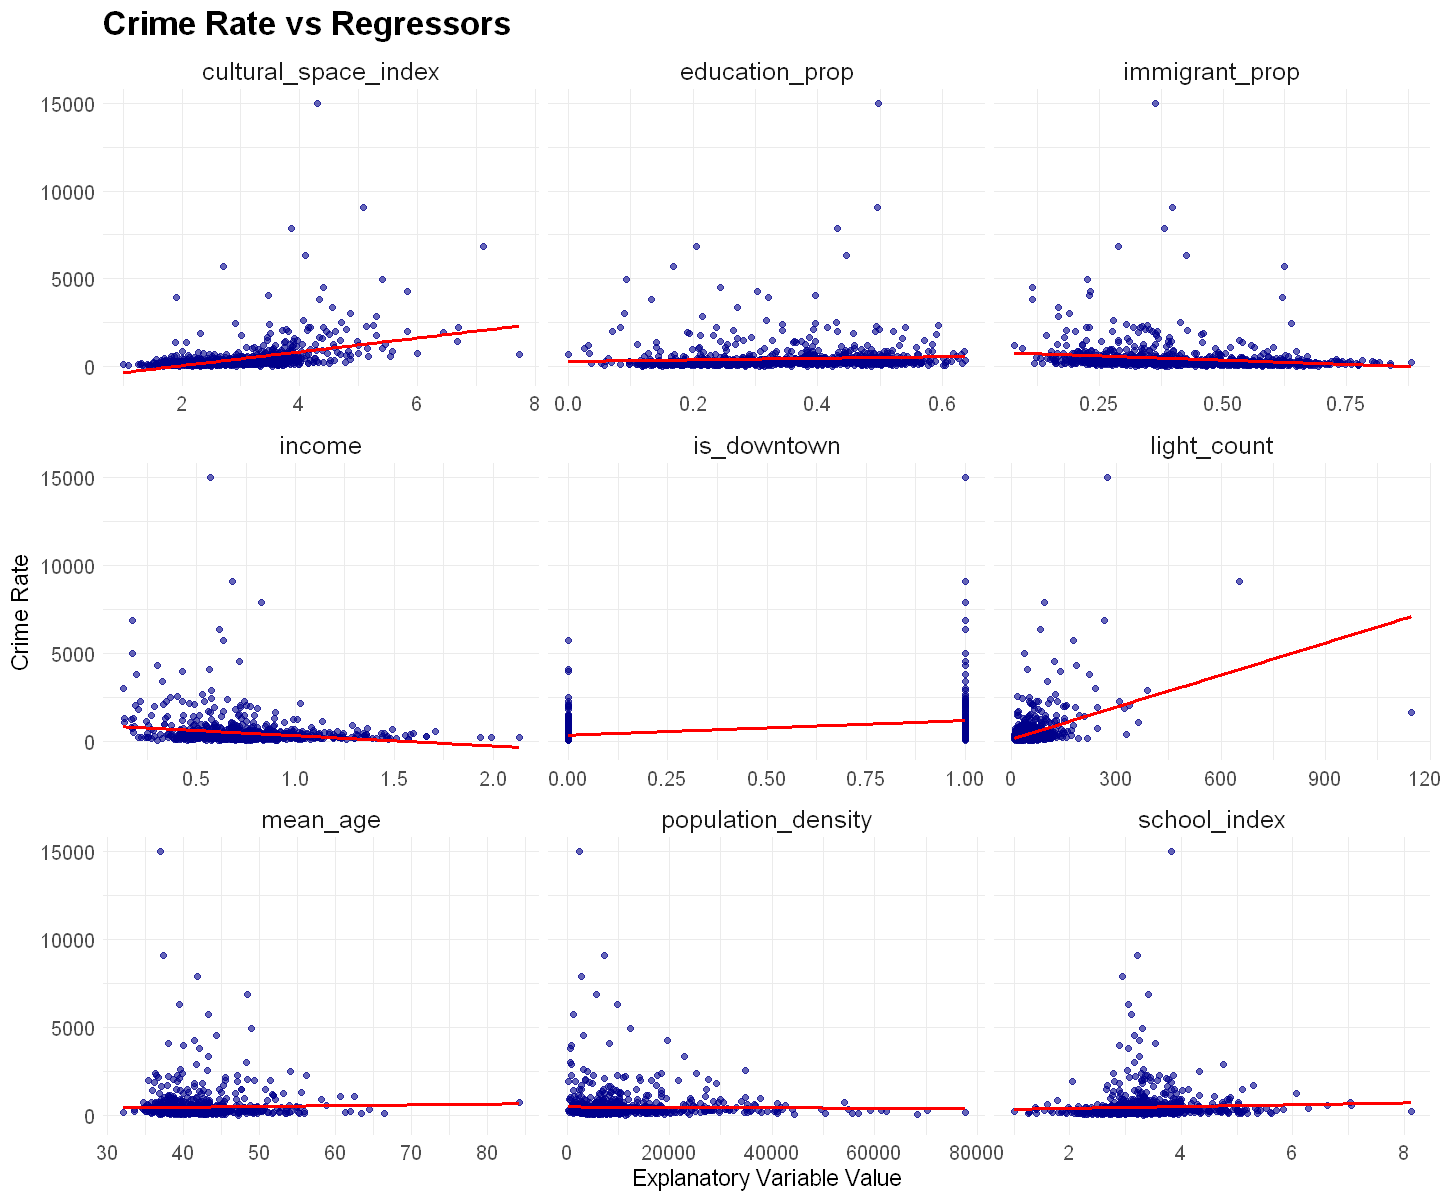

In [108]:
regressors_age_logless <- c('light_count', 'school_index', 'cultural_space_index', 
                'income', 'population_density', 'mean_age','immigrant_prop', 'education_prop','is_downtown')

long_data_age_logless <- census_index_crime_log_st_valid_density_age |>
  pivot_longer(cols = regressors_age_logless,
               names_to = "regressor",
               values_to = "value")

variables_scatter_age <- ggplot(long_data_age_logless, aes(x = value, y = crime_rate)) +
  geom_point(color = "darkblue", alpha = 0.6) +
  facet_wrap(~ regressor, scales = "free_x") + 
  labs(title = "Crime Rate vs Regressors",
       x = "Explanatory Variable Value",
       y = "Crime Rate") +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        strip.text = element_text(size = 15),  
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

variables_scatter_age

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(regressors_age)

  # Now:
  data %>% select(all_of(regressors_age))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."
`geom_smooth()` using formula = 'y ~ x'


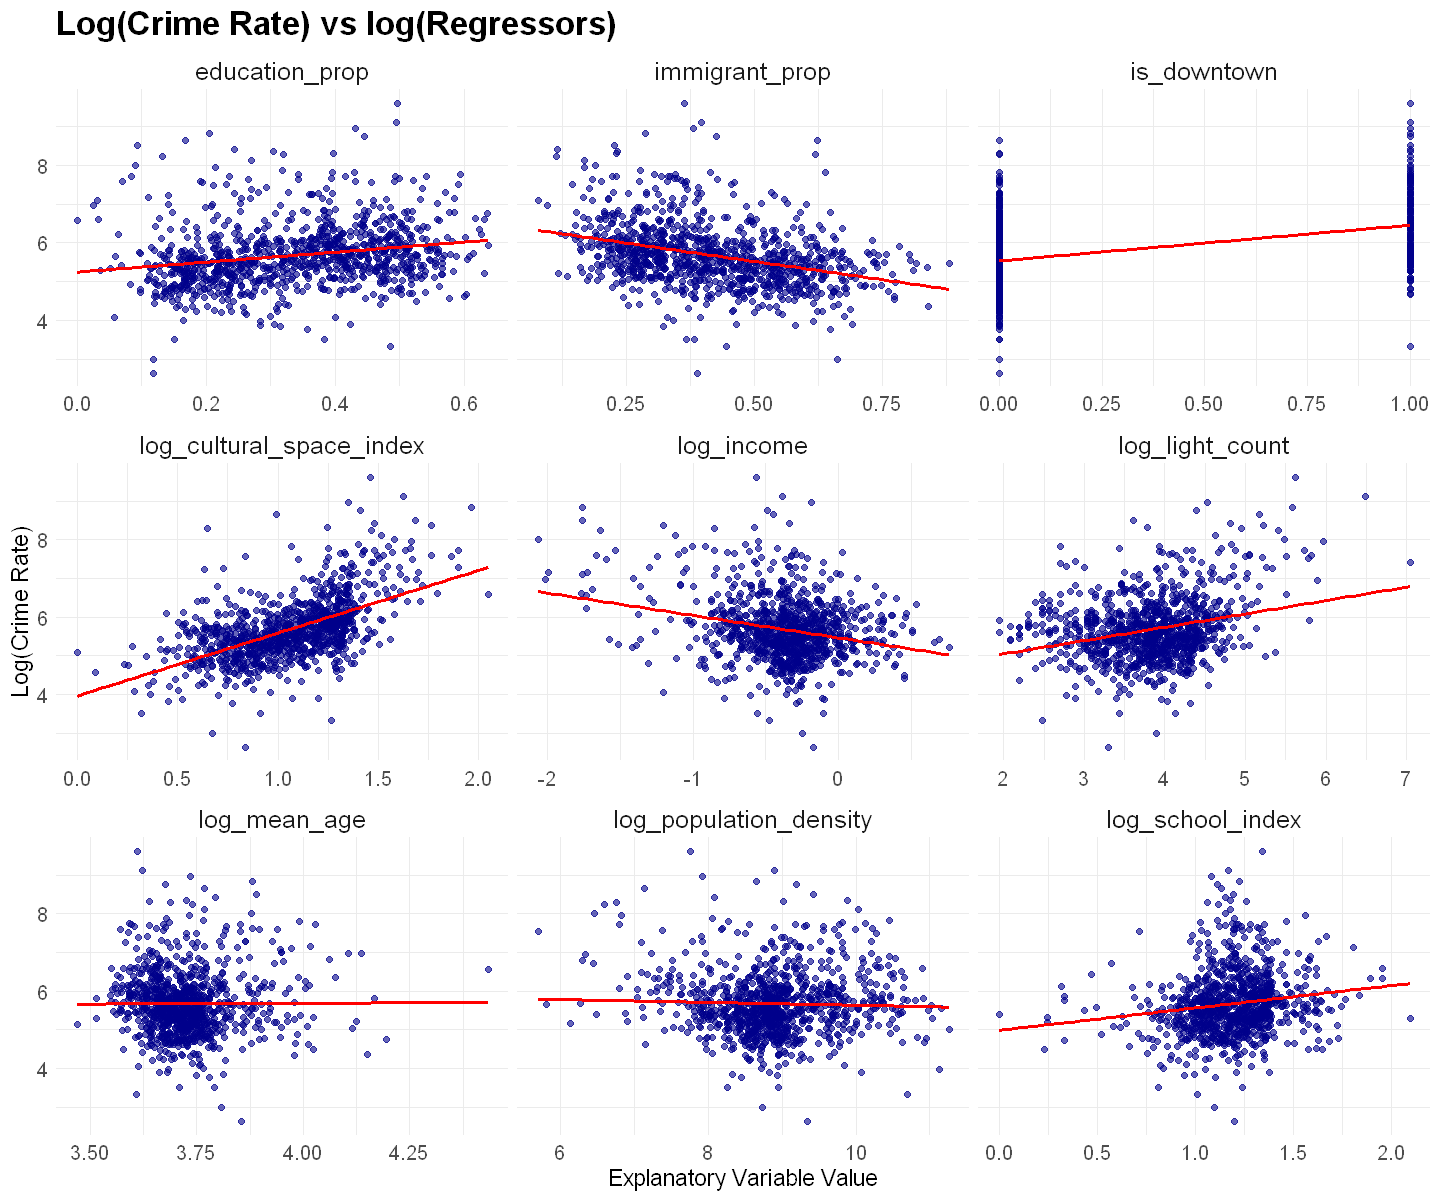

In [109]:
regressors_age <- c('log_light_count', 'log_school_index', 'log_cultural_space_index', 
                'log_income', 'log_population_density', 'log_mean_age','immigrant_prop', 'education_prop','is_downtown')

long_data_age <- census_index_crime_log_st_valid_density_age |>
  pivot_longer(cols = regressors_age,
               names_to = "regressor",
               values_to = "value")

log_log_variables_scatter_age <- ggplot(long_data_age, aes(x = value, y = log_crime_rate)) +
  geom_point(color = "darkblue", alpha = 0.6) +
  facet_wrap(~ regressor, scales = "free_x") + 
  labs(title = "Log(Crime Rate) vs log(Regressors)",
       x = "Explanatory Variable Value",
       y = "Log(Crime Rate)") +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        strip.text = element_text(size = 15),  
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

log_log_variables_scatter_age

In [110]:
# Conduct a regression on log(light count) only
reg_log_simple <- lm(log_crime_rate ~  log_light_count,
              data = census_index_crime_log_st_valid_density_age)

robust_se_simple <- sqrt(diag(vcovHC(reg_log_simple, type = "HC1")))

stargazer(reg_log_simple, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se_simple),
        single.row=TRUE)


Log-Log Regression Results with Robust Standard Errors
                        Dependent variable:    
                    ---------------------------
                          Log Crime Rate       
-----------------------------------------------
log_light_count          0.345*** (0.048)      
Constant                 4.358*** (0.181)      
-----------------------------------------------
Observations                    989            
R2                             0.076           
Adjusted R2                    0.075           
Residual Std. Error      0.785 (df = 987)      
F Statistic           81.162*** (df = 1; 987)  
Note:               *p<0.1; **p<0.05; ***p<0.01


In [ ]:
# Regressions with log_light_count always present
regressors_without_light_count <- c('log_mean_land_value', 'log_school_index', 'log_cultural_space_index', 
                'log_income', 'log_population_density', 'immigrant_prop', 'education_prop','insite_dummy','is_downtown','log_mean_age')

reg_with_light_count <-  map(regressors_without_light_count, ~ lm(as.formula(paste("log_crime_rate", "~ log_light_count +",  .x)), 
data = census_index_crime_log_st_valid_density_age))


stargazer(reg_log_simple, reg_with_light_count, type = "text",
          title = "Regression Results",
          covariate.labels = c("Log (Light Count)", 
               "Log (Mean Land Value)",
               "Log (School Index)", 
               "Log (Cultural Space Index)", 
               "Log Income", 
               "Log (Population Density)",
               "Immigrant Proportion", 
                "Education Proportion",
                "Containing Insite",
                "Is Downtown",
                "Log (Mean Age)"),
          dep.var.labels = c("Log (Crime Rate)", "Log (Crime Rate)"))


Regression Results
                                                                                                                                                       Dependent variable:                                                                                                                            
                           ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                              Log (Crime Rate)                                                                                                                      Log (Crime Rate)                                                                                                                  
                                     (1)                     (2)                     (3)       

In [122]:
# Create a new downtown only dataset
downtown_areas <- local_area_boundary_valid %>%
  filter(name %in% c("West End", "Downtown", "Strathcona"))

# census_index_crime_log_st_valid <- st_simplify(census_index_crime_log_st_valid_, dTolerance = 0.01)
# selected_areas <- st_simplify(selected_areas, dTolerance = 0.01)

# desired_crs <- st_crs(selected_areas)
# census_index_crime_log_st_valid <- st_transform(census_index_crime_log_st_valid, crs = desired_crs)

census_index_crime_log_st_valid_density_age_dt <- st_join(
  census_index_crime_log_st_valid_density_age,
  downtown_areas,
  join = st_within,
  left = FALSE
)

glimpse(census_index_crime_log_st_valid_density_age_dt)

Rows: 112
Columns: 43
$ name.x                   <chr> "59150751", "59150752", "59150753", "59150754…
$ households               <int> 349, 120, 116, 240, 413, 76, 254, 287, 191, 6…
$ dwellings                <int> 379, 142, 130, 267, 454, 109, 261, 299, 228, …
$ population               <int> 782, 300, 271, 456, 779, 203, 499, 577, 644, …
$ population_density       <dbl> 895.7, 7537.7, 9609.9, 10654.2, 15096.9, 8388…
$ region                   <chr> "Vancouver", "Vancouver", "Vancouver", "Vanco…
$ area_sq_km               <dbl> 0.87307, 0.03983, 0.02826, 0.04282, 0.05163, …
$ age                      <int> 785, 300, 275, 455, 780, 205, 495, 575, 645, …
$ income                   <dbl> 0.34624, 0.73216, 0.62080, 0.41600, 0.17740, …
$ immigrant_prop           <dbl> 0.3324808, 0.4000000, 0.1660517, 0.2850877, 0…
$ education_prop           <dbl> 0.2365729, 0.3833333, 0.3874539, 0.2960526, 0…
$ school_index             <dbl> 3.600271, 3.508716, 3.474039, 3.433914, 3.441…
$ light_index     

In [130]:
reg_log_dt <- lm(log_crime_rate ~  log_light_count + log_school_index +  log_cultural_space_index
               + log_income + log_population_density + immigrant_prop + education_prop + log_mean_age,
              data = census_index_crime_log_st_valid_density_age_dt)

white_test <- bptest(reg_log_dt, ~ fitted(reg_log_dt) + I(fitted(reg_log_dt)^2), data = census_index_crime_log_st_valid_density_age_dt)
print(white_test) 

robust_se_dt <- sqrt(diag(vcovHC(reg_log_dt, type = "HC1")))

stargazer(reg_log_dt, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        # se = list(robust_se_dt),
        single.row=TRUE)


	studentized Breusch-Pagan test

data:  reg_log_dt
BP = 0.98093, df = 2, p-value = 0.6123




Log-Log Regression Results with Robust Standard Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_light_count               0.467*** (0.098)      
log_school_index              -1.664** (0.709)      
log_cultural_space_index      1.745*** (0.591)      
log_income                     -0.250 (0.244)       
log_population_density        -0.457*** (0.119)     
immigrant_prop                 -0.408 (0.615)       
education_prop                 -0.703 (0.870)       
log_mean_age                  -1.177** (0.554)      
Constant                      13.482*** (2.952)     
----------------------------------------------------
Observations                         112            
R2                                  0.553           
Adjusted R2                         0.518           
Residual Std. Error           0.646 (df = 1

In [128]:
# Create a new dataset that exclude downtown
non_downtown_areas <- local_area_boundary_valid %>%
  filter(!name %in% c("West End", "Downtown", "Strathcona"))

census_index_crime_log_st_valid_density_age_ut <- st_join(
  census_index_crime_log_st_valid_density_age,
  non_downtown_areas,
  join = st_within,
  left = FALSE
)

glimpse(census_index_crime_log_st_valid_density_age_ut)

Rows: 608
Columns: 43
$ name.x                   <chr> "59150309", "59150311", "59150329", "59150330…
$ households               <int> 269, 181, 333, 174, 275, 246, 185, 192, 213, …
$ dwellings                <int> 299, 199, 356, 189, 307, 264, 202, 208, 225, …
$ population               <int> 745, 532, 959, 506, 782, 683, 541, 507, 618, …
$ population_density       <dbl> 6663.7, 6567.9, 3109.6, 6462.3, 5068.0, 6103.…
$ region                   <chr> "Vancouver", "Vancouver", "Vancouver", "Vanco…
$ area_sq_km               <dbl> 0.11190, 0.08094, 0.30854, 0.07820, 0.15441, …
$ age                      <int> 745, 530, 960, 510, 785, 680, 545, 505, 620, …
$ income                   <dbl> 0.84736, 0.82517, 0.66688, 0.82176, 0.67840, …
$ immigrant_prop           <dbl> 0.3557047, 0.4041353, 0.5422315, 0.3557312, 0…
$ education_prop           <dbl> 0.3154362, 0.2537594, 0.1876955, 0.1581028, 0…
$ school_index             <dbl> 2.283703, 2.388786, 2.677803, 2.721358, 3.545…
$ light_index     

In [131]:
reg_log_ut <- lm(log_crime_rate ~  log_light_count + log_school_index +  log_cultural_space_index
               + log_income + log_population_density + immigrant_prop + education_prop + log_mean_age,
              data = census_index_crime_log_st_valid_density_age_ut)

white_test <- bptest(reg_log_ut, ~ fitted(reg_log_ut) + I(fitted(reg_log_ut)^2), data = census_index_crime_log_st_valid_density_age_ut)
print(white_test) 

robust_se_ut <- sqrt(diag(vcovHC(reg_log_ut, type = "HC1")))

stargazer(reg_log_ut, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        # se = list(robust_se_ut),
        single.row=TRUE)


	studentized Breusch-Pagan test

data:  reg_log_ut
BP = 4.7499, df = 2, p-value = 0.09302




Log-Log Regression Results with Robust Standard Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_light_count               0.294*** (0.052)      
log_school_index               -0.219* (0.122)      
log_cultural_space_index      1.208*** (0.126)      
log_income                    -0.612*** (0.088)     
log_population_density        -0.237*** (0.053)     
immigrant_prop                -0.527*** (0.179)     
education_prop                1.115*** (0.197)      
log_mean_age                  -1.060*** (0.251)     
Constant                      9.138*** (1.166)      
----------------------------------------------------
Observations                         608            
R2                                  0.459           
Adjusted R2                         0.451           
Residual Std. Error           0.491 (df = 5

In [140]:
# Put 3 regressions together
stargazer(reg_log_dt, reg_log_ut, reg_log14, type = "text",
          title = "Regression Results",
          column.labels = c("Non Downtown", "Non Downtown", "Whole Vancouver"),
          covariate.labels = c("Log (Light Count)", 
               "Log (School Index)", 
               "Log (Cultural Space Index)", 
               "Log Income", 
               "Log (Population Density)",
               "Immigrant Proportion", 
                "Education Proportion",
                "Log (Mean Age)",
                "Log (Light Count) × Is Downtown"),
                se = list(NULL, NULL, robust_se14),
          dep.var.labels = c("Log (Crime Rate)", "Log (Crime Rate)"),
          single.row = TRUE)


Regression Results
                                                          Dependent variable:                           
                                ------------------------------------------------------------------------
                                                            Log (Crime Rate)                            
                                     Non Downtown            Non Downtown           Whole Vancouver     
                                          (1)                     (2)                     (3)           
--------------------------------------------------------------------------------------------------------
Log (Light Count)                  0.467*** (0.098)        0.294*** (0.052)         0.286*** (0.043)    
Log (School Index)                 -1.664** (0.709)         -0.219* (0.122)        -0.355*** (0.106)    
Log (Cultural Space Index)         1.745*** (0.591)        1.208*** (0.126)         1.310*** (0.112)    
Log Income                         

In [113]:
# Generate a complete regression output table showing how our ideas evolved
stargazer(reg_log7, reg_log8, reg_log11,  reg_log12, reg_log14, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log (Crime Rate)"), 
          covariate.labels = c(
                "Log (Light Count)", 
               "Log (Mean Land Value)",
               "Log (School Index)", 
               "Log (Cultural Space Index)", 
               "Log Income", 
               "Log (Population Density)",
               "Immigrant Proportion", 
                "Education Proportion",
                "Containing Insite",
                "Is Downtown",
                "Log (Mean Age)",
                "Log (Light Count) × Is Downtown"),
        se = list(robust_se7, robust_se8, robust_se11, robust_se12, robust_se14),
        single.row = TRUE,
        align=TRUE)


Log-Log Regression Results with Robust Standard Errors
                                                                                    Dependent variable:                                                     
                                ----------------------------------------------------------------------------------------------------------------------------
                                                                                      Log (Crime Rate)                                                      
                                          (1)                      (2)                      (3)                      (4)                      (5)           
------------------------------------------------------------------------------------------------------------------------------------------------------------
Log (Light Count)                   0.508*** (0.037)         0.520*** (0.037)         0.353*** (0.042)         0.296*** (0.043)         0.286*** (0.043)    
Lo

In [114]:
# Generate a complete regression output table showing how our ideas evolved
stargazer(reg_log7, reg_log8, reg_log11,  reg_log12, reg_log14, type = "latex", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log (Crime Rate)"), 
          covariate.labels = c(
                "Log (Light Count)", 
               "Log (Mean Land Value)",
               "Log (School Index)", 
               "Log (Cultural Space Index)", 
               "Log Income", 
               "Log (Population Density)",
               "Immigrant Proportion", 
                "Education Proportion",
                "Containing Insite",
                "Is Downtown",
                "Log (Mean Age)",
                "Log (Light Count) × Is Downtown"),
        se = list(robust_se7, robust_se8, robust_se11, robust_se12, robust_se14),
        single.row = TRUE,
        align=TRUE)


% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: 周一, 12月 02, 2024 - 20:43:03
% Requires LaTeX packages: dcolumn 
\begin{table}[!htbp] \centering 
  \caption{Log-Log Regression Results with Robust Standard Errors} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lD{.}{.}{-3} D{.}{.}{-3} D{.}{.}{-3} D{.}{.}{-3} D{.}{.}{-3} } 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{5}{c}{\textit{Dependent variable:}} \\ 
\cline{2-6} 
\\[-1.8ex] & \multicolumn{5}{c}{Log (Crime Rate)} \\ 
\\[-1.8ex] & \multicolumn{1}{c}{(1)} & \multicolumn{1}{c}{(2)} & \multicolumn{1}{c}{(3)} & \multicolumn{1}{c}{(4)} & \multicolumn{1}{c}{(5)}\\ 
\hline \\[-1.8ex] 
 Log (Light Count) & 0.508^{***}$ $(0.037) & 0.520^{***}$ $(0.037) & 0.353^{***}$ $(0.042) & 0.296^{***}$ $(0.043) & 0.286^{***}$ $(0.043) \\ 
  Log (Mean Land Value) & 0.084^{**}$ $(0.034) & 0.082^{**}$ $(0.035) &  &  &  \\ 
  Log (School Index) & -0.483^{***}$ $(0.10

In [115]:
stargazer(reg_log_simple, reg_log7, reg_log8, reg_log11,  reg_log12, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log (Crime Rate)"), 
          covariate.labels = c(
                "Log (Light Count)", 
               "Log (Mean Land Value)",
               "Log (School Index)", 
               "Log (Cultural Space Index)", 
               "Log Income", 
               "Log (Population Density)",
               "Immigrant Proportion", 
                "Education Proportion",
                "Containing Insite",
                "Is Downtown",
                "Log (Light Count) × Is Downtown"),
        se = list(robust_se_simple, robust_se7, robust_se8, robust_se11, robust_se12),
        single.row = TRUE)


Log-Log Regression Results with Robust Standard Errors
                                                                                    Dependent variable:                                                    
                                ---------------------------------------------------------------------------------------------------------------------------
                                                                                     Log (Crime Rate)                                                      
                                          (1)                     (2)                      (3)                      (4)                      (5)           
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Log (Light Count)                  0.345*** (0.048)         0.508*** (0.037)         0.520*** (0.037)         0.353*** (0.042)         0.296*** (0.043)    
Log (Mea